In [1]:
# LOAD Packages 
import uproot
import pandas as pd
import numpy as np
import awkward as ak
import h5py
!pip install awkward_pandas
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#matplotlib.rcParams['text.usetex'] = reco
import matplotlib.pyplot as plt
import os
import math
import csv
import seaborn as sns
import sympy as smp
import sympy.stats
import json
from scipy import stats,signal,ndimage,special,fft
from scipy.optimize import curve_fit
from scipy.integrate import quad
from mpl_toolkits.axes_grid1 import make_axes_locatable

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Open ROOT File 
#selFile = uproot.open("/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_CC_pi0/caf_studies/plotting/first_pass_general_CC1pi0_selection_MR6p2_with_mesons_fv_cut_xy2cm_z3cm_cathode2cm_mx2_any_track_PID_no_single_muon_cut.root")
selFile = uproot.open("/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_CC_pi0/caf_studies/plotting/first_pass_general_CC1pi0_selection_MR6p4_1000_files_with_mesons_fv_cut_xy2cm_z3cm_cathode2cm_mx2_any_track_PID_no_single_muon_cut.root")
#is_mc = True
selFileMR6p2 = uproot.open("/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_CC_pi0/caf_studies/plotting/first_pass_general_CC1pi0_selection_MR6p2_1000_files_with_mesons_fv_cut_xy2cm_z3cm_cathode2cm_mx2_any_track_PID_no_single_muon_cut.root")
is_mc = True
selFile = uproot.open("/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_CC_pi0/caf_studies/plotting/first_pass_general_CC1pi0_selection_SANDBOX_v6_with_mesons_fv_cut_xy2cm_z3cm_cathode2cm_mx2_any_track_PID_no_single_muon_cut.root")
is_mc = False

# Open Trees
def ttree_to_df(file, tree_name):
    
    #file[tree_name].show()
    file[tree_name].keys()
    file[tree_name][0].num_entries

    # Load ROOT Tree into DataFrame
    ak_array = file[tree_name].arrays(library="ak")
    ttree_df = ak.to_dataframe(ak_array)
    ttree_df = ttree_df.reset_index(drop=True)
    num_entries = len(ttree_df)
    print("Number of Entries in "+tree_name+" Tree: ", num_entries)
    ttree_df.head()

    return ttree_df

# Load Trees into DataFrames
reco_df = ttree_to_df(selFile, "RecoTree")
if is_mc == True:
    truth_df = ttree_to_df(selFile, "TruthTree")
    pureff_df = ttree_to_df(selFile, "PurEffTree")


# Check for duplicates
print("Truth DF Length: ", len(truth_df))
unique_truth_vtx_ys = np.unique(np.array(truth_df['truth_vtx_y']))
print("Unique Truth Vtx Y Length: ", len(unique_truth_vtx_ys))
print("------------------------\n")
print("Reco DF Length: ", len(reco_df))
unique_spills_from_reco = np.unique(np.array(reco_df['spill_index']))
print("Unique Spills from Reco Length: ", len(unique_spills_from_reco))
print("------------------------\n")


Number of Entries in RecoTree Tree:  13


NameError: name 'truth_df' is not defined

In [3]:
reco_df_MR6p2 = ttree_to_df(selFileMR6p2, "RecoTree")
if is_mc == True:
    truth_df_MR6p2 = ttree_to_df(selFileMR6p2, "TruthTree")
    pureff_df_MR6p2 = ttree_to_df(selFileMR6p2, "PurEffTree")

# Merge with indicator
reco_signal_df = reco_df[reco_df['true_ixn_is_signal'] == 1]
reco_signal_df_MR6p2 = reco_df_MR6p2[reco_df_MR6p2['true_ixn_is_signal'] == 1]
diff_df = reco_signal_df.merge(reco_signal_df_MR6p2, on='truth_dict_key', how='outer', indicator=True)
print("Number of entries in MR6p4: ", len(reco_signal_df))
print("Number of entries in MR6p2: ", len(reco_signal_df_MR6p2))
print("Number of entries in diff_df: ", len(diff_df))

# Rows only in df1
only_in_MR6p4 = diff_df[diff_df['_merge'] == 'left_only']
print("Number of entries only in MR6p4: ", len(only_in_MR6p4))

# Rows only in df2
only_in_MR6p2 = diff_df[diff_df['_merge'] == 'right_only']
print("Number of entries only in MR6p2: ", len(only_in_MR6p2))

# Rows that do not match in either
not_matching = diff_df[diff_df['_merge'] != 'both']
print("Number of entries not matching in either: ", len(not_matching))

print("------------------------------------------------------------------------")
# Compare truth dfs
diff_df_truth = truth_df.merge(truth_df_MR6p2, on='truth_vtx_y', how='outer', indicator=True)
print("Number of entries in truth_df MR6p4: ", len(truth_df))
print("Number of entries in truth_df MR6p2: ", len(truth_df_MR6p2))
print("Number of entries in diff_df_truth: ", len(diff_df_truth))
# Rows only in truth_df
only_in_truth_MR6p4 = diff_df_truth[diff_df_truth['_merge'] == 'left_only']
print("Number of entries only in truth_df MR6p4: ", len(only_in_truth_MR6p4))
# Rows only in truth_df_MR6p2
only_in_truth_MR6p2 = diff_df_truth[diff_df_truth['_merge'] == 'right_only']
print("Number of entries only in truth_df MR6p2: ", len(only_in_truth_MR6p2))
# Rows that do not match in either
not_matching_truth = diff_df_truth[diff_df_truth['_merge'] != 'both']
print("Number of entries not matching in either truth_df: ", len(not_matching_truth))


Number of Entries in RecoTree Tree:  1173
Number of entries in MR6p4:  0
Number of entries in MR6p2:  818
Number of entries in diff_df:  818
Number of entries only in MR6p4:  0
Number of entries only in MR6p2:  818
Number of entries not matching in either:  818
------------------------------------------------------------------------


NameError: name 'truth_df' is not defined

In [4]:
# Purity Efficiency plots

#cuts = ['No\ Cuts', 'Vertex\ Cut', 'Single Muon\ Cut', 'Mx2\ Muon\ Match\ Cut', 'Two\ Showers\ Cut']#, 'Charged\ Pions\ Cut', 'Charged\ Kaons\ Cut']
cuts = ['None', 'Fiducial\ Volume', 'Mx2\ Track\ Match', 'Two\ Showers']#, 'Charged\ Pions\ Cut', 'Charged\ Kaons\ Cut']

cuts_bold = [f'$\\mathbf{{{cut}}}$' for cut in cuts]
total_signal_true = pureff_df['total_signal'][0]
print("Total Signal: ", total_signal_true)
#signal_after_cuts = np.array([pureff_df['signal_reco_no_cuts'][0], pureff_df['signal_post_vtx_cut'][0], pureff_df['signal_post_muon_cut'][0], \
#                     pureff_df['signal_post_mx2_cut'][0], pureff_df['signal_post_shower_cut'][0]])#, pureff_df['signal_post_pion_cut'][0], pureff_df['signal_post_kaon_cut'][0]])
signal_after_cuts = np.array([pureff_df['signal_reco_no_cuts'][0], pureff_df['signal_post_vtx_cut'][0], \
                     pureff_df['signal_post_mx2_cut'][0], pureff_df['signal_post_shower_cut'][0]])#, pureff_df['signal_post_pion_cut'][0], pureff_df['signal_post_kaon_cut'][0]])

#all_after_cuts = np.array([pureff_df['all_reco_no_cuts'][0], pureff_df['all_post_vtx_cut'][0], pureff_df['all_post_muon_cut'][0], \
#                    pureff_df['all_post_mx2_cut'][0], pureff_df['all_post_shower_cut'][0]])#, pureff_df['all_post_pion_cut'][0], pureff_df['all_post_kaon_cut'][0]])
all_after_cuts = np.array([pureff_df['all_reco_no_cuts'][0], pureff_df['all_post_vtx_cut'][0], \
                    pureff_df['all_post_mx2_cut'][0], pureff_df['all_post_shower_cut'][0]])
efficiency = signal_after_cuts / total_signal_true
purity = signal_after_cuts / all_after_cuts

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 7))

# Plot on the left y-axis (Efficiency)
ax1.plot(cuts_bold, efficiency, linestyle='-', color='mediumblue', label='Efficiency', marker='o', markersize=3)
ax1.set_ylabel(r'$\mathbf{Efficiency}$', color='mediumblue', fontsize=14)
ax1.set_xlabel(r'$\mathbf{Selection\ Cuts}$', fontsize=14)
ax1.tick_params(axis='y', labelcolor='mediumblue')
ax1.set_ylim(0., 1.0)
ax1.set_xticks(range(len(cuts)))  # Set the x-ticks to match the number of cuts
ax1.set_xticklabels(cuts_bold, rotation=20, ha='right', fontsize=14) 
ax1.grid(axis='x', linestyle='--', color='gray', alpha=0.7)  # Adds vertical grid lines
ax1.grid(axis='y', linestyle='--', color='gray', alpha=0.7)

text_box_text = r"$\mathbf{Summary\ (Signal\ /\ Total)}$"
for i, cut in enumerate(cuts):

    #if i == 0:
    #    text_box_text += f"$\\mathbf{{{cut}:}}$ {signal_after_cuts[i]} / {all_after_cuts[i]}"
    #else:
        #text_box_text += f"\n{cut}: $\\mathbf{{{signal_after_cuts[i]}}}$ / {all_after_cuts[i]}"
    text_box_text += f"\n$\\mathbf{{{cut}:}}$ {signal_after_cuts[i]} / {all_after_cuts[i]}"
 
text_box_style = dict(boxstyle='round', facecolor='white', edgecolor='black')
plt.text(
    0.98, 0.97, text_box_text,
    transform=ax1.transAxes,
    fontsize=14,
    color='black',
    verticalalignment='top',
    horizontalalignment='right',
    multialignment='left', 
    bbox=text_box_style
)


# Create a second y-axis sharing the same x-axis (Purity)
ax2 = ax1.twinx()
ax2.plot(cuts_bold, purity, linestyle='dashed', color='crimson', label=r'Purity', marker='o', markersize=3)
ax2.set_ylabel(r'$\mathbf{Purity}$', color='crimson', fontsize=14)
ax2.tick_params(axis='y', labelcolor='crimson', labelsize=14)
ax2.set_ylim(0., 1.0)

# Add legends
#ax1.legend(loc='upper left')
#ax2.legend(loc='upper right')

# Show the plot
#plt.grid()
plt.title(r'$\nu_\mu$ CC1$\pi^0$ Inclusive Selection Efficiency and Purity', weight='bold', fontsize=16)
plt.show()
print("Truth DF length:", len(truth_df))


NameError: name 'pureff_df' is not defined

In [5]:
def get_shower_angle(px1, py1, pz1, px2, py2, pz2):
    """Calculate the angle between two 3D vectors."""
    dot_product = px1 * px2 + py1 * py2 + pz1 * pz2
    mag1 = np.sqrt(px1**2 + py1**2 + pz1**2)
    mag2 = np.sqrt(px2**2 + py2**2 + pz2**2)
    # Avoid division by zero
    mag1 = np.where(mag1==0, 1e-10, mag1)
    mag2 = np.where(mag2==0, 1e-10, mag2) 
    cos_theta = dot_product / (mag1 * mag2)
    return np.arccos(cos_theta)

def get_shower_angle_from_start_pts(vtx_x, vtx_y, vtx_z, x1, y1, z1, x2, y2, z2):
    # Calculate the angle between two showers using start points and neutrino vertex
    shower1_to_vtx = np.array([x1 - vtx_x, y1 - vtx_y, z1 - vtx_z])
    shower2_to_vtx = np.array([x2 - vtx_x, y2 - vtx_y, z2 - vtx_z])
    dot_product = shower1_to_vtx[0] * shower2_to_vtx[0] + shower1_to_vtx[1] * shower2_to_vtx[1] \
                + shower1_to_vtx[2] * shower2_to_vtx[2]
    mag1 = np.sqrt(shower1_to_vtx[0]**2 + shower1_to_vtx[1]**2 + shower1_to_vtx[2]**2)
    mag2 = np.sqrt(shower2_to_vtx[0]**2 + shower2_to_vtx[1]**2 + shower2_to_vtx[2]**2)
    cos_theta = dot_product / (mag1 * mag2)
    return np.arccos(cos_theta)

reco_df['true_match_lead_shower_energy'] = reco_df['true_match_lead_shower_energy']*1000 # Convert to MeV
reco_df['true_match_lead_shower_p_x'] = reco_df['true_match_lead_shower_p_x']*1000 # Convert to MeV
reco_df['true_match_lead_shower_p_y'] = reco_df['true_match_lead_shower_p_y']*1000 # Convert to MeV
reco_df['true_match_lead_shower_p_z'] = reco_df['true_match_lead_shower_p_z']*1000 # Convert to MeV
reco_df['true_match_sublead_shower_energy'] = reco_df['true_match_sublead_shower_energy']*1000 # Convert to MeV
reco_df['true_match_sublead_shower_p_x'] = reco_df['true_match_sublead_shower_p_x']*1000 # Convert to MeV
reco_df['true_match_sublead_shower_p_y'] = reco_df['true_match_sublead_shower_p_y']*1000 # Convert to MeV
reco_df['true_match_sublead_shower_p_z'] = reco_df['true_match_sublead_shower_p_z']*1000 # Convert to MeV
reco_df['reco_lead_shower_energy'] = reco_df['reco_lead_shower_energy']*1000 # Convert to MeV
reco_df['reco_lead_shower_p_x'] = reco_df['reco_lead_shower_p_x']*1000 # Convert to MeV
reco_df['reco_lead_shower_p_y'] = reco_df['reco_lead_shower_p_y']*1000 # Convert to MeV
reco_df['reco_lead_shower_p_z'] = reco_df['reco_lead_shower_p_z']*1000 # Convert to MeV
reco_df['reco_sublead_shower_energy'] = reco_df['reco_sublead_shower_energy']*1000 # Convert to MeV
reco_df['reco_sublead_shower_p_x'] = reco_df['reco_sublead_shower_p_x']*1000 # Convert to MeV
reco_df['reco_sublead_shower_p_y'] = reco_df['reco_sublead_shower_p_y']*1000 # Convert to MeV
reco_df['reco_sublead_shower_p_z'] = reco_df['reco_sublead_shower_p_z']*1000 # Convert to MeV


reco_df['true_match_shower_angle'] = get_shower_angle(
    reco_df['true_match_lead_shower_p_x'], 
    reco_df['true_match_lead_shower_p_y'], 
    reco_df['true_match_lead_shower_p_z'], 
    reco_df['true_match_sublead_shower_p_x'], 
    reco_df['true_match_sublead_shower_p_y'], 
    reco_df['true_match_sublead_shower_p_z']
)
reco_df['reco_shower_angle'] = get_shower_angle(
    reco_df['reco_lead_shower_p_x'], 
    reco_df['reco_lead_shower_p_y'], 
    reco_df['reco_lead_shower_p_z'], 
    reco_df['reco_sublead_shower_p_x'], 
    reco_df['reco_sublead_shower_p_y'], 
    reco_df['reco_sublead_shower_p_z']
)

reco_df['true_match_lead_shower_thetaz'] = get_shower_angle(
    reco_df['true_match_lead_shower_p_x'],
    reco_df['true_match_lead_shower_p_y'],
    reco_df['true_match_lead_shower_p_z'],
    np.zeros(len(reco_df['true_match_lead_shower_p_x'])),  # Assuming x-component is zero for theta_z
    np.zeros(len(reco_df['true_match_lead_shower_p_y'])),  # Assuming y-component is zero for theta_z
    np.ones(len(reco_df['true_match_lead_shower_p_z']))  # Assuming z-component is one for theta_z
)
reco_df['true_match_lead_shower_thetay'] = get_shower_angle(
    reco_df['true_match_lead_shower_p_x'],
    reco_df['true_match_lead_shower_p_y'],
    reco_df['true_match_lead_shower_p_z'],
    np.zeros(len(reco_df['true_match_lead_shower_p_x'])),  # Assuming x-component is zero for theta_y
    np.ones(len(reco_df['true_match_lead_shower_p_y'])),  # Assuming y-component is one for theta_y
    np.zeros(len(reco_df['true_match_lead_shower_p_z']))  # Assuming z-component is zero for theta_y
)
reco_df['true_match_lead_shower_thetax'] = get_shower_angle(
    reco_df['true_match_lead_shower_p_x'],
    reco_df['true_match_lead_shower_p_y'],
    reco_df['true_match_lead_shower_p_z'],
    np.ones(len(reco_df['true_match_lead_shower_p_x'])),  # Assuming x-component is one for theta_x
    np.zeros(len(reco_df['true_match_lead_shower_p_y'])),  # Assuming y-component is zero for theta_x
    np.zeros(len(reco_df['true_match_lead_shower_p_z']))  # Assuming z-component is zero for theta_x
)
reco_df['reco_lead_shower_thetaz'] = get_shower_angle(
    reco_df['reco_lead_shower_p_x'],
    reco_df['reco_lead_shower_p_y'],
    reco_df['reco_lead_shower_p_z'],
    np.zeros(len(reco_df['reco_lead_shower_p_x'])),  # Assuming x-component is zero for theta_z
    np.zeros(len(reco_df['reco_lead_shower_p_y'])),  # Assuming y-component is zero for theta_z     
    np.ones(len(reco_df['reco_lead_shower_p_z']))  # Assuming z-component is one for theta_z
)
reco_df['reco_lead_shower_thetay'] = get_shower_angle(
    reco_df['reco_lead_shower_p_x'],
    reco_df['reco_lead_shower_p_y'],
    reco_df['reco_lead_shower_p_z'],            
    np.zeros(len(reco_df['reco_lead_shower_p_x'])),  # Assuming x-component is zero for theta_y
    np.ones(len(reco_df['reco_lead_shower_p_y'])),  # Assuming y-component is one for theta_y
    np.zeros(len(reco_df['reco_lead_shower_p_z']))  # Assuming z-component is zero for theta_y
)
reco_df['reco_lead_shower_thetax'] = get_shower_angle(
    reco_df['reco_lead_shower_p_x'],
    reco_df['reco_lead_shower_p_y'],
    reco_df['reco_lead_shower_p_z'],
    np.ones(len(reco_df['reco_lead_shower_p_x'])),  # Assuming x-component is one for theta_x       
    np.zeros(len(reco_df['reco_lead_shower_p_y'])),  # Assuming y-component is zero for theta_x
    np.zeros(len(reco_df['reco_lead_shower_p_z']))  # Assuming z-component is zero for theta_x
)
reco_df['true_match_sublead_shower_thetaz'] = get_shower_angle(
    reco_df['true_match_sublead_shower_p_x'],
    reco_df['true_match_sublead_shower_p_y'],
    reco_df['true_match_sublead_shower_p_z'],
    np.zeros(len(reco_df['true_match_sublead_shower_p_x'])),  # Assuming x-component is zero for theta_z
    np.zeros(len(reco_df['true_match_sublead_shower_p_y'])),  # Assuming y-component is zero for theta_z
    np.ones(len(reco_df['true_match_sublead_shower_p_z']))  # Assuming z-component is one for theta_z
)
reco_df['true_match_sublead_shower_thetay'] = get_shower_angle(
    reco_df['true_match_sublead_shower_p_x'],
    reco_df['true_match_sublead_shower_p_y'],
    reco_df['true_match_sublead_shower_p_z'],           
    np.zeros(len(reco_df['true_match_sublead_shower_p_x'])),  # Assuming x-component is zero for theta_y
    np.ones(len(reco_df['true_match_sublead_shower_p_y'])),  # Assuming y-component is one for theta_y
    np.zeros(len(reco_df['true_match_sublead_shower_p_z']))  # Assuming z-component is zero for theta_y
)
reco_df['true_match_sublead_shower_thetax'] = get_shower_angle(
    reco_df['true_match_sublead_shower_p_x'],   
    reco_df['true_match_sublead_shower_p_y'],
    reco_df['true_match_sublead_shower_p_z'],
    np.ones(len(reco_df['true_match_sublead_shower_p_x'])),  # Assuming x-component is one for theta_x
    np.zeros(len(reco_df['true_match_sublead_shower_p_y'])),  # Assuming y-component is zero for theta_x
    np.zeros(len(reco_df['true_match_sublead_shower_p_z']))  # Assuming z-component is zero for theta_x
)
reco_df['reco_sublead_shower_thetaz'] = get_shower_angle(
    reco_df['reco_sublead_shower_p_x'],
    reco_df['reco_sublead_shower_p_y'],
    reco_df['reco_sublead_shower_p_z'],
    np.zeros(len(reco_df['reco_sublead_shower_p_x'])),  # Assuming x-component is zero for theta_z
    np.zeros(len(reco_df['reco_sublead_shower_p_y'])),  # Assuming y-component is zero for theta_z
    np.ones(len(reco_df['reco_sublead_shower_p_z']))  # Assuming z-component is one for theta_z
)
reco_df['reco_sublead_shower_thetay'] = get_shower_angle(
    reco_df['reco_sublead_shower_p_x'],
    reco_df['reco_sublead_shower_p_y'],
    reco_df['reco_sublead_shower_p_z'],
    np.zeros(len(reco_df['reco_sublead_shower_p_x'])),  # Assuming x-component is zero for theta_y
    np.ones(len(reco_df['reco_sublead_shower_p_y'])),  # Assuming y-component is one for theta_y
    np.zeros(len(reco_df['reco_sublead_shower_p_z']))  # Assuming z-component is zero for theta_y
)
reco_df['reco_sublead_shower_thetax'] = get_shower_angle(
    reco_df['reco_sublead_shower_p_x'],
    reco_df['reco_sublead_shower_p_y'],
    reco_df['reco_sublead_shower_p_z'],
    np.ones(len(reco_df['reco_sublead_shower_p_x'])),  # Assuming x-component is one for theta_x
    np.zeros(len(reco_df['reco_sublead_shower_p_y'])),  # Assuming y-component is zero for theta_x
    np.zeros(len(reco_df['reco_sublead_shower_p_z']))  # Assuming z-component is zero for theta_x
)



if is_mc==True:
    reco_df['true_match_shower_angle_start_pts'] = get_shower_angle_from_start_pts(
        reco_df['true_ixn_vtx_x_pos'],
        reco_df['true_ixn_vtx_y_pos'],
        reco_df['true_ixn_vtx_z_pos'],
        reco_df['true_match_lead_shower_start_x'],
        reco_df['true_match_lead_shower_start_y'],
        reco_df['true_match_lead_shower_start_z'],
        reco_df['true_match_sublead_shower_start_x'],
        reco_df['true_match_sublead_shower_start_y'],
        reco_df['true_match_sublead_shower_start_z']
    )

    reco_df['reco_shower_angle_start_pts'] = get_shower_angle_from_start_pts(
        reco_df['reco_ixn_vtx_x_pos'],
        reco_df['reco_ixn_vtx_y_pos'],
        reco_df['reco_ixn_vtx_z_pos'],
        reco_df['reco_lead_shower_start_x'],
        reco_df['reco_lead_shower_start_y'],
        reco_df['reco_lead_shower_start_z'],
        reco_df['reco_sublead_shower_start_x'],
        reco_df['reco_sublead_shower_start_y'],
        reco_df['reco_sublead_shower_start_z']
    )

# Calculate invariant mass of pi0 from showers

def diphoton_invariant_mass(E1, E2, theta):

    m = np.sqrt(2*E1*E2*(1-np.cos(theta)))
    return m



reco_df['true_match_diphoton_invariant_mass'] = diphoton_invariant_mass(
    reco_df['true_match_lead_shower_energy'], 
    reco_df['true_match_sublead_shower_energy'], 
    reco_df['true_match_shower_angle']
)
reco_df['reco_diphoton_invariant_mass'] = diphoton_invariant_mass(
    reco_df['reco_lead_shower_energy'], 
    reco_df['reco_sublead_shower_energy'], 
    reco_df['reco_shower_angle']
)

def get_shower_conversion_distance(x1, y1, z1, x2, y2, z2):
    """Calculate the distance between two 3D points."""
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)

reco_df['true_match_lead_shower_conversion_distance'] = get_shower_conversion_distance(
    reco_df['true_ixn_vtx_x_pos'], 
    reco_df['true_ixn_vtx_y_pos'], 
    reco_df['true_ixn_vtx_z_pos'], 
    reco_df['true_match_lead_shower_start_x'], 
    reco_df['true_match_lead_shower_start_y'], 
    reco_df['true_match_lead_shower_start_z']
)
reco_df['true_match_sublead_shower_conversion_distance'] = get_shower_conversion_distance(
    reco_df['true_ixn_vtx_x_pos'], 
    reco_df['true_ixn_vtx_y_pos'], 
    reco_df['true_ixn_vtx_z_pos'], 
    reco_df['true_match_sublead_shower_start_x'], 
    reco_df['true_match_sublead_shower_start_y'], 
    reco_df['true_match_sublead_shower_start_z']
)
reco_df['reco_lead_shower_conversion_distance'] = get_shower_conversion_distance(
    reco_df['reco_ixn_vtx_x_pos'], 
    reco_df['reco_ixn_vtx_y_pos'], 
    reco_df['reco_ixn_vtx_z_pos'], 
    reco_df['reco_lead_shower_start_x'], 
    reco_df['reco_lead_shower_start_y'], 
    reco_df['reco_lead_shower_start_z']
)
reco_df['reco_sublead_shower_conversion_distance'] = get_shower_conversion_distance(
    reco_df['reco_ixn_vtx_x_pos'], 
    reco_df['reco_ixn_vtx_y_pos'], 
    reco_df['reco_ixn_vtx_z_pos'], 
    reco_df['reco_sublead_shower_start_x'], 
    reco_df['reco_sublead_shower_start_y'], 
    reco_df['reco_sublead_shower_start_z']
)
# Save the modified DataFrame to a new ROOT file

In [7]:
# Look into what the background is ...

reco_signal_df = reco_df[reco_df['true_ixn_is_signal'] == 1]
reco_bkg_df = reco_df[reco_df['true_ixn_is_signal'] == 0]
#print("Number of expected background events:", all_after_cuts[-1] - signal_after_cuts[-1])

print("Number of Background Events Selected:", len(reco_bkg_df))
print("Number of Signal Events Selected:", len(reco_signal_df))

bkg_df_no_pi0 = reco_bkg_df[reco_bkg_df['true_ixn_pi0_mult'] == 0]
bkg_df_one_pi0 = reco_bkg_df[reco_bkg_df['true_ixn_pi0_mult'] == 1]
bkg_df_npi0 = reco_bkg_df[reco_bkg_df['true_ixn_pi0_mult'] > 1]
print("Number of Background Events with 0 Pi0: ", len(bkg_df_no_pi0))
print("Number of Background Events with 1 Pi0: ", len(bkg_df_one_pi0))
print("Number of Background Events with > 1 Pi0: ", len(bkg_df_npi0))
print("-------------------------")

print("Number of Background Events with electron neutrinos: ", len(reco_bkg_df[reco_bkg_df['true_ixn_nu_pdg'] == 12]))
print("Number of Background Events with muon neutrinos: ", len(reco_bkg_df[reco_bkg_df['true_ixn_nu_pdg'] == 14]))
print("Number of Background Events with electron antineutrinos: ", len(reco_bkg_df[reco_bkg_df['true_ixn_nu_pdg'] == -12]))
bkg_nue_df = reco_bkg_df[abs(reco_bkg_df['true_ixn_nu_pdg']) == 12]
print("Number of Background Events with muon antineutrinos: ", len(reco_bkg_df[reco_bkg_df['true_ixn_nu_pdg'] == -14]))
print("--------------------------")

print("Total NC Background Events: ", len(reco_bkg_df[reco_bkg_df['true_ixn_is_cc'] == 0]))
print("Number of NC 0 pi0 Background Events: ", len(bkg_df_no_pi0[bkg_df_no_pi0['true_ixn_is_cc'] == 0]))
print("Number of NC 1 pi0 Background Events: ", len(bkg_df_one_pi0[bkg_df_one_pi0['true_ixn_is_cc'] == 0]))
print("Number of NC > 1 pi0 Background Events: ", len(bkg_df_npi0[bkg_df_npi0['true_ixn_is_cc'] == 0]))
bkg_df_nc_0pi0 = bkg_df_no_pi0[bkg_df_no_pi0['true_ixn_is_cc'] == 0]
bkg_df_cc_0pi0 = bkg_df_no_pi0[bkg_df_no_pi0['true_ixn_is_cc'] == 1]
bkg_df_nc_1pi0 = bkg_df_one_pi0[bkg_df_one_pi0['true_ixn_is_cc'] == 0]
bkg_df_cc_1pi0 = bkg_df_one_pi0[bkg_df_one_pi0['true_ixn_is_cc'] == 1]
bkg_df_nc_npi0 = bkg_df_npi0[bkg_df_npi0['true_ixn_is_cc'] == 0]
bkg_df_cc_npi0 = bkg_df_npi0[bkg_df_npi0['true_ixn_is_cc'] == 1]
print("-------------------------")

bkg_df_nc_0pi0_out_of_fv = bkg_df_nc_0pi0[bkg_df_nc_0pi0['true_ixn_is_in_fv'] == 0]
bkg_df_nc_0pi0_in_fv = bkg_df_nc_0pi0[bkg_df_nc_0pi0['true_ixn_is_in_fv'] == 1]
bkg_df_cc_0pi0_out_of_fv = bkg_df_cc_0pi0[bkg_df_cc_0pi0['true_ixn_is_in_fv'] == 0]
bkg_df_cc_0pi0_in_fv = bkg_df_cc_0pi0[bkg_df_cc_0pi0['true_ixn_is_in_fv'] == 1]
bkg_df_nc_1pi0_out_of_fv = bkg_df_nc_1pi0[bkg_df_nc_1pi0['true_ixn_is_in_fv'] == 0]
bkg_df_nc_1pi0_in_fv = bkg_df_nc_1pi0[bkg_df_nc_1pi0['true_ixn_is_in_fv'] == 1]
bkg_df_cc_1pi0_out_of_fv = bkg_df_cc_1pi0[bkg_df_cc_1pi0['true_ixn_is_in_fv'] == 0]
bkg_df_cc_1pi0_in_fv = bkg_df_cc_1pi0[bkg_df_cc_1pi0['true_ixn_is_in_fv'] == 1]
bkg_df_nc_npi0_out_of_fv = bkg_df_nc_npi0[bkg_df_nc_npi0['true_ixn_is_in_fv'] == 0]
bkg_df_nc_npi0_in_fv = bkg_df_nc_npi0[bkg_df_nc_npi0['true_ixn_is_in_fv'] == 1]
bkg_df_cc_npi0_out_of_fv = bkg_df_cc_npi0[bkg_df_cc_npi0['true_ixn_is_in_fv'] == 0]
bkg_df_cc_npi0_in_fv = bkg_df_cc_npi0[bkg_df_cc_npi0['true_ixn_is_in_fv'] == 1]
print("Number of NC 0 pi0 Background Events Out of FV: ", len(bkg_df_nc_0pi0_out_of_fv))
print("Number of NC 0 pi0 Background Events In FV: ", len(bkg_df_nc_0pi0_in_fv))
print("Number of CC 0 pi0 Background Events Out of FV: ", len(bkg_df_cc_0pi0_out_of_fv))
print("Number of CC 0 pi0 Background Events In FV: ", len(bkg_df_cc_0pi0_in_fv))
print("Number of NC 1 pi0 Background Events Out of FV: ", len(bkg_df_nc_1pi0_out_of_fv))
print("Number of NC 1 pi0 Background Events In FV: ", len(bkg_df_nc_1pi0_in_fv))
print("Number of CC 1 pi0 Background Events Out of FV: ", len(bkg_df_cc_1pi0_out_of_fv))
print("Number of CC 1 pi0 Background Events In FV: ", len(bkg_df_cc_1pi0_in_fv))
print("Number of NC > 1 pi0 Background Events Out of FV: ", len(bkg_df_nc_npi0_out_of_fv))
print("Number of NC > 1 pi0 Background Events In FV: ", len(bkg_df_nc_npi0_in_fv))
print("Number of CC > 1 pi0 Background Events Out of FV: ", len(bkg_df_cc_npi0_out_of_fv))
print("Number of CC > 1 pi0 Background Events In FV: ", len(bkg_df_cc_npi0_in_fv))
print("-------------------------")

if is_mc:
    dataframes = [bkg_df_no_pi0, bkg_df_one_pi0, bkg_df_npi0, reco_signal_df]
    labels = [r'Bkg (True 0$\pi^0$)', r'Bkg (True 1$\pi^0$)', r'Bkg (True >1$\pi^0$)', 'Signal']
    colors = ['darkslateblue', 'cornflowerblue', 'skyblue', 'orangered']
else:
    dataframes = [reco_df]
    labels = ['Sandbox v6 Data']
    colors = ['darkgrey']

print("Number of events in RECO df: ", len(reco_df))

Number of Background Events Selected: 13
Number of Signal Events Selected: 0
Number of Background Events with 0 Pi0:  0
Number of Background Events with 1 Pi0:  0
Number of Background Events with > 1 Pi0:  0
-------------------------
Number of Background Events with electron neutrinos:  0
Number of Background Events with muon neutrinos:  0
Number of Background Events with electron antineutrinos:  0
Number of Background Events with muon antineutrinos:  0
--------------------------
Total NC Background Events:  13
Number of NC 0 pi0 Background Events:  0
Number of NC 1 pi0 Background Events:  0
Number of NC > 1 pi0 Background Events:  0
-------------------------
Number of NC 0 pi0 Background Events Out of FV:  0
Number of NC 0 pi0 Background Events In FV:  0
Number of CC 0 pi0 Background Events Out of FV:  0
Number of CC 0 pi0 Background Events In FV:  0
Number of NC 1 pi0 Background Events Out of FV:  0
Number of NC 1 pi0 Background Events In FV:  0
Number of CC 1 pi0 Background Events O

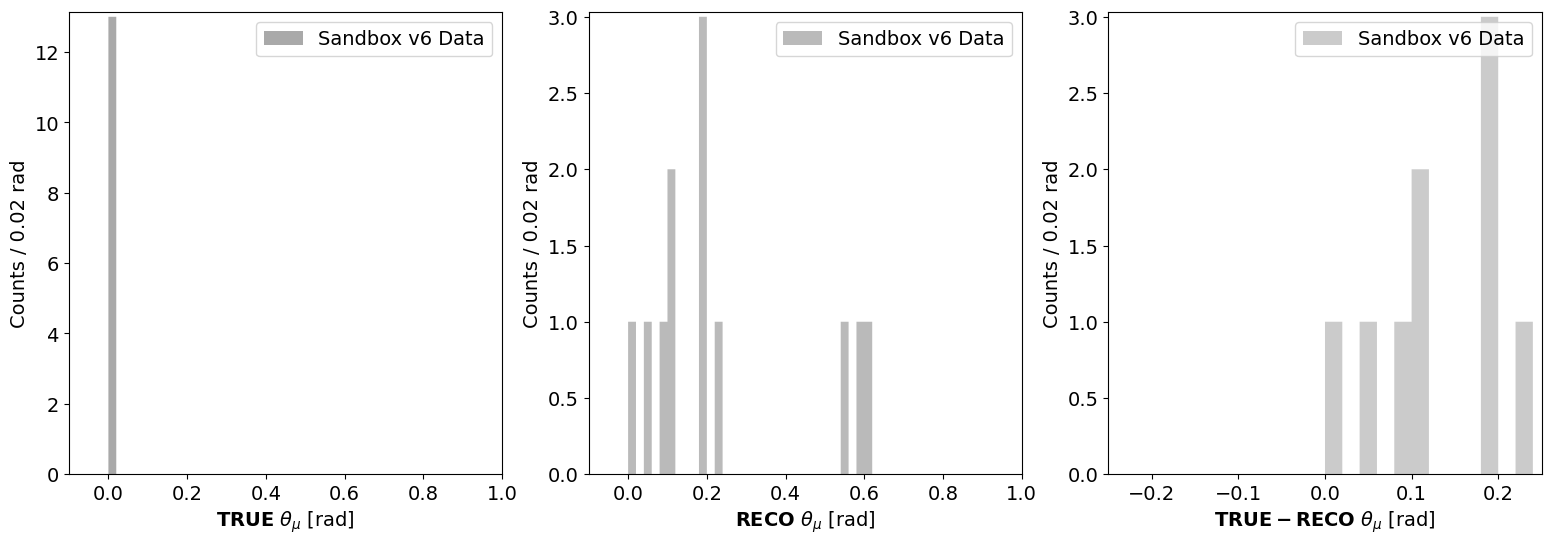

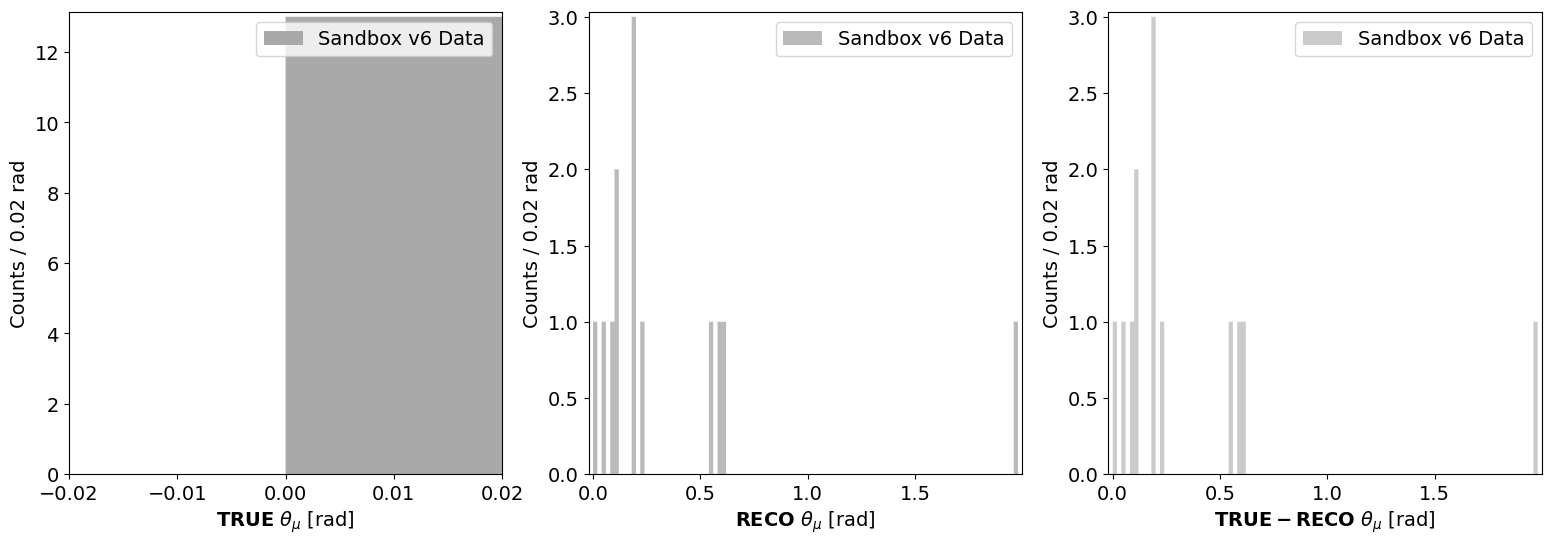

In [8]:
# Muon angle plots
def make_single_var_sig_bkg_plots(list_of_dfs, list_of_labels, list_of_colors, var_name, true_var_label, \
                                  reco_var_label, gen_bins, diff_bins, units, \
                                  xlim_min_default, xlim_max_default, diff_xlim_min_default, diff_xlim_max_default,\
                                  full_range=False):

    fig, ax = plt.subplots(1,3, figsize=(19, 6))

    bin_size = abs((gen_bins[1] - gen_bins[0]))
    diff_bin_size = abs((diff_bins[1] - diff_bins[0]))

    # Plot the TRUE variable
    df_true_cols_list = [df[true_var_label] for df in list_of_dfs]
    ax[0].hist(df_true_cols_list, bins=gen_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True)
    if full_range == True:
        xlim_min = min([min(val) for val in df_true_cols_list])
        xlim_max = max([max(val) for val in df_true_cols_list])
        ax[0].set_xlim(xlim_min-bin_size, xlim_max+bin_size)
    else:
        ax[0].set_xlim(xlim_min_default, xlim_max_default)
    for i in range(len(list_of_dfs)):
        data_hist, _ = np.histogram(df_true_cols_list[i], bins=gen_bins)
        if i == 0:
            stacked_data_hist = data_hist
        else:
            stacked_data_hist += data_hist
    ylim_max = max(stacked_data_hist)
    ax[0].set_ylim(0, ylim_max*1.01)
    ax[0].set_xlabel(r'$\mathbf{TRUE}$ '+var_name+ ' ['+units+']', fontsize=14)
    ax[0].tick_params(axis="x", labelsize=14)
    ax[0].tick_params(axis="y", labelsize=14)
    ax[0].set_ylabel('Counts / '+ str(round(bin_size, 2)) + ' ' + units, fontsize=14)
    ax[0].legend(loc='upper right', fontsize=14)

    # Plot the RECO variable
    df_reco_cols_list = [df[reco_var_label] for df in list_of_dfs]
    ax[1].hist(df_reco_cols_list, bins=gen_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True, alpha=0.8)
    if full_range == True:
        xlim_min = min([min(val) for val in df_reco_cols_list])
        xlim_max = max([max(val) for val in df_reco_cols_list])
        ax[1].set_xlim(xlim_min-bin_size, xlim_max+bin_size)
    else:
        ax[1].set_xlim(xlim_min_default, xlim_max_default)
    for i in range(len(list_of_dfs)):
        data_hist, _ = np.histogram(df_reco_cols_list[i], bins=gen_bins)
        if i == 0:
            stacked_data_hist = data_hist
        else:
            stacked_data_hist += data_hist
    ylim_max = max(stacked_data_hist)
    ax[1].set_ylim(0, ylim_max*1.01)
    ax[1].tick_params(axis="x", labelsize=14)
    ax[1].tick_params(axis="y", labelsize=14)
    ax[1].set_xlabel(r'$\mathbf{RECO}$ '+var_name+ ' ['+units+']', fontsize=14)
    ax[1].set_ylabel('Counts / '+ str(round(bin_size, 2)) + ' ' + units, fontsize=14)
    ax[1].legend(loc='upper right', fontsize=14)

    # Plot TRUE - RECO 
    df_diff_cols_list = [df[reco_var_label]-df[true_var_label] for df in list_of_dfs]
    ax[2].hist(df_diff_cols_list, bins=diff_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True, alpha=0.6)
    if full_range == True:
        xlim_min = min([min(val) for val in df_diff_cols_list])
        xlim_max = max([max(val) for val in df_diff_cols_list])
        ax[2].set_xlim(xlim_min-diff_bin_size, xlim_max+diff_bin_size)
    else:
        ax[2].set_xlim(diff_xlim_min_default, diff_xlim_max_default)
    for i in range(len(list_of_dfs)):
        data_hist, _ = np.histogram(df_diff_cols_list[i], bins=diff_bins)
        if i == 0:
            stacked_data_hist = data_hist
        else:
            stacked_data_hist += data_hist
    ylim_max = max(stacked_data_hist)
    ax[2].set_ylim(0, ylim_max*1.01)
    ax[2].tick_params(axis="x", labelsize=14)
    ax[2].tick_params(axis="y", labelsize=14)
    ax[2].set_xlabel(r'$\mathbf{TRUE-RECO}$ '+var_name+ ' ['+units+']', fontsize=14)
    ax[2].set_ylabel('Counts / '+ str(round(diff_bin_size, 2)) + ' ' + units, fontsize=14)
    ax[2].legend(loc='upper right', fontsize=14)

    return fig, ax

def make_sig_bkg_muon_angle_plots(list_of_dfs, list_of_labels, list_of_colors, full_range=False):

    var_name = r'$\theta_{\mu}$'
    true_var_label = 'true_match_muon_angle'
    reco_var_label = 'reco_muon_angle'
    gen_bins = np.linspace(-3.14, 3.14, 315)
    diff_bins = np.linspace(-6.28, 6.28, 629)
    units = 'rad'
    xlim_min_default = -0.1
    xlim_max_default = 1
    diff_xlim_min_default = -0.25
    diff_xlim_max_default = 0.25

    fig, ax = make_single_var_sig_bkg_plots(list_of_dfs=list_of_dfs, list_of_labels=list_of_labels, list_of_colors=list_of_colors, var_name=var_name, \
                                  true_var_label = true_var_label, reco_var_label=reco_var_label, gen_bins=gen_bins, diff_bins=diff_bins, units=units, \
                                  xlim_min_default=xlim_min_default, xlim_max_default=xlim_max_default, diff_xlim_min_default=diff_xlim_min_default, \
                                  diff_xlim_max_default=diff_xlim_max_default, full_range=full_range)
    
    return fig, ax
    
# Muon angle plots
fig1, ax1 = make_sig_bkg_muon_angle_plots(dataframes, labels, colors, full_range=False)
fig2, ax2 = make_sig_bkg_muon_angle_plots(dataframes, labels, colors, full_range=True)

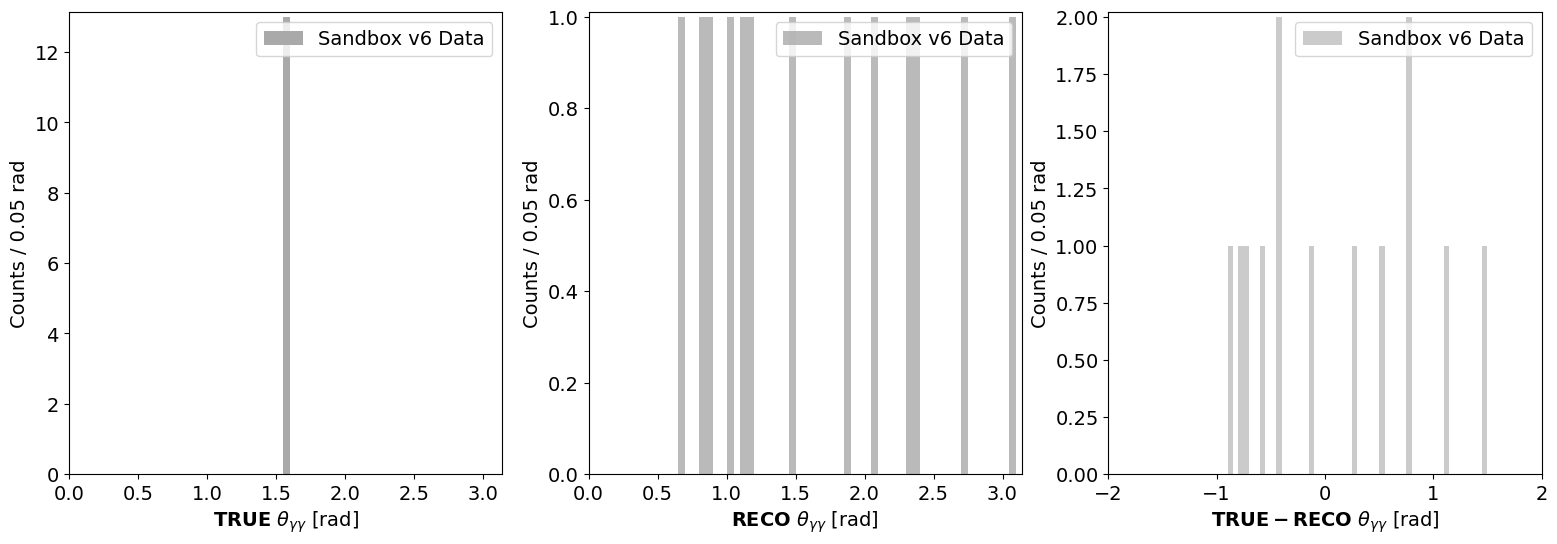

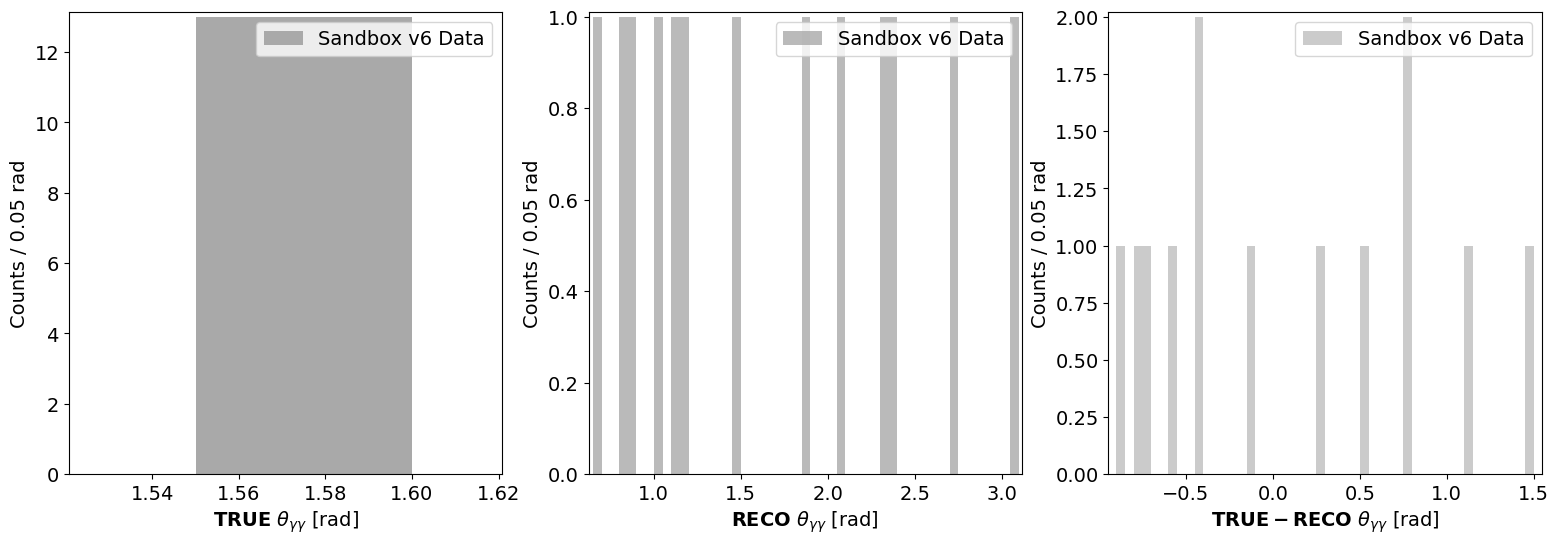

In [9]:
# Make shower angle plots
def make_sig_bkg_shower_angle_plots(list_of_dfs, list_of_labels, list_of_colors, full_range=False):

    var_name = r'$\theta_{\gamma\gamma}$'
    true_var_label = 'true_match_shower_angle'
    reco_var_label = 'reco_shower_angle'
    gen_bins = np.linspace(-3.15, 3.15, 127)
    diff_bins = np.linspace(-6.3, 6.3, 253)
    units = 'rad'
    xlim_min_default = 0
    xlim_max_default = 3.14
    diff_xlim_min_default = -2
    diff_xlim_max_default = 2

    fig, ax = make_single_var_sig_bkg_plots(list_of_dfs=list_of_dfs, list_of_labels=list_of_labels, list_of_colors=list_of_colors, var_name=var_name, \
                                  true_var_label = true_var_label, reco_var_label=reco_var_label, gen_bins=gen_bins, diff_bins=diff_bins, units=units, \
                                  xlim_min_default=xlim_min_default, xlim_max_default=xlim_max_default, diff_xlim_min_default=diff_xlim_min_default, \
                                  diff_xlim_max_default=diff_xlim_max_default, full_range=full_range)
    return fig, ax
# Muon angle plots
fig3, ax3 = make_sig_bkg_shower_angle_plots(dataframes, labels, colors, full_range=False)
fig4, ax4 = make_sig_bkg_shower_angle_plots(dataframes, labels, colors, full_range=True)

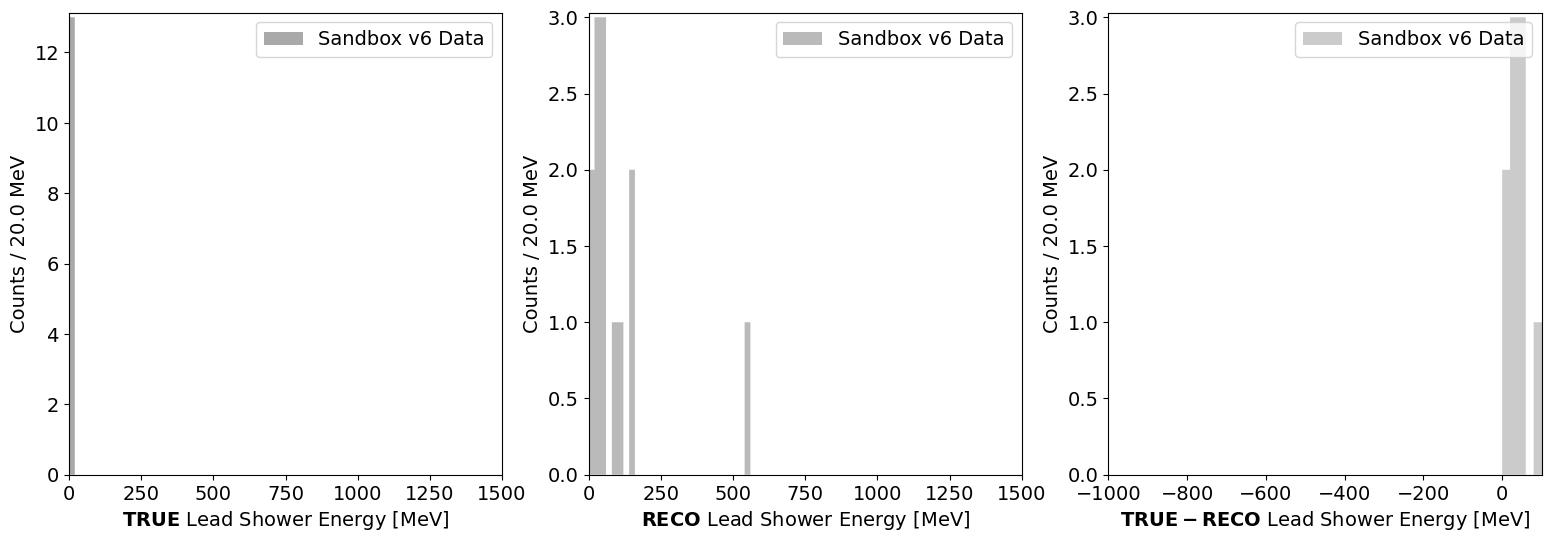

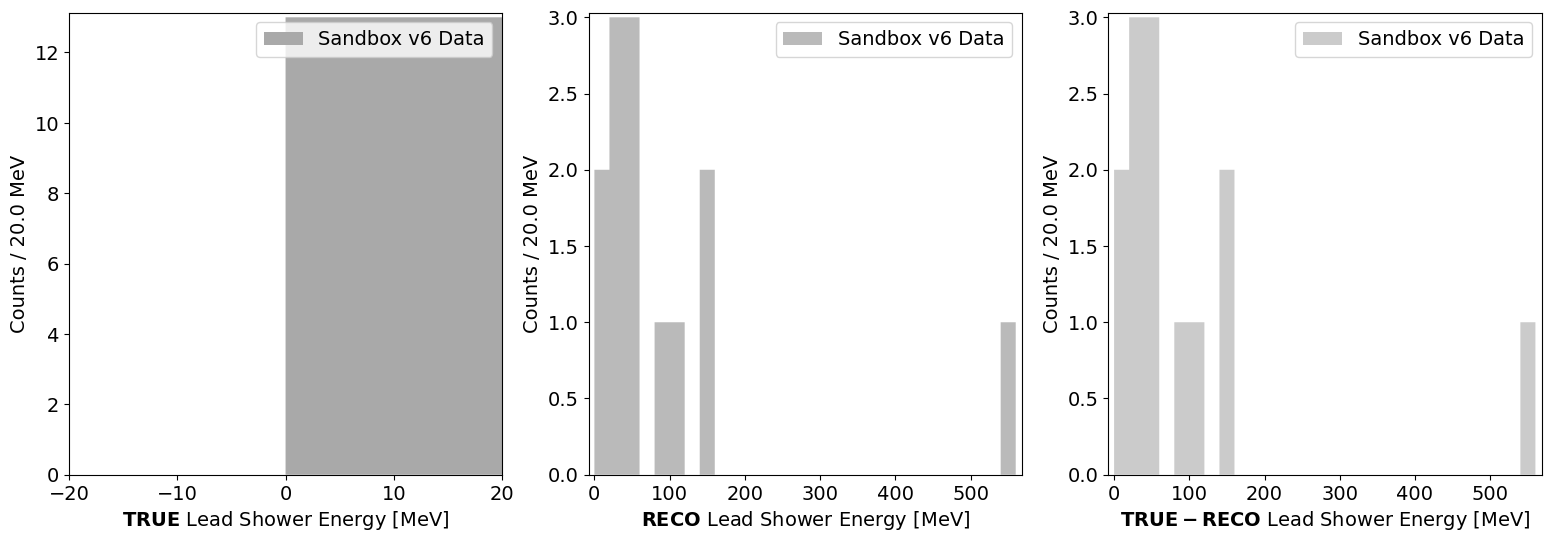

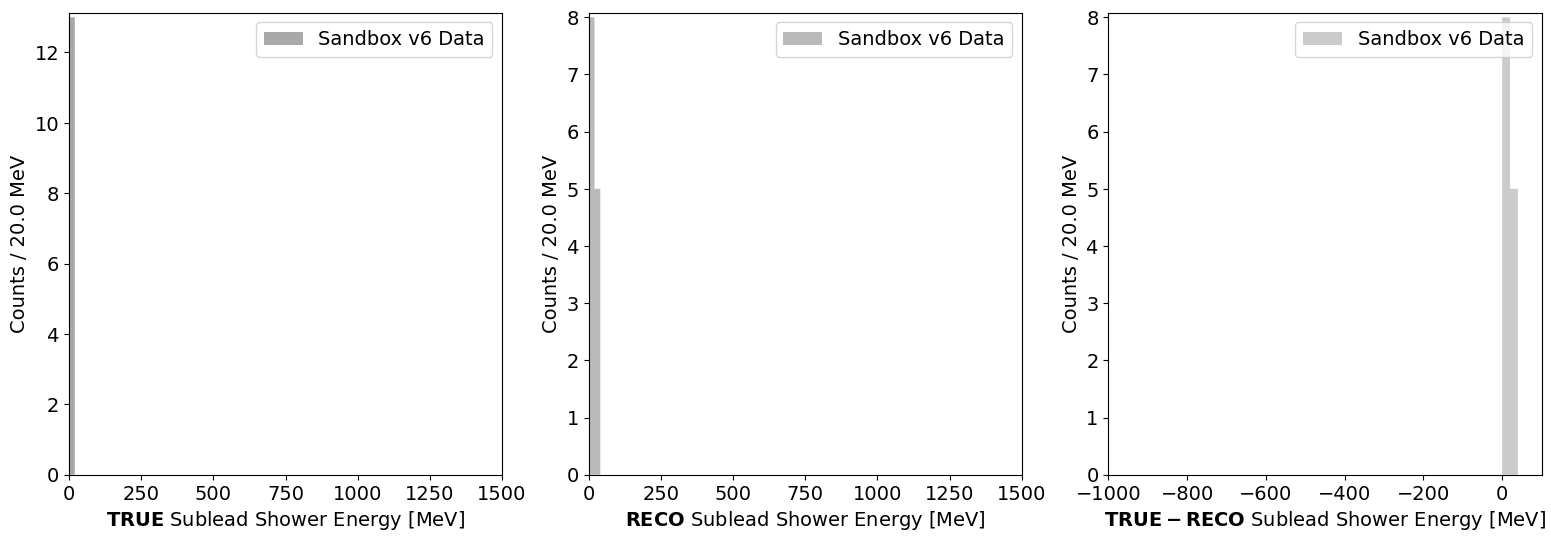

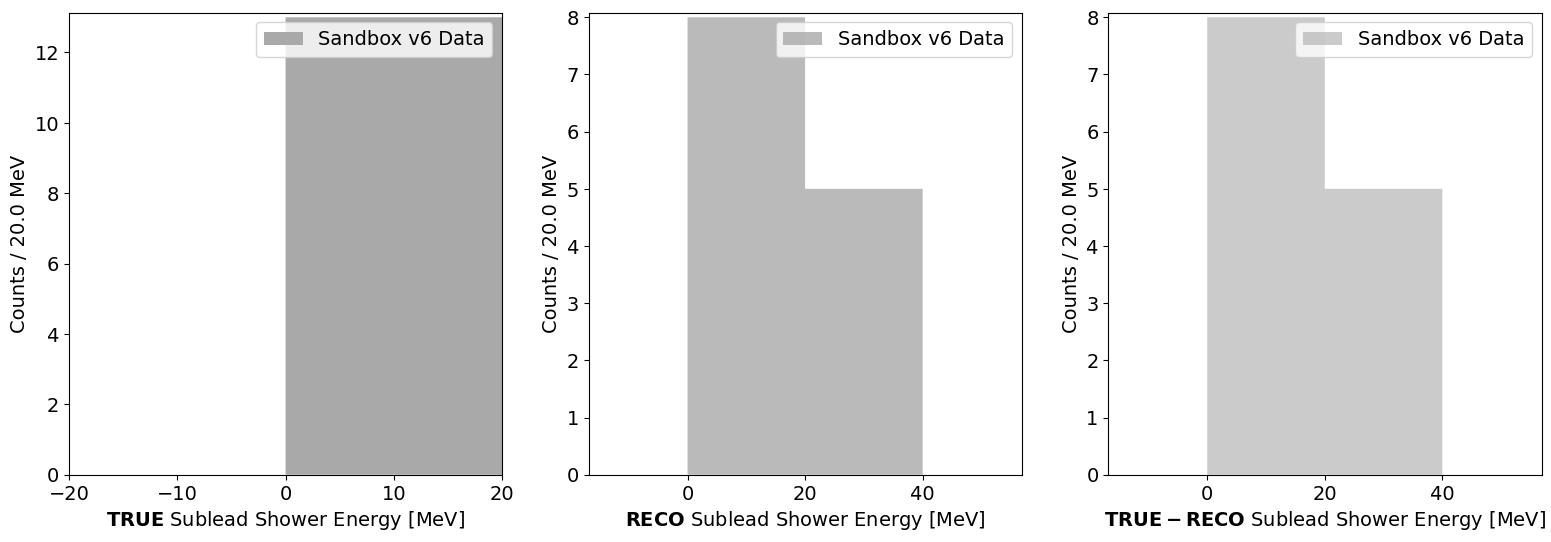

In [10]:
# Make shower energy plots
def make_sig_bkg_lead_shower_energy_plots(list_of_dfs, list_of_labels, list_of_colors, full_range=False):

    var_name = r'Lead Shower Energy'
    true_var_label = 'true_match_lead_shower_energy'
    reco_var_label = 'reco_lead_shower_energy'
    gen_bins = np.linspace(0, 10000, 501)
    diff_bins = np.linspace(-10000, 10000, 1001)
    units = r'MeV'
    xlim_min_default = 0
    xlim_max_default = 1500
    diff_xlim_min_default = -1000
    diff_xlim_max_default = 100

    fig, ax = make_single_var_sig_bkg_plots(list_of_dfs=list_of_dfs, list_of_labels=list_of_labels, list_of_colors=list_of_colors, var_name=var_name, \
                                  true_var_label = true_var_label, reco_var_label=reco_var_label, gen_bins=gen_bins, diff_bins=diff_bins, units=units, \
                                  xlim_min_default=xlim_min_default, xlim_max_default=xlim_max_default, diff_xlim_min_default=diff_xlim_min_default, \
                                  diff_xlim_max_default=diff_xlim_max_default, full_range=full_range)
    return fig, ax
# Muon angle plots
fig5, ax5 = make_sig_bkg_lead_shower_energy_plots(dataframes, labels, colors, full_range=False)
fig6, ax6 = make_sig_bkg_lead_shower_energy_plots(dataframes, labels, colors, full_range=True)

def make_sig_bkg_sublead_shower_energy_plots(list_of_dfs, list_of_labels, list_of_colors, full_range=False):

    var_name = r'Sublead Shower Energy'
    true_var_label = 'true_match_sublead_shower_energy'
    reco_var_label = 'reco_sublead_shower_energy'
    gen_bins = np.linspace(0, 10000, 501)
    diff_bins = np.linspace(-10000, 10000, 1001)
    units = r'MeV'
    xlim_min_default = 0
    xlim_max_default = 1500
    diff_xlim_min_default = -1000
    diff_xlim_max_default = 100

    fig, ax = make_single_var_sig_bkg_plots(list_of_dfs=list_of_dfs, list_of_labels=list_of_labels, list_of_colors=list_of_colors, var_name=var_name, \
                                  true_var_label = true_var_label, reco_var_label=reco_var_label, gen_bins=gen_bins, diff_bins=diff_bins, units=units, \
                                  xlim_min_default=xlim_min_default, xlim_max_default=xlim_max_default, diff_xlim_min_default=diff_xlim_min_default, \
                                  diff_xlim_max_default=diff_xlim_max_default, full_range=full_range)
    return fig, ax
# Muon angle plots
fig7, ax7 = make_sig_bkg_sublead_shower_energy_plots(dataframes, labels, colors, full_range=False)
fig8, ax8 = make_sig_bkg_sublead_shower_energy_plots(dataframes, labels, colors, full_range=True)

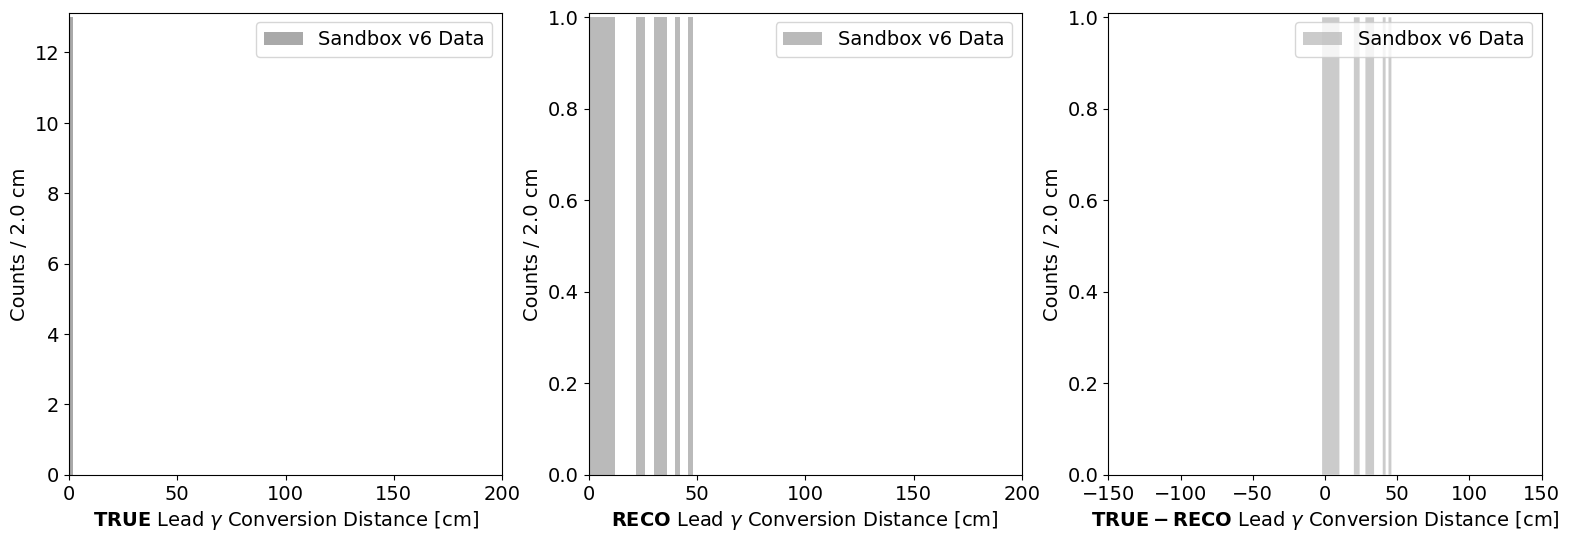

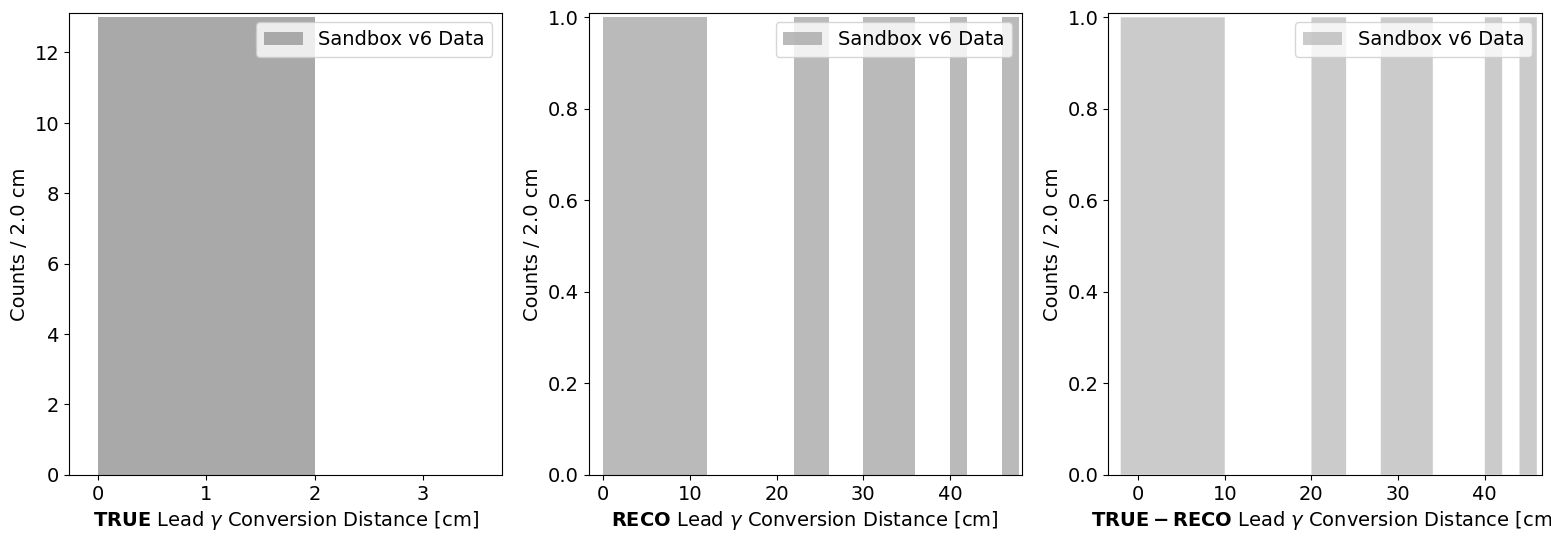

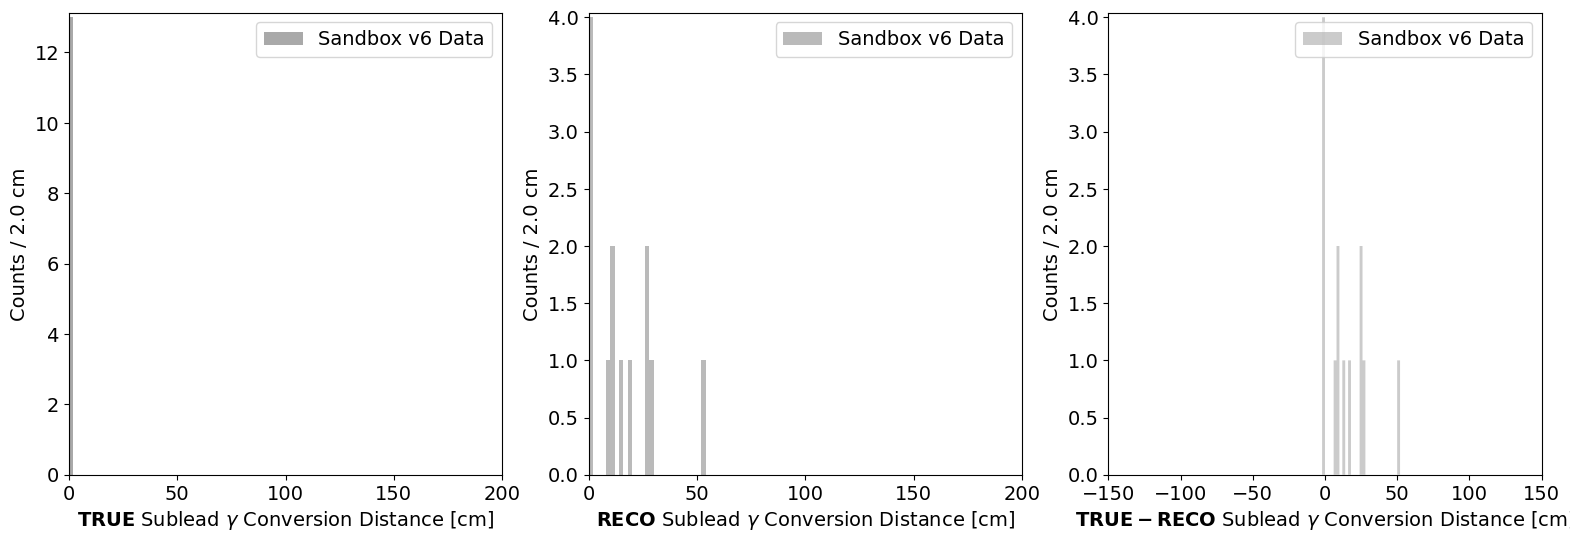

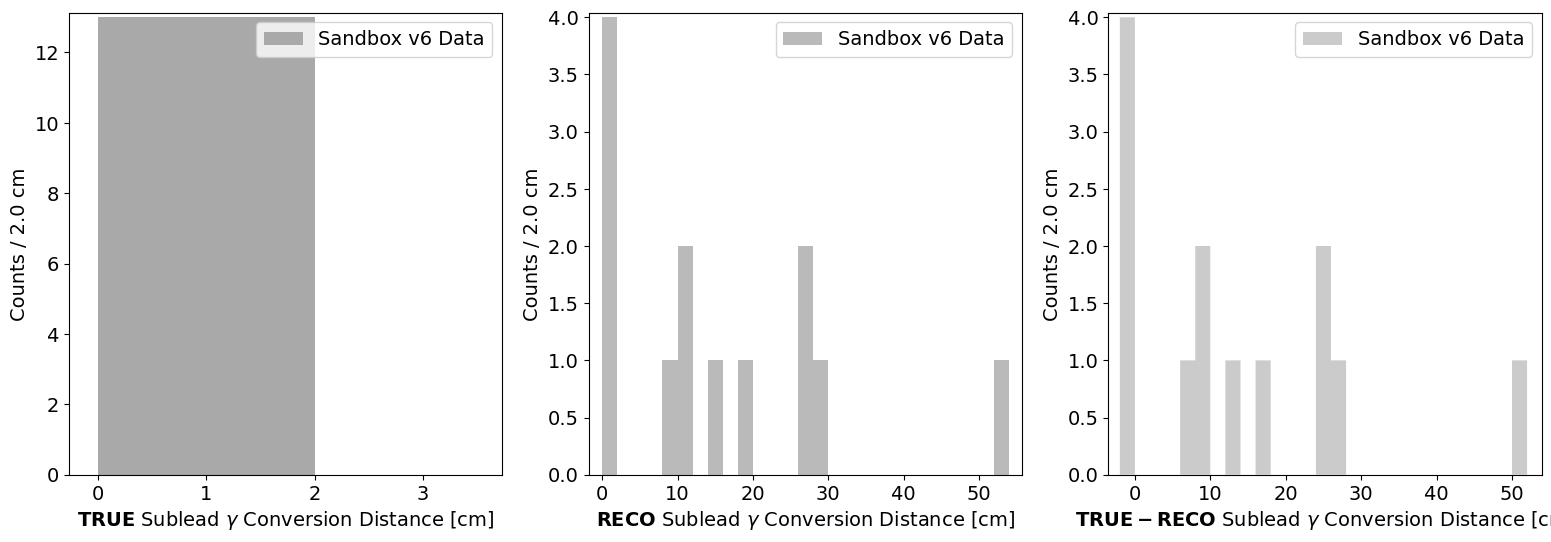

In [11]:
# Make shower conversion distance plots
def make_sig_bkg_lead_shower_conv_dist_plots(list_of_dfs, list_of_labels, list_of_colors, full_range=False, true_var_label='true_match_lead_shower_conversion_distance'):

    var_name = r'Lead $\gamma$ Conversion Distance'
    true_var_label = true_var_label
    reco_var_label = 'reco_lead_shower_conversion_distance'
    gen_bins = np.linspace(0, 500, 251)
    diff_bins = np.linspace(-1000, 1000, 1001)
    units = r'cm'
    xlim_min_default = 0
    xlim_max_default = 200
    diff_xlim_min_default = -150
    diff_xlim_max_default = 150

    fig, ax = make_single_var_sig_bkg_plots(list_of_dfs=list_of_dfs, list_of_labels=list_of_labels, list_of_colors=list_of_colors, var_name=var_name, \
                                  true_var_label = true_var_label, reco_var_label=reco_var_label, gen_bins=gen_bins, diff_bins=diff_bins, units=units, \
                                  xlim_min_default=xlim_min_default, xlim_max_default=xlim_max_default, diff_xlim_min_default=diff_xlim_min_default, \
                                  diff_xlim_max_default=diff_xlim_max_default, full_range=full_range)
    return fig, ax
# Muon angle plots
fig15, ax15 = make_sig_bkg_lead_shower_conv_dist_plots(dataframes, labels, colors, full_range=False)
fig16, ax16 = make_sig_bkg_lead_shower_conv_dist_plots(dataframes, labels, colors, full_range=True)

def make_sig_bkg_sublead_shower_conv_dist_plots(list_of_dfs, list_of_labels, list_of_colors, full_range=False, true_var_label='true_match_sublead_shower_conversion_distance'):

    var_name = r'Sublead $\gamma$ Conversion Distance'
    true_var_label = true_var_label
    reco_var_label = 'reco_sublead_shower_conversion_distance'
    gen_bins = np.linspace(0, 500, 251)
    diff_bins = np.linspace(-1000, 1000, 1001)
    units = r'cm'
    xlim_min_default = 0
    xlim_max_default = 200
    diff_xlim_min_default = -150
    diff_xlim_max_default = 150

    fig, ax = make_single_var_sig_bkg_plots(list_of_dfs=list_of_dfs, list_of_labels=list_of_labels, list_of_colors=list_of_colors, var_name=var_name, \
                                  true_var_label = true_var_label, reco_var_label=reco_var_label, gen_bins=gen_bins, diff_bins=diff_bins, units=units, \
                                  xlim_min_default=xlim_min_default, xlim_max_default=xlim_max_default, diff_xlim_min_default=diff_xlim_min_default, \
                                  diff_xlim_max_default=diff_xlim_max_default, full_range=full_range)
    return fig, ax
# Muon angle plots
fig17, ax17 = make_sig_bkg_sublead_shower_conv_dist_plots(dataframes, labels, colors, full_range=False)
fig18, ax18 = make_sig_bkg_sublead_shower_conv_dist_plots(dataframes, labels, colors, full_range=True)


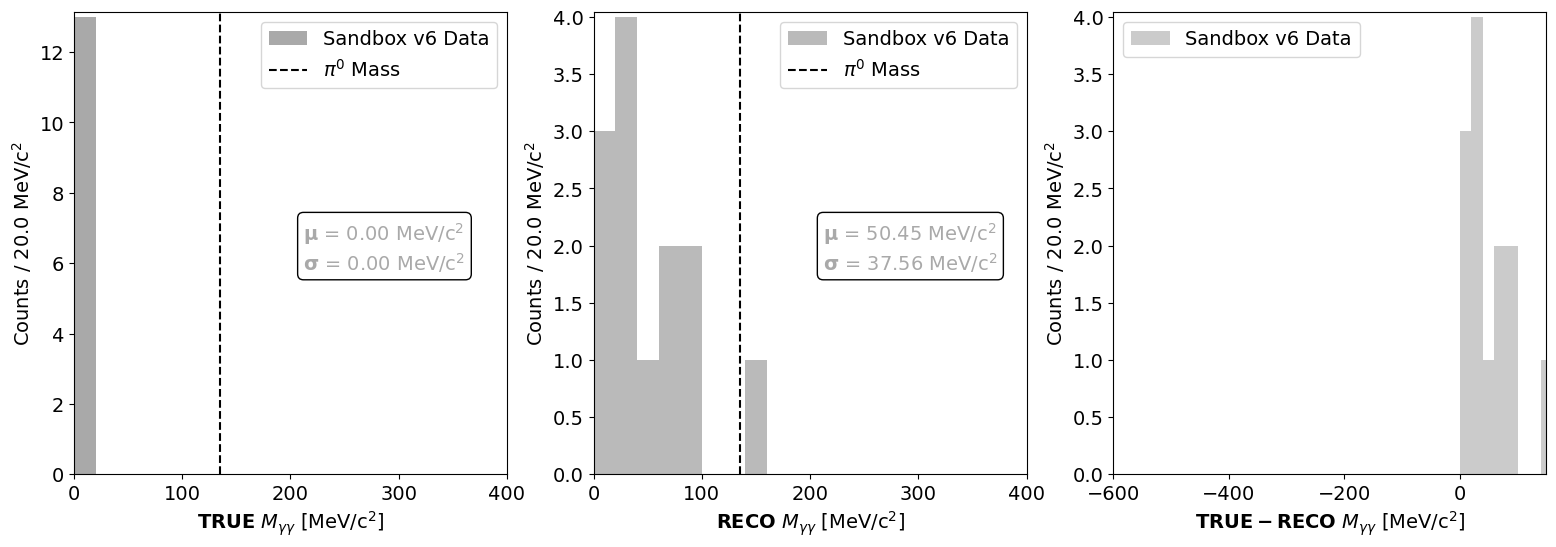

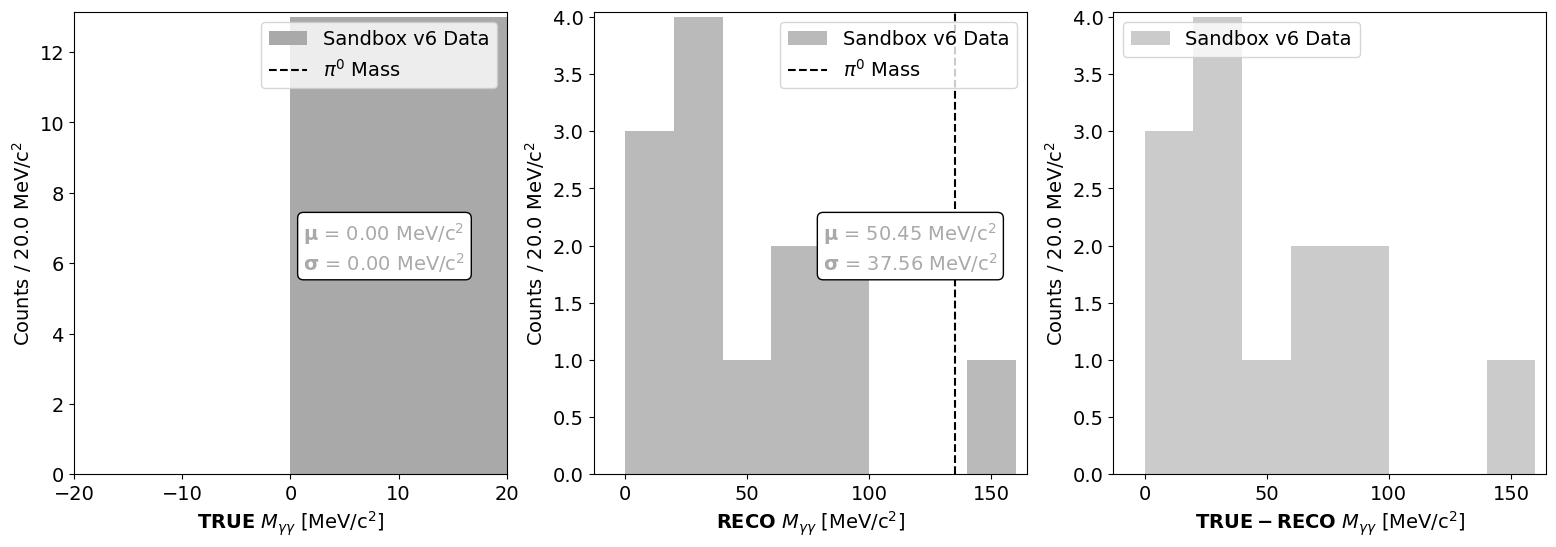

In [12]:
# Plot mass peaks 

def make_sig_bkg_mass_peak_plots(list_of_dfs, list_of_labels, list_of_colors, full_range=False):

    var_name = r'$M_{\gamma\gamma}$'
    true_var_label = 'true_match_diphoton_invariant_mass'
    reco_var_label = 'reco_diphoton_invariant_mass'
    gen_bins = np.linspace(0,1000, 51)
    diff_bins = np.linspace(-1000, 1000, 101)
    units = r'MeV/c$^2$'
    xlim_min_default = 0
    xlim_max_default = 400
    diff_xlim_min_default = -600
    diff_xlim_max_default = 150

    fig, ax = make_single_var_sig_bkg_plots(list_of_dfs=list_of_dfs, list_of_labels=list_of_labels, list_of_colors=list_of_colors, var_name=var_name, \
                                  true_var_label = true_var_label, reco_var_label=reco_var_label, gen_bins=gen_bins, diff_bins=diff_bins, units=units, \
                                  xlim_min_default=xlim_min_default, xlim_max_default=xlim_max_default, diff_xlim_min_default=diff_xlim_min_default, \
                                  diff_xlim_max_default=diff_xlim_max_default, full_range=full_range)

    # Add a vertical line at the mass of the pi0
    pi0_mass = 134.9766  # MeV/c^2 -> GEANT4 mass 
    ax[0].axvline(x=pi0_mass, color='black', linestyle='--', label=r'$\pi^0$ Mass')
    ax[1].axvline(x=pi0_mass, color='black', linestyle='--', label=r'$\pi^0$ Mass')
    ax[0].legend(loc='upper right', fontsize=14)
    ax[1].legend(loc='upper right', fontsize=14)
    ax[2].legend(loc='upper left', fontsize=14)

    # Add summary stats
    true_means = [np.mean(df[true_var_label]) for df in list_of_dfs] 
    true_stds = [np.std(df[true_var_label]) for df in list_of_dfs]
    reco_means = [np.mean(df[reco_var_label]) for df in list_of_dfs]
    reco_stds = [np.std(df[reco_var_label]) for df in list_of_dfs]

    true_means_text = []
    true_stds_text = []
    true_stats_text = []
    reco_means_text = []
    reco_stds_text = []
    reco_stats_text = []
    for i in range(len(list_of_dfs)):
        true_mean = true_means[i]
        true_std = true_stds[i]
        reco_mean = reco_means[i]
        reco_std = reco_stds[i]

        true_mean_text = r"$\mathbf{\mu}$ = %.2f MeV/c$^2$" % (true_mean) 
        true_std_text = r"$\mathbf{\sigma}$ = %.2f MeV/c$^2$" % (true_std)
        true_means_text.append(true_mean_text)
        true_stds_text.append(true_std_text)
        true_stats_text.append(true_mean_text + '\n' + true_std_text)

        reco_mean_text = r"$\mathbf{\mu}$ = %.2f MeV/c$^2$" % (reco_mean)
        reco_std_text = r"$\mathbf{\sigma}$ = %.2f MeV/c$^2$" % (reco_std)
        reco_means_text.append(reco_mean_text)
        reco_stds_text.append(reco_std_text)
        reco_stats_text.append(reco_mean_text + '\n' + reco_std_text)

    all_true_stats_text = '\n'.join(true_stats_text)
    all_reco_stats_text = '\n'.join(reco_stats_text)
    text_box_style = dict(boxstyle='round', facecolor='white', edgecolor='black')
    ax[0].text(
        0.53, 0.55, all_true_stats_text,
        transform=ax[0].transAxes,
        fontsize=14,
        color='white',
        verticalalignment='top',
        horizontalalignment='left',
        bbox=text_box_style
    )
    ax[1].text(
        0.53, 0.55, all_reco_stats_text,
        transform=ax[1].transAxes,
        fontsize=14,
        color='white',
        verticalalignment='top',
        horizontalalignment='left',
        bbox=text_box_style
    )
    for i in range(len(list_of_dfs)):
        ax[0].text(0.53, 0.55-0.12*float(i), true_stats_text[i], transform=ax[0].transAxes, verticalalignment='top', \
            horizontalalignment='left', fontsize=14, color=list_of_colors[i])
        ax[1].text(0.53, 0.55-0.12*float(i), reco_stats_text[i], transform=ax[1].transAxes, verticalalignment='top', \
            horizontalalignment='left', fontsize=14, color=list_of_colors[i])
    

    return fig, ax
# Mass peak plots
fig9, ax9 = make_sig_bkg_mass_peak_plots(dataframes, labels, colors, full_range=False)
fig10, ax10 = make_sig_bkg_mass_peak_plots(dataframes, labels, colors, full_range=True)


/tmp/ipykernel_1324087/2949898201.py:68: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[0,0].set_ylim(0, ylim_max*1.01)
/tmp/ipykernel_1324087/2949898201.py:69: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[0,1].set_ylim(0, ylim_max*1.01)
/tmp/ipykernel_1324087/2949898201.py:70: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[0,2].set_ylim(0, ylim_max*1.01)
/tmp/ipykernel_1324087/2949898201.py:137: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[1,0].set_ylim(0, ylim_max*1.01)
/tmp/ipykernel_1324087/2949898201.py:138: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[1,1].set_ylim(0, ylim_max*1.01)
/tmp/ipykernel_1324087/29498

ValueError: min() arg is an empty sequence

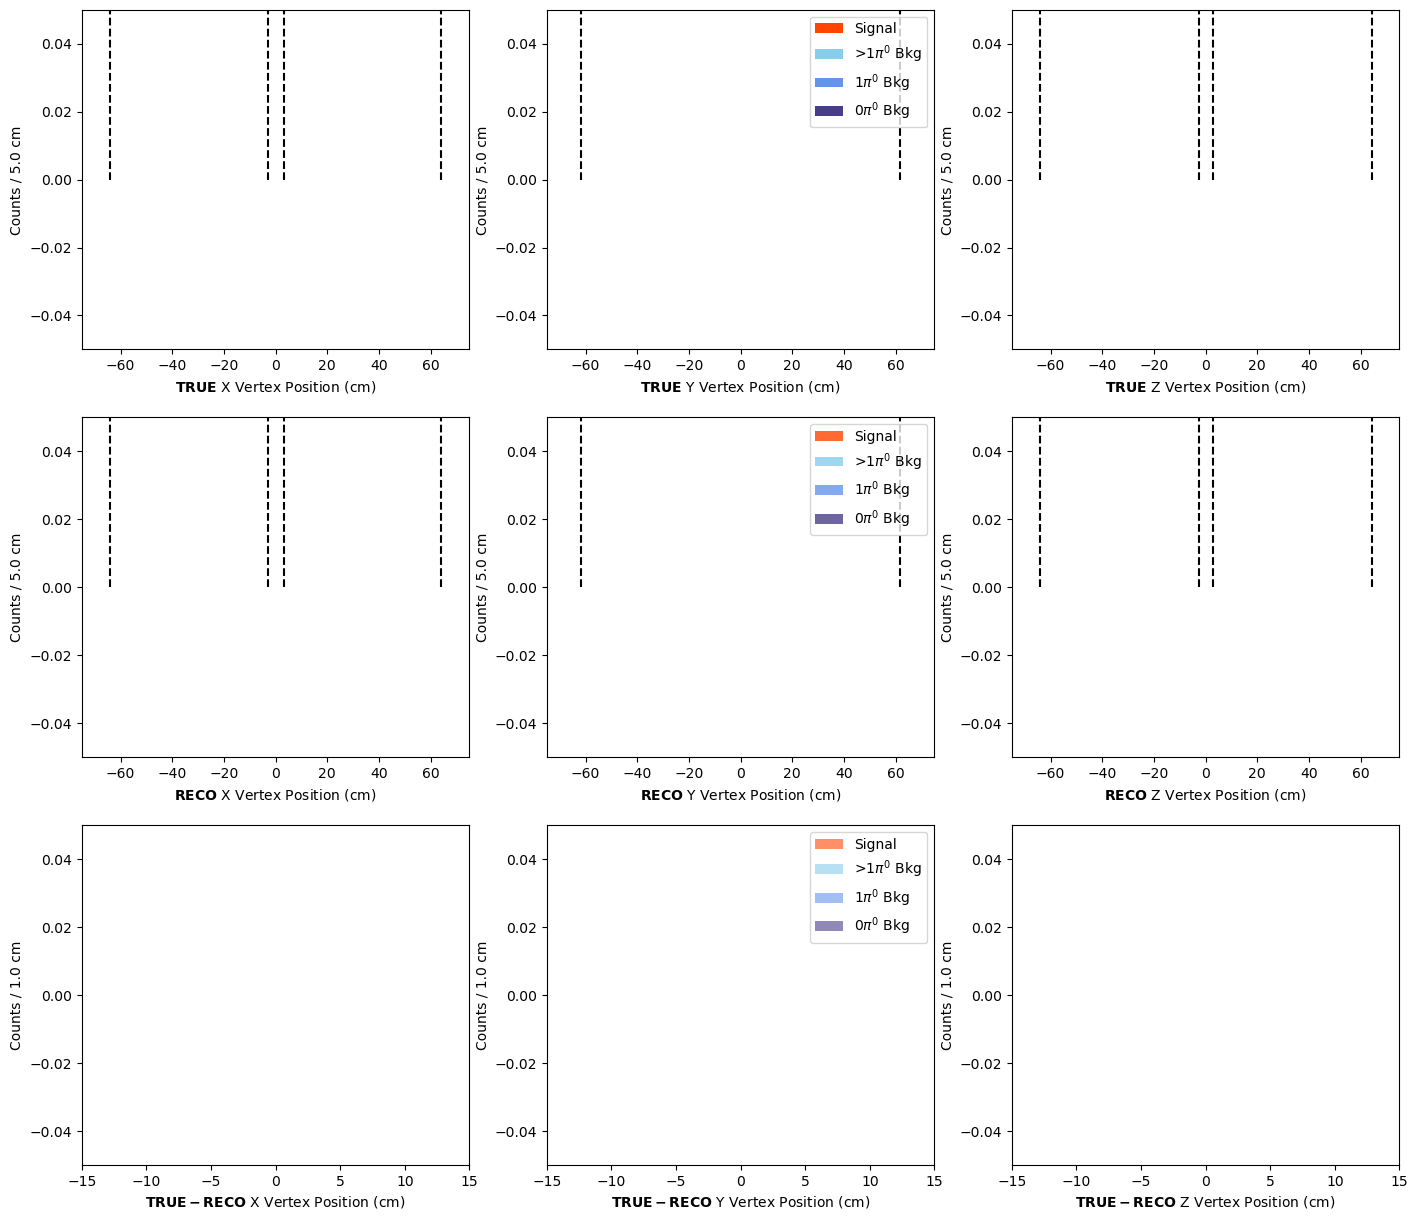

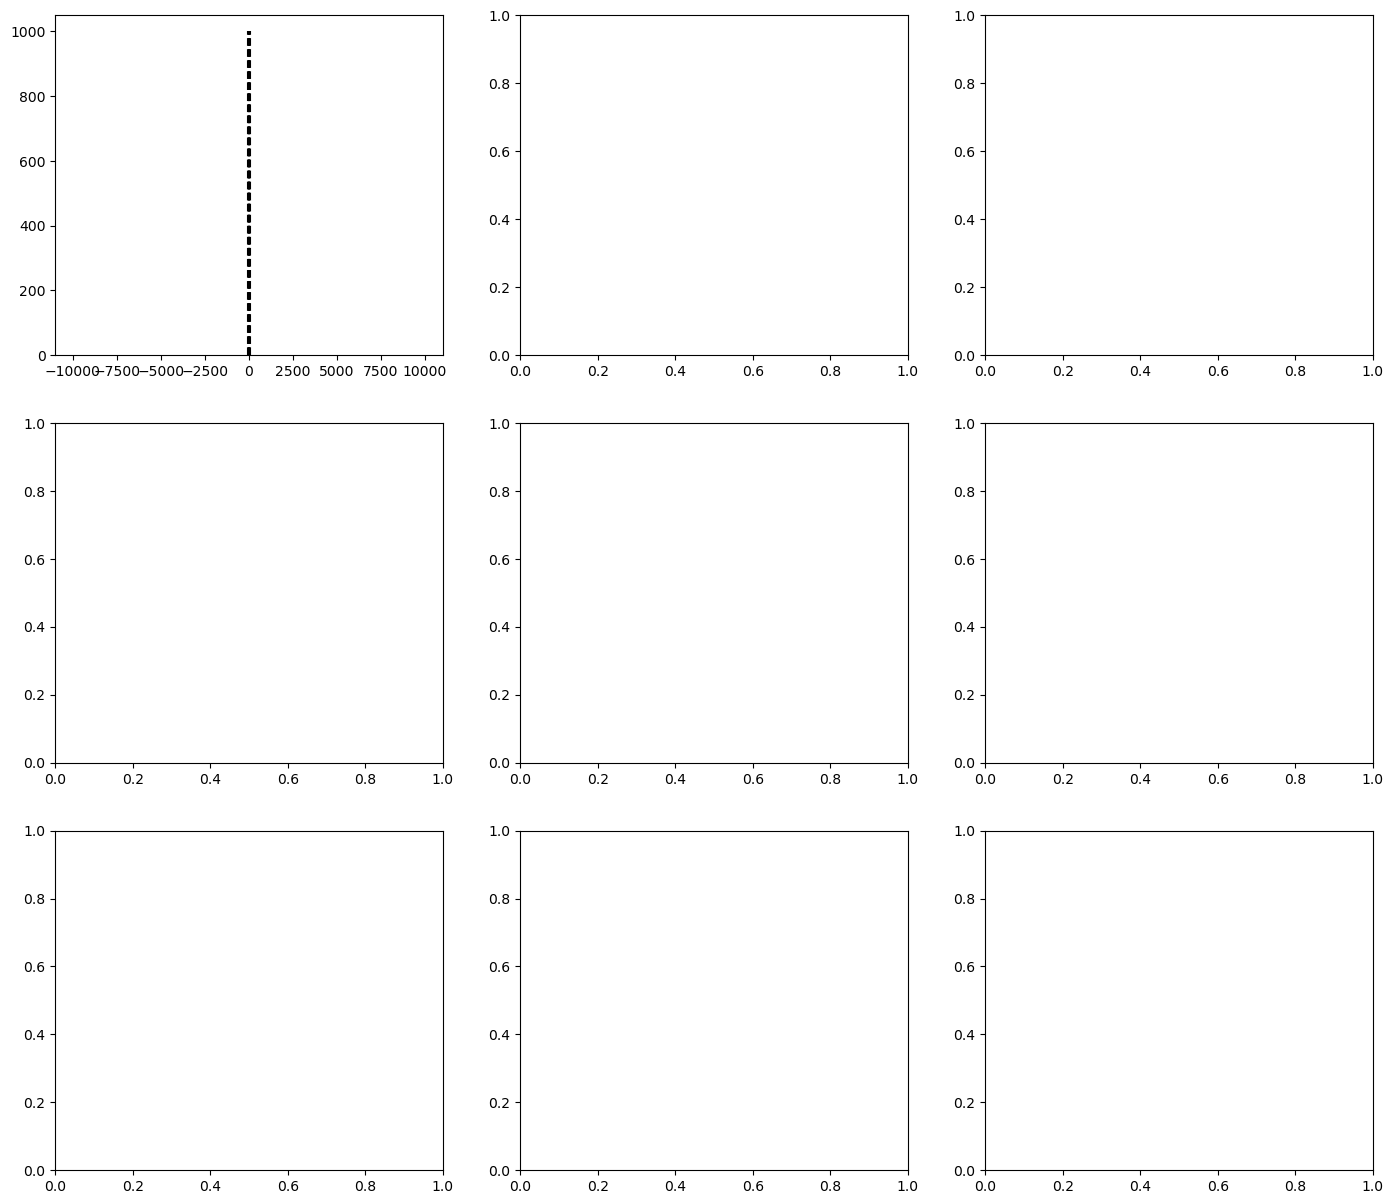

In [13]:
#  VTX POSITION PLOTTING 
def make_sig_bkg_vtx_pos_plots(list_of_dfs, list_of_labels, list_of_colors, full_range=False):

    # TRUE INTERACTION VERTEX POSITION
    # Vertex Cuts -- Look at bkg vertex position xyz
    vtx_position_bins = np.linspace(-10000, 10000, 4001)
    bin_size = abs(vtx_position_bins[1] - vtx_position_bins[0])
    fig, ax = plt.subplots(3,3, figsize=(17, 15))
    list_of_true_ixn_vtx_x_pos_df_cols = [df['true_ixn_vtx_x_pos'] for df in list_of_dfs]
    ax[0,0].hist(list_of_true_ixn_vtx_x_pos_df_cols, bins=vtx_position_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True)
    #ax[0].hist(reco_signal_df['true_ixn_vtx_x_pos'], bins=vtx_position_bins, color=(1,0,0,0.6), histtype='stepfilled', edgecolor=(1,0,0,1), label='Signal', stacked=True)
    ax[0,0].vlines(x=-63.931, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[0,0].vlines(x=-3.069, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[0,0].vlines(x=3.069, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[0,0].vlines(x=63.931, ymin=0, ymax=1000, color='black', linestyle='--')
    if full_range == True:
        min_true_ixn_vtx_x_pos = min([min(x_pos) for x_pos in list_of_true_ixn_vtx_x_pos_df_cols])
        max_true_ixn_vtx_x_pos = max([max(x_pos) for x_pos in list_of_true_ixn_vtx_x_pos_df_cols])
        ax[0,0].set_xlim(min_true_ixn_vtx_x_pos-bin_size, max_true_ixn_vtx_x_pos+bin_size)
    else:
        ax[0,0].set_xlim(-75, 75)

    list_of_true_ixn_vtx_y_pos_df_cols = [df['true_ixn_vtx_y_pos'] for df in list_of_dfs]
    ax[0,1].hist(list_of_true_ixn_vtx_y_pos_df_cols, bins=vtx_position_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True)
    #ax[1].hist(reco_bkg_df['true_ixn_vtx_y_pos'], bins=vtx_position_bins, color=(0,0,1,0.6), histtype='stepfilled', edgecolor=(0,0,1,1), label='Background')
    #ax[1].hist(reco_signal_df['true_ixn_vtx_y_pos'], bins=vtx_position_bins, color=(1,0,0,0.6), histtype='stepfilled', edgecolor=(1,0,0,1), label='Signal')
    ax[0,1].vlines(x=-61.8543, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[0,1].vlines(x=61.8543, ymin=0, ymax=1000, color='black', linestyle='--')
    if full_range == True:
        min_true_ixn_vtx_y_pos = min([min(y_pos) for y_pos in list_of_true_ixn_vtx_y_pos_df_cols])
        max_true_ixn_vtx_y_pos = max([max(y_pos) for y_pos in list_of_true_ixn_vtx_y_pos_df_cols])
        ax[0,1].set_xlim(min_true_ixn_vtx_y_pos-bin_size, max_true_ixn_vtx_y_pos+bin_size)
    else:
        ax[0,1].set_xlim(-75, 75)
    ax[0,1].legend(loc='upper right')

    list_of_true_ixn_vtx_z_pos_df_cols = [df['true_ixn_vtx_z_pos'] for df in list_of_dfs]
    ax[0,2].hist(list_of_true_ixn_vtx_z_pos_df_cols, bins=vtx_position_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True)
    #ax[2].hist(reco_bkg_df['true_ixn_vtx_z_pos'], bins=vtx_position_bins, color=(0,0,1,0.6), histtype='stepfilled', edgecolor=(0,0,1,1), label='Background')
    #ax[2].hist(reco_signal_df['true_ixn_vtx_z_pos'], bins=vtx_position_bins, color=(1,0,0,0.6), histtype='stepfilled', edgecolor=(1,0,0,1), label='Signal')
    ax[0,2].vlines(x=-64.3163, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[0,2].vlines(x=-2.6837, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[0,2].vlines(x=2.6837, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[0,2].vlines(x=64.3163, ymin=0, ymax=1000, color='black', linestyle='--')
    if full_range == True:
        min_true_ixn_vtx_z_pos = min([min(z_pos) for z_pos in list_of_true_ixn_vtx_z_pos_df_cols])
        max_true_ixn_vtx_z_pos = max([max(z_pos) for z_pos in list_of_true_ixn_vtx_z_pos_df_cols])
        ax[0,2].set_xlim(min_true_ixn_vtx_z_pos-bin_size, max_true_ixn_vtx_z_pos+bin_size)
    else:
        ax[0,2].set_xlim(-75, 75)

    for i in range(len(list_of_dfs)):
        x_data_hist, _ = np.histogram(list_of_true_ixn_vtx_x_pos_df_cols[i], bins=vtx_position_bins)
        y_data_hist, _ = np.histogram(list_of_true_ixn_vtx_y_pos_df_cols[i], bins=vtx_position_bins)
        z_data_hist, _ = np.histogram(list_of_true_ixn_vtx_z_pos_df_cols[i], bins=vtx_position_bins)
        if i == 0:
            stacked_x_data_hist = x_data_hist
            stacked_y_data_hist = y_data_hist
            stacked_z_data_hist = z_data_hist
        else:
            stacked_x_data_hist += x_data_hist
            stacked_y_data_hist += y_data_hist
            stacked_z_data_hist += z_data_hist
    ylim_max = max(np.concatenate((stacked_x_data_hist, stacked_y_data_hist, stacked_z_data_hist)))
    ax[0,0].set_ylim(0, ylim_max*1.01)
    ax[0,1].set_ylim(0, ylim_max*1.01)
    ax[0,2].set_ylim(0, ylim_max*1.01)
    ax[0,0].set_xlabel(r'$\mathbf{TRUE}$ X Vertex Position (cm)')
    ax[0,1].set_xlabel(r'$\mathbf{TRUE}$ Y Vertex Position (cm)')
    ax[0,2].set_xlabel(r'$\mathbf{TRUE}$ Z Vertex Position (cm)')
    ax[0,2].set_ylabel('Counts / '+ str(bin_size) + ' cm')
    ax[0,0].set_ylabel('Counts / '+ str(bin_size) + ' cm')
    ax[0,1].set_ylabel('Counts / '+ str(bin_size) + ' cm')
    
    # RECO IXN VERTEX POSITION
    list_of_reco_ixn_vtx_x_pos_df_cols = [df['reco_ixn_vtx_x_pos'] for df in list_of_dfs]
    ax[1,0].hist(list_of_reco_ixn_vtx_x_pos_df_cols, bins=vtx_position_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True, alpha=0.8)
    ax[1,0].vlines(x=-63.931, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[1,0].vlines(x=-3.069, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[1,0].vlines(x=3.069, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[1,0].vlines(x=63.931, ymin=0, ymax=1000, color='black', linestyle='--')
    if full_range == True:
        min_reco_ixn_vtx_x_pos = min([min(x_pos) for x_pos in list_of_reco_ixn_vtx_x_pos_df_cols])
        max_reco_ixn_vtx_x_pos = max([max(x_pos) for x_pos in list_of_reco_ixn_vtx_x_pos_df_cols])
        ax[1,0].set_xlim(min_reco_ixn_vtx_x_pos-bin_size, max_reco_ixn_vtx_x_pos+bin_size)
    else:
        ax[1,0].set_xlim(-75, 75)

    list_of_reco_ixn_vtx_y_pos_df_cols = [df['reco_ixn_vtx_y_pos'] for df in list_of_dfs]
    ax[1,1].hist(list_of_reco_ixn_vtx_y_pos_df_cols, bins=vtx_position_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True, alpha=0.8)
    #ax[1].hist(reco_bkg_df['true_ixn_vtx_y_pos'], bins=vtx_position_bins, color=(0,0,1,0.6), histtype='stepfilled', edgecolor=(0,0,1,1), label='Background')
    #ax[1].hist(reco_signal_df['true_ixn_vtx_y_pos'], bins=vtx_position_bins, color=(1,0,0,0.6), histtype='stepfilled', edgecolor=(1,0,0,1), label='Signal')
    ax[1,1].vlines(x=-61.8543, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[1,1].vlines(x=61.8543, ymin=0, ymax=1000, color='black', linestyle='--')
    if full_range == True:
        min_reco_ixn_vtx_y_pos = min([min(y_pos) for y_pos in list_of_reco_ixn_vtx_y_pos_df_cols])
        max_reco_ixn_vtx_y_pos = max([max(y_pos) for y_pos in list_of_reco_ixn_vtx_y_pos_df_cols])
        ax[1,1].set_xlim(min_reco_ixn_vtx_y_pos-bin_size, max_reco_ixn_vtx_y_pos+bin_size)
    else:
        ax[1,1].set_xlim(-75, 75)
    ax[1,1].legend(loc='upper right')

    list_of_reco_ixn_vtx_z_pos_df_cols = [df['reco_ixn_vtx_z_pos'] for df in list_of_dfs]
    ax[1,2].hist(list_of_reco_ixn_vtx_z_pos_df_cols, bins=vtx_position_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True, alpha=0.8)
    #ax[2].hist(reco_bkg_df['true_ixn_vtx_z_pos'], bins=vtx_position_bins, color=(0,0,1,0.6), histtype='stepfilled', edgecolor=(0,0,1,1), label='Background')
    #ax[2].hist(reco_signal_df['true_ixn_vtx_z_pos'], bins=vtx_position_bins, color=(1,0,0,0.6), histtype='stepfilled', edgecolor=(1,0,0,1), label='Signal')
    ax[1,2].vlines(x=-64.3163, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[1,2].vlines(x=-2.6837, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[1,2].vlines(x=2.6837, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[1,2].vlines(x=64.3163, ymin=0, ymax=1000, color='black', linestyle='--')
    if full_range == True:
        min_reco_ixn_vtx_z_pos = min([min(z_pos) for z_pos in list_of_reco_ixn_vtx_z_pos_df_cols])
        max_reco_ixn_vtx_z_pos = max([max(z_pos) for z_pos in list_of_reco_ixn_vtx_z_pos_df_cols])
        ax[1,2].set_xlim(min_reco_ixn_vtx_z_pos-bin_size, max_reco_ixn_vtx_z_pos+bin_size)
    else:
        ax[1,2].set_xlim(-75, 75)

    for i in range(len(list_of_dfs)):
        x_data_hist, _ = np.histogram(list_of_reco_ixn_vtx_x_pos_df_cols[i], bins=vtx_position_bins)
        y_data_hist, _ = np.histogram(list_of_reco_ixn_vtx_y_pos_df_cols[i], bins=vtx_position_bins)
        z_data_hist, _ = np.histogram(list_of_reco_ixn_vtx_z_pos_df_cols[i], bins=vtx_position_bins)
        if i == 0:
            stacked_x_data_hist = x_data_hist
            stacked_y_data_hist = y_data_hist
            stacked_z_data_hist = z_data_hist
        else:
            stacked_x_data_hist += x_data_hist
            stacked_y_data_hist += y_data_hist
            stacked_z_data_hist += z_data_hist
    ylim_max = max(np.concatenate((stacked_x_data_hist, stacked_y_data_hist, stacked_z_data_hist)))
    ax[1,0].set_ylim(0, ylim_max*1.01)
    ax[1,1].set_ylim(0, ylim_max*1.01)
    ax[1,2].set_ylim(0, ylim_max*1.01)
    ax[1,0].set_xlabel(r'$\mathbf{RECO}$ X Vertex Position (cm)')
    ax[1,1].set_xlabel(r'$\mathbf{RECO}$ Y Vertex Position (cm)')
    ax[1,2].set_xlabel(r'$\mathbf{RECO}$ Z Vertex Position (cm)')
    ax[1,2].set_ylabel('Counts / '+ str(bin_size) + ' cm')
    ax[1,0].set_ylabel('Counts / '+ str(bin_size) + ' cm')
    ax[1,1].set_ylabel('Counts / '+ str(bin_size) + ' cm')

    # TRUE - RECO IXN VERTEX POSITION
    diff_bins = np.linspace(-10000, 2000, 12001)
    diff_bin_size = abs(diff_bins[1] - diff_bins[0])
    list_of_true_reco_diff_ixn_vtx_x_pos_df_cols = [df['true_ixn_vtx_x_pos']-df['reco_ixn_vtx_x_pos'] for df in list_of_dfs]
    ax[2,0].hist(list_of_true_reco_diff_ixn_vtx_x_pos_df_cols, bins=diff_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True, alpha=0.6)
    if full_range == True:
        min_true_reco_diff_ixn_vtx_x_pos = min([min(x_pos) for x_pos in list_of_true_reco_diff_ixn_vtx_x_pos_df_cols])
        max_true_reco_diff_ixn_vtx_x_pos = max([max(x_pos) for x_pos in list_of_true_reco_diff_ixn_vtx_x_pos_df_cols])
        ax[2,0].set_xlim(min_true_reco_diff_ixn_vtx_x_pos-diff_bin_size, max_true_reco_diff_ixn_vtx_x_pos+diff_bin_size)
    else:
        ax[2,0].set_xlim(-15, 15)

    list_of_true_reco_diff_ixn_vtx_y_pos_df_cols = [df['true_ixn_vtx_y_pos']-df['reco_ixn_vtx_y_pos'] for df in list_of_dfs]
    ax[2,1].hist(list_of_true_reco_diff_ixn_vtx_y_pos_df_cols, bins=diff_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True, alpha=0.6)
    if full_range == True:
        min_true_reco_diff_ixn_vtx_y_pos = min([min(y_pos) for y_pos in list_of_true_reco_diff_ixn_vtx_y_pos_df_cols])
        max_true_reco_diff_ixn_vtx_y_pos = max([max(y_pos) for y_pos in list_of_true_reco_diff_ixn_vtx_y_pos_df_cols])
        ax[2,1].set_xlim(min_true_reco_diff_ixn_vtx_y_pos-diff_bin_size, max_true_reco_diff_ixn_vtx_y_pos+diff_bin_size)
    else:
        ax[2,1].set_xlim(-15, 15)
    ax[2,1].legend(loc='upper right')

    list_of_true_reco_diff_ixn_vtx_z_pos_df_cols = [df['true_ixn_vtx_z_pos']-df['reco_ixn_vtx_z_pos'] for df in list_of_dfs]
    ax[2,2].hist(list_of_true_reco_diff_ixn_vtx_z_pos_df_cols, bins=diff_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True, alpha=0.6)
    if full_range == True:
        min_true_reco_diff_ixn_vtx_z_pos = min([min(z_pos) for z_pos in list_of_true_reco_diff_ixn_vtx_z_pos_df_cols])
        max_true_reco_diff_ixn_vtx_z_pos = max([max(z_pos) for z_pos in list_of_true_reco_diff_ixn_vtx_z_pos_df_cols])
        ax[2,2].set_xlim(min_true_reco_diff_ixn_vtx_z_pos-diff_bin_size, max_true_reco_diff_ixn_vtx_z_pos+diff_bin_size)
    else:
        ax[2,2].set_xlim(-15, 15)

    for i in range(len(list_of_dfs)):
        x_data_hist, _ = np.histogram(list_of_true_reco_diff_ixn_vtx_x_pos_df_cols[i], bins=diff_bins)
        y_data_hist, _ = np.histogram(list_of_true_reco_diff_ixn_vtx_y_pos_df_cols[i], bins=diff_bins)
        z_data_hist, _ = np.histogram(list_of_true_reco_diff_ixn_vtx_z_pos_df_cols[i], bins=diff_bins)
        if i == 0:
            stacked_x_data_hist = x_data_hist
            stacked_y_data_hist = y_data_hist
            stacked_z_data_hist = z_data_hist
        else:
            stacked_x_data_hist += x_data_hist
            stacked_y_data_hist += y_data_hist
            stacked_z_data_hist += z_data_hist
    ylim_max = max(np.concatenate((stacked_x_data_hist, stacked_y_data_hist, stacked_z_data_hist)))
    ax[2,0].set_ylim(0, ylim_max*1.01)
    ax[2,1].set_ylim(0, ylim_max*1.01)
    ax[2,2].set_ylim(0, ylim_max*1.01)
    ax[2,0].set_xlabel(r'$\mathbf{TRUE - RECO}$ X Vertex Position (cm)')
    ax[2,1].set_xlabel(r'$\mathbf{TRUE - RECO}$ Y Vertex Position (cm)')
    ax[2,2].set_xlabel(r'$\mathbf{TRUE - RECO}$ Z Vertex Position (cm)')
    ax[2,2].set_ylabel('Counts / '+ str(diff_bin_size) + ' cm')
    ax[2,0].set_ylabel('Counts / '+ str(diff_bin_size) + ' cm')
    ax[2,1].set_ylabel('Counts / '+ str(diff_bin_size) + ' cm')


#dataframes = [reco_bkg_df, reco_signal_df]
#labels = ['Background', 'Signal']
#colors = ['darkslateblue', 'orangered']
dataframes = [bkg_df_no_pi0, bkg_df_one_pi0, bkg_df_npi0, reco_signal_df]
labels = [r'0$\pi^0$ Bkg', r'1$\pi^0$ Bkg', r'>1$\pi^0$ Bkg', 'Signal']
colors = ['darkslateblue', 'cornflowerblue', 'skyblue', 'orangered']
make_sig_bkg_vtx_pos_plots(dataframes, labels, colors, full_range=False)
make_sig_bkg_vtx_pos_plots(dataframes, labels, colors, full_range=True)

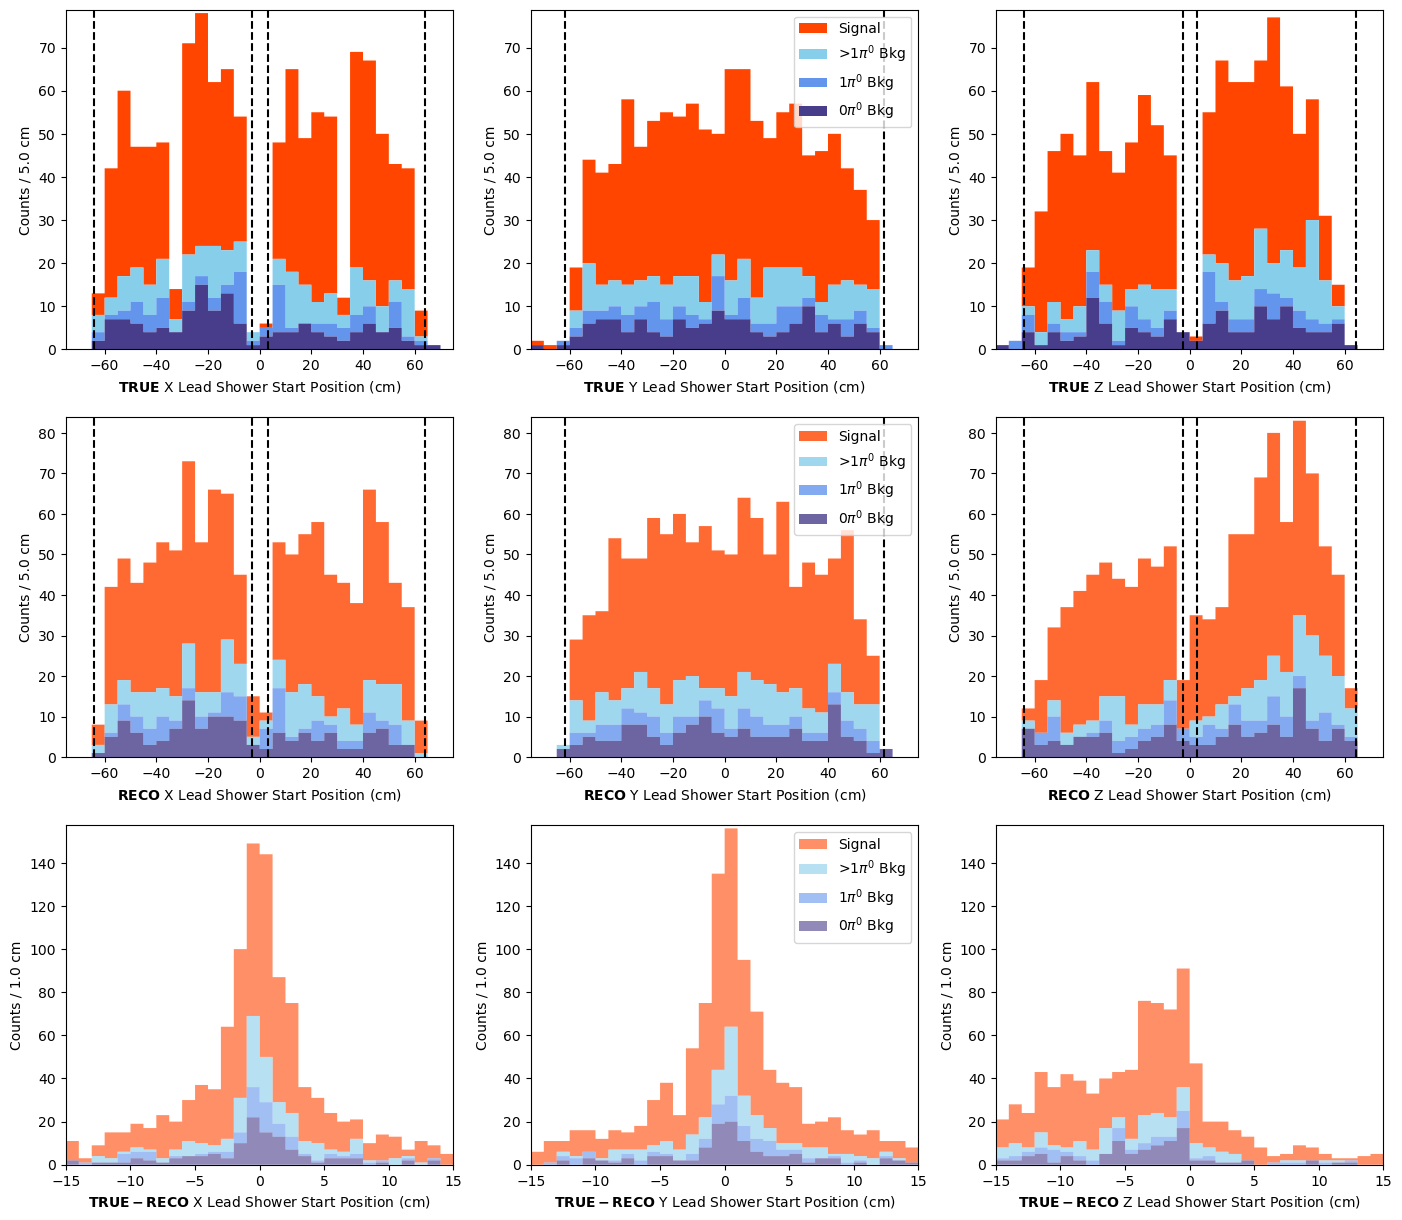

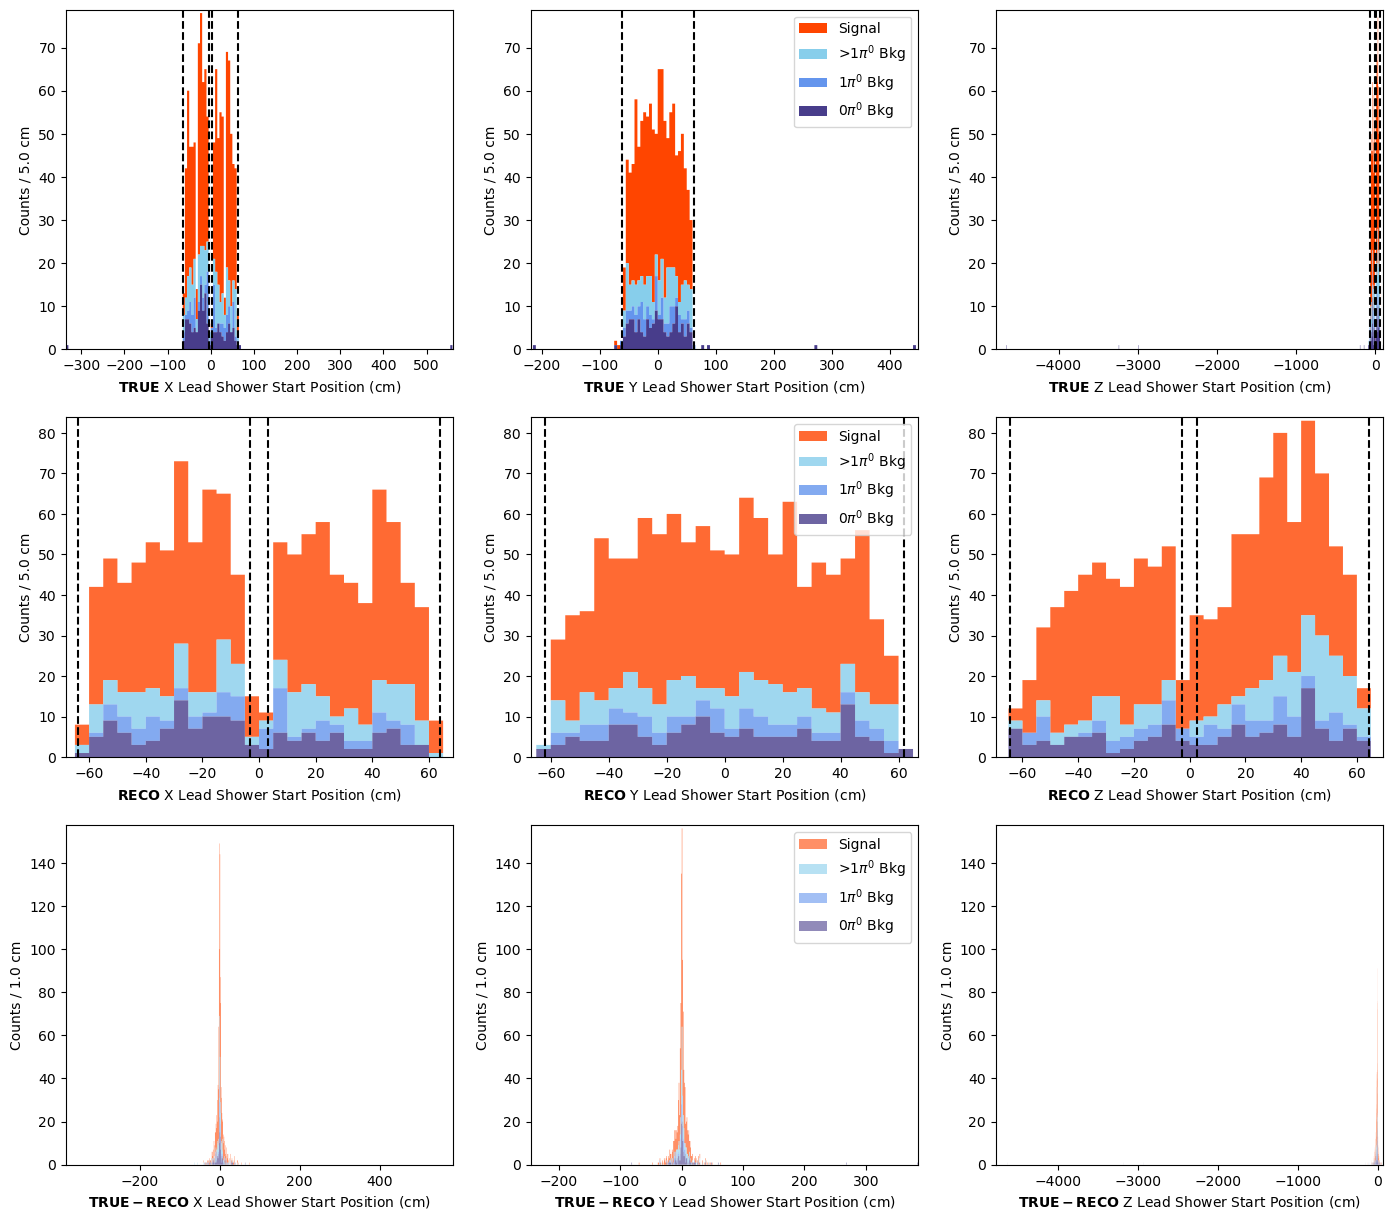

In [ ]:
#  Lead shower start POSITION PLOTTING 
def make_sig_bkg_lead_shower_start_pos_plots(list_of_dfs, list_of_labels, list_of_colors, full_range=False):

    # TRUE INTERACTION Lead shower start POSITION
    # Cuts -- Look at bkg vertex position xyz
    position_bins = np.linspace(-10000, 10000, 4001)
    bin_size = abs(position_bins[1] - position_bins[0])
    fig, ax = plt.subplots(3,3, figsize=(17, 15))
    list_of_true_ixn_x_pos_df_cols = [df['true_match_lead_shower_start_x'] for df in list_of_dfs]
    ax[0,0].hist(list_of_true_ixn_x_pos_df_cols, bins=position_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True)
    #ax[0].hist(reco_signal_df['true_ixn_x_pos'], bins=position_bins, color=(1,0,0,0.6), histtype='stepfilled', edgecolor=(1,0,0,1), label='Signal', stacked=True)
    ax[0,0].vlines(x=-63.931, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[0,0].vlines(x=-3.069, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[0,0].vlines(x=3.069, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[0,0].vlines(x=63.931, ymin=0, ymax=1000, color='black', linestyle='--')
    if full_range == True:
        min_true_ixn_x_pos = min([min(x_pos) for x_pos in list_of_true_ixn_x_pos_df_cols])
        max_true_ixn_x_pos = max([max(x_pos) for x_pos in list_of_true_ixn_x_pos_df_cols])
        ax[0,0].set_xlim(min_true_ixn_x_pos-bin_size, max_true_ixn_x_pos+bin_size)
    else:
        ax[0,0].set_xlim(-75, 75)

    list_of_true_ixn_y_pos_df_cols = [df['true_match_lead_shower_start_y'] for df in list_of_dfs]
    ax[0,1].hist(list_of_true_ixn_y_pos_df_cols, bins=position_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True)
    #ax[1].hist(reco_bkg_df['true_ixn_y_pos'], bins=position_bins, color=(0,0,1,0.6), histtype='stepfilled', edgecolor=(0,0,1,1), label='Background')
    #ax[1].hist(reco_signal_df['true_ixn_y_pos'], bins=position_bins, color=(1,0,0,0.6), histtype='stepfilled', edgecolor=(1,0,0,1), label='Signal')
    ax[0,1].vlines(x=-61.8543, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[0,1].vlines(x=61.8543, ymin=0, ymax=1000, color='black', linestyle='--')
    if full_range == True:
        min_true_ixn_y_pos = min([min(y_pos) for y_pos in list_of_true_ixn_y_pos_df_cols])
        max_true_ixn_y_pos = max([max(y_pos) for y_pos in list_of_true_ixn_y_pos_df_cols])
        ax[0,1].set_xlim(min_true_ixn_y_pos-bin_size, max_true_ixn_y_pos+bin_size)
    else:
        ax[0,1].set_xlim(-75, 75)
    ax[0,1].legend(loc='upper right')

    list_of_true_ixn_z_pos_df_cols = [df['true_match_lead_shower_start_z'] for df in list_of_dfs]
    ax[0,2].hist(list_of_true_ixn_z_pos_df_cols, bins=position_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True)
    #ax[2].hist(reco_bkg_df['true_ixn_z_pos'], bins=position_bins, color=(0,0,1,0.6), histtype='stepfilled', edgecolor=(0,0,1,1), label='Background')
    #ax[2].hist(reco_signal_df['true_ixn_z_pos'], bins=position_bins, color=(1,0,0,0.6), histtype='stepfilled', edgecolor=(1,0,0,1), label='Signal')
    ax[0,2].vlines(x=-64.3163, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[0,2].vlines(x=-2.6837, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[0,2].vlines(x=2.6837, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[0,2].vlines(x=64.3163, ymin=0, ymax=1000, color='black', linestyle='--')
    if full_range == True:
        min_true_ixn_z_pos = min([min(z_pos) for z_pos in list_of_true_ixn_z_pos_df_cols])
        max_true_ixn_z_pos = max([max(z_pos) for z_pos in list_of_true_ixn_z_pos_df_cols])
        ax[0,2].set_xlim(min_true_ixn_z_pos-bin_size, max_true_ixn_z_pos+bin_size)
    else:
        ax[0,2].set_xlim(-75, 75)

    for i in range(len(list_of_dfs)):
        x_data_hist, _ = np.histogram(list_of_true_ixn_x_pos_df_cols[i], bins=position_bins)
        y_data_hist, _ = np.histogram(list_of_true_ixn_y_pos_df_cols[i], bins=position_bins)
        z_data_hist, _ = np.histogram(list_of_true_ixn_z_pos_df_cols[i], bins=position_bins)
        if i == 0:
            stacked_x_data_hist = x_data_hist
            stacked_y_data_hist = y_data_hist
            stacked_z_data_hist = z_data_hist
        else:
            stacked_x_data_hist += x_data_hist
            stacked_y_data_hist += y_data_hist
            stacked_z_data_hist += z_data_hist
    ylim_max = max(np.concatenate((stacked_x_data_hist, stacked_y_data_hist, stacked_z_data_hist)))
    ax[0,0].set_ylim(0, ylim_max*1.01)
    ax[0,1].set_ylim(0, ylim_max*1.01)
    ax[0,2].set_ylim(0, ylim_max*1.01)
    ax[0,0].set_xlabel(r'$\mathbf{TRUE}$ X Lead Shower Start Position (cm)')
    ax[0,1].set_xlabel(r'$\mathbf{TRUE}$ Y Lead Shower Start Position (cm)')
    ax[0,2].set_xlabel(r'$\mathbf{TRUE}$ Z Lead Shower Start Position (cm)')
    ax[0,2].set_ylabel('Counts / '+ str(bin_size) + ' cm')
    ax[0,0].set_ylabel('Counts / '+ str(bin_size) + ' cm')
    ax[0,1].set_ylabel('Counts / '+ str(bin_size) + ' cm')
    
    # RECO IXN VERTEX POSITION
    list_of_reco_ixn_x_pos_df_cols = [df['reco_lead_shower_start_x'] for df in list_of_dfs]
    ax[1,0].hist(list_of_reco_ixn_x_pos_df_cols, bins=position_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True, alpha=0.8)
    ax[1,0].vlines(x=-63.931, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[1,0].vlines(x=-3.069, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[1,0].vlines(x=3.069, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[1,0].vlines(x=63.931, ymin=0, ymax=1000, color='black', linestyle='--')
    if full_range == True:
        min_reco_ixn_x_pos = min([min(x_pos) for x_pos in list_of_reco_ixn_x_pos_df_cols])
        max_reco_ixn_x_pos = max([max(x_pos) for x_pos in list_of_reco_ixn_x_pos_df_cols])
        ax[1,0].set_xlim(min_reco_ixn_x_pos-bin_size, max_reco_ixn_x_pos+bin_size)
    else:
        ax[1,0].set_xlim(-75, 75)

    list_of_reco_ixn_y_pos_df_cols = [df['reco_lead_shower_start_y'] for df in list_of_dfs]
    ax[1,1].hist(list_of_reco_ixn_y_pos_df_cols, bins=position_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True, alpha=0.8)
    #ax[1].hist(reco_bkg_df['true_ixn_y_pos'], bins=position_bins, color=(0,0,1,0.6), histtype='stepfilled', edgecolor=(0,0,1,1), label='Background')
    #ax[1].hist(reco_signal_df['true_ixn_y_pos'], bins=position_bins, color=(1,0,0,0.6), histtype='stepfilled', edgecolor=(1,0,0,1), label='Signal')
    ax[1,1].vlines(x=-61.8543, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[1,1].vlines(x=61.8543, ymin=0, ymax=1000, color='black', linestyle='--')
    if full_range == True:
        min_reco_ixn_y_pos = min([min(y_pos) for y_pos in list_of_reco_ixn_y_pos_df_cols])
        max_reco_ixn_y_pos = max([max(y_pos) for y_pos in list_of_reco_ixn_y_pos_df_cols])
        ax[1,1].set_xlim(min_reco_ixn_y_pos-bin_size, max_reco_ixn_y_pos+bin_size)
    else:
        ax[1,1].set_xlim(-75, 75)
    ax[1,1].legend(loc='upper right')

    list_of_reco_ixn_z_pos_df_cols = [df['reco_lead_shower_start_z'] for df in list_of_dfs]
    ax[1,2].hist(list_of_reco_ixn_z_pos_df_cols, bins=position_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True, alpha=0.8)
    #ax[2].hist(reco_bkg_df['true_ixn_vtx_z_pos'], bins=position_bins, color=(0,0,1,0.6), histtype='stepfilled', edgecolor=(0,0,1,1), label='Background')
    #ax[2].hist(reco_signal_df['true_ixn_vtx_z_pos'], bins=position_bins, color=(1,0,0,0.6), histtype='stepfilled', edgecolor=(1,0,0,1), label='Signal')
    ax[1,2].vlines(x=-64.3163, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[1,2].vlines(x=-2.6837, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[1,2].vlines(x=2.6837, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[1,2].vlines(x=64.3163, ymin=0, ymax=1000, color='black', linestyle='--')
    if full_range == True:
        min_reco_ixn_z_pos = min([min(z_pos) for z_pos in list_of_reco_ixn_z_pos_df_cols])
        max_reco_ixn_z_pos = max([max(z_pos) for z_pos in list_of_reco_ixn_z_pos_df_cols])
        ax[1,2].set_xlim(min_reco_ixn_z_pos-bin_size, max_reco_ixn_z_pos+bin_size)
    else:
        ax[1,2].set_xlim(-75, 75)

    for i in range(len(list_of_dfs)):
        x_data_hist, _ = np.histogram(list_of_reco_ixn_x_pos_df_cols[i], bins=position_bins)
        y_data_hist, _ = np.histogram(list_of_reco_ixn_y_pos_df_cols[i], bins=position_bins)
        z_data_hist, _ = np.histogram(list_of_reco_ixn_z_pos_df_cols[i], bins=position_bins)
        if i == 0:
            stacked_x_data_hist = x_data_hist
            stacked_y_data_hist = y_data_hist
            stacked_z_data_hist = z_data_hist
        else:
            stacked_x_data_hist += x_data_hist
            stacked_y_data_hist += y_data_hist
            stacked_z_data_hist += z_data_hist
    ylim_max = max(np.concatenate((stacked_x_data_hist, stacked_y_data_hist, stacked_z_data_hist)))
    ax[1,0].set_ylim(0, ylim_max*1.01)
    ax[1,1].set_ylim(0, ylim_max*1.01)
    ax[1,2].set_ylim(0, ylim_max*1.01)
    ax[1,0].set_xlabel(r'$\mathbf{RECO}$ X Lead Shower Start Position (cm)')
    ax[1,1].set_xlabel(r'$\mathbf{RECO}$ Y Lead Shower Start Position (cm)')
    ax[1,2].set_xlabel(r'$\mathbf{RECO}$ Z Lead Shower Start Position (cm)')
    ax[1,2].set_ylabel('Counts / '+ str(bin_size) + ' cm')
    ax[1,0].set_ylabel('Counts / '+ str(bin_size) + ' cm')
    ax[1,1].set_ylabel('Counts / '+ str(bin_size) + ' cm')

    # TRUE - RECO IXN VERTEX POSITION
    diff_bins = np.linspace(-10000, 2000, 12001)
    diff_bin_size = abs(diff_bins[1] - diff_bins[0])
    list_of_true_reco_diff_ixn_x_pos_df_cols = [df['true_match_lead_shower_start_x']-df['reco_lead_shower_start_x'] for df in list_of_dfs]
    ax[2,0].hist(list_of_true_reco_diff_ixn_x_pos_df_cols, bins=diff_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True, alpha=0.6)
    if full_range == True:
        min_true_reco_diff_ixn_x_pos = min([min(x_pos) for x_pos in list_of_true_reco_diff_ixn_x_pos_df_cols])
        max_true_reco_diff_ixn_x_pos = max([max(x_pos) for x_pos in list_of_true_reco_diff_ixn_x_pos_df_cols])
        ax[2,0].set_xlim(min_true_reco_diff_ixn_x_pos-diff_bin_size, max_true_reco_diff_ixn_x_pos+diff_bin_size)
    else:
        ax[2,0].set_xlim(-15, 15)

    list_of_true_reco_diff_ixn_y_pos_df_cols = [df['true_match_lead_shower_start_y']-df['reco_lead_shower_start_y'] for df in list_of_dfs]
    ax[2,1].hist(list_of_true_reco_diff_ixn_y_pos_df_cols, bins=diff_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True, alpha=0.6)
    if full_range == True:
        min_true_reco_diff_ixn_y_pos = min([min(y_pos) for y_pos in list_of_true_reco_diff_ixn_y_pos_df_cols])
        max_true_reco_diff_ixn_y_pos = max([max(y_pos) for y_pos in list_of_true_reco_diff_ixn_y_pos_df_cols])
        ax[2,1].set_xlim(min_true_reco_diff_ixn_y_pos-diff_bin_size, max_true_reco_diff_ixn_y_pos+diff_bin_size)
    else:
        ax[2,1].set_xlim(-15, 15)
    ax[2,1].legend(loc='upper right')

    list_of_true_reco_diff_ixn_z_pos_df_cols = [df['true_match_lead_shower_start_z']-df['reco_lead_shower_start_z'] for df in list_of_dfs]
    ax[2,2].hist(list_of_true_reco_diff_ixn_z_pos_df_cols, bins=diff_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True, alpha=0.6)
    if full_range == True:
        min_true_reco_diff_ixn_z_pos = min([min(z_pos) for z_pos in list_of_true_reco_diff_ixn_z_pos_df_cols])
        max_true_reco_diff_ixn_z_pos = max([max(z_pos) for z_pos in list_of_true_reco_diff_ixn_z_pos_df_cols])
        ax[2,2].set_xlim(min_true_reco_diff_ixn_z_pos-diff_bin_size, max_true_reco_diff_ixn_z_pos+diff_bin_size)
    else:
        ax[2,2].set_xlim(-15, 15)

    for i in range(len(list_of_dfs)):
        x_data_hist, _ = np.histogram(list_of_true_reco_diff_ixn_x_pos_df_cols[i], bins=diff_bins)
        y_data_hist, _ = np.histogram(list_of_true_reco_diff_ixn_y_pos_df_cols[i], bins=diff_bins)
        z_data_hist, _ = np.histogram(list_of_true_reco_diff_ixn_z_pos_df_cols[i], bins=diff_bins)
        if i == 0:
            stacked_x_data_hist = x_data_hist
            stacked_y_data_hist = y_data_hist
            stacked_z_data_hist = z_data_hist
        else:
            stacked_x_data_hist += x_data_hist
            stacked_y_data_hist += y_data_hist
            stacked_z_data_hist += z_data_hist
    ylim_max = max(np.concatenate((stacked_x_data_hist, stacked_y_data_hist, stacked_z_data_hist)))
    ax[2,0].set_ylim(0, ylim_max*1.01)
    ax[2,1].set_ylim(0, ylim_max*1.01)
    ax[2,2].set_ylim(0, ylim_max*1.01)
    ax[2,0].set_xlabel(r'$\mathbf{TRUE - RECO}$ X Lead Shower Start Position (cm)')
    ax[2,1].set_xlabel(r'$\mathbf{TRUE - RECO}$ Y Lead Shower Start Position (cm)')
    ax[2,2].set_xlabel(r'$\mathbf{TRUE - RECO}$ Z Lead Shower Start Position (cm)')
    ax[2,2].set_ylabel('Counts / '+ str(diff_bin_size) + ' cm')
    ax[2,0].set_ylabel('Counts / '+ str(diff_bin_size) + ' cm')
    ax[2,1].set_ylabel('Counts / '+ str(diff_bin_size) + ' cm')


#dataframes = [reco_bkg_df, reco_signal_df]
#labels = ['Background', 'Signal']
#colors = ['darkslateblue', 'orangered']
dataframes = [bkg_df_no_pi0, bkg_df_one_pi0, bkg_df_npi0, reco_signal_df]
labels = [r'0$\pi^0$ Bkg', r'1$\pi^0$ Bkg', r'>1$\pi^0$ Bkg', 'Signal']
colors = ['darkslateblue', 'cornflowerblue', 'skyblue', 'orangered']
make_sig_bkg_lead_shower_start_pos_plots(dataframes, labels, colors, full_range=False)
make_sig_bkg_lead_shower_start_pos_plots(dataframes, labels, colors, full_range=True)

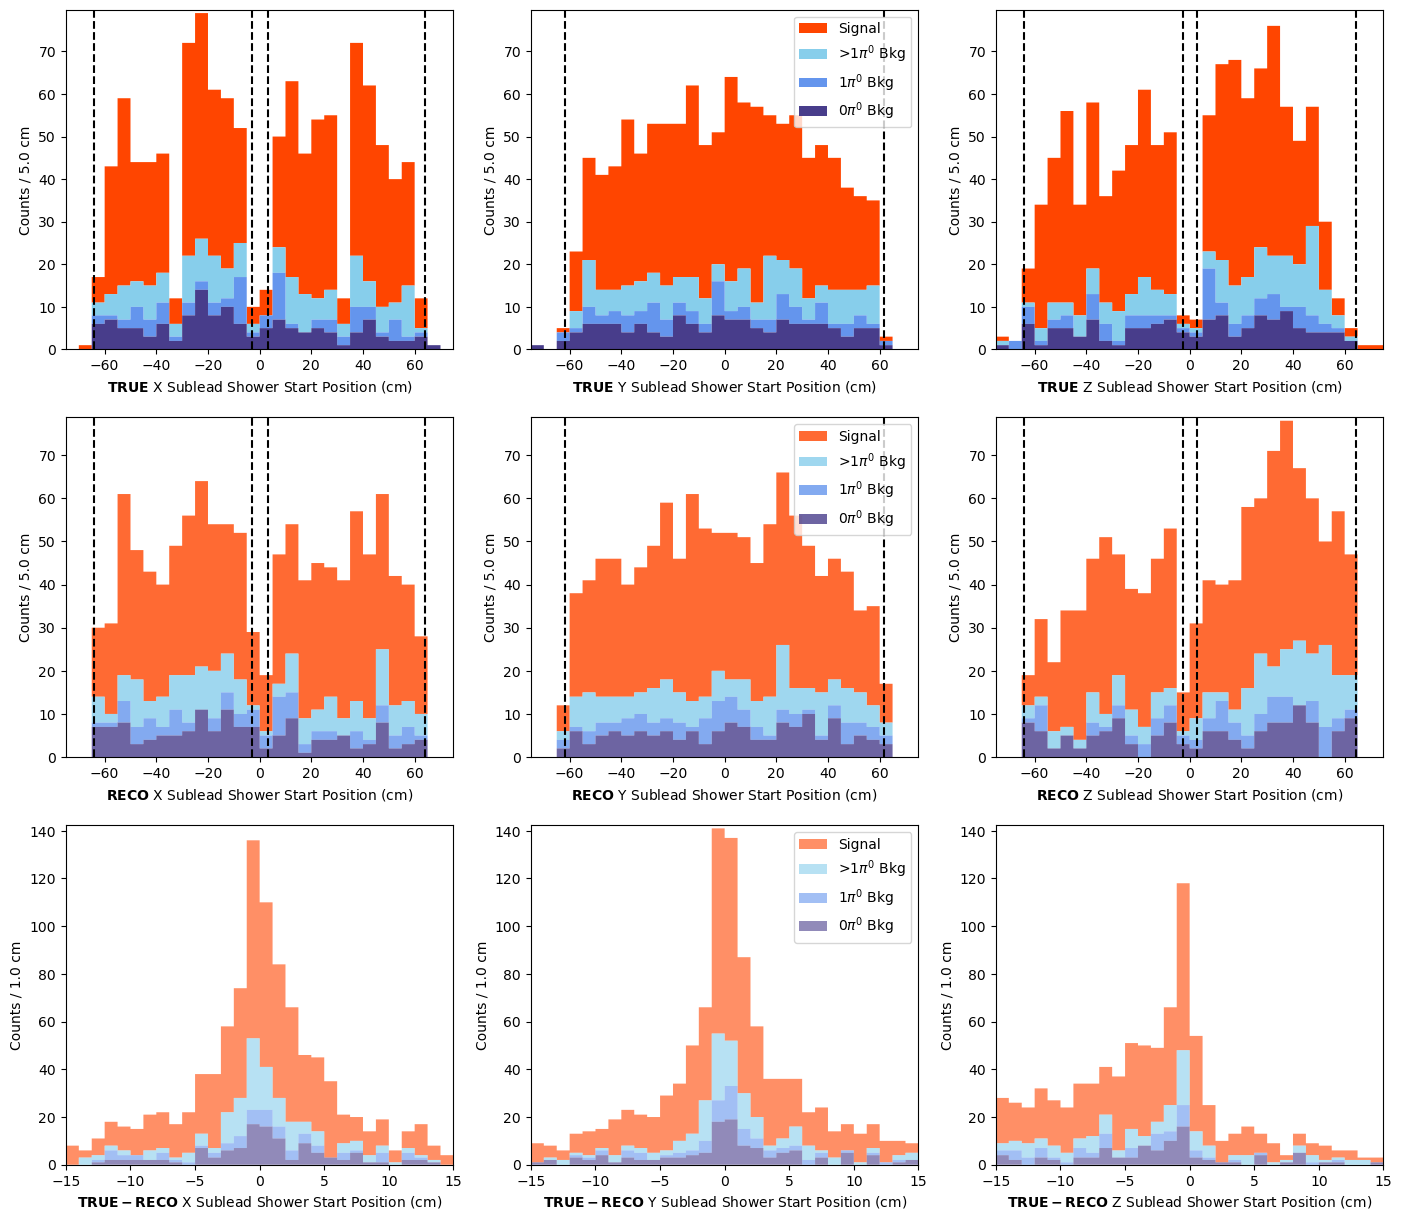

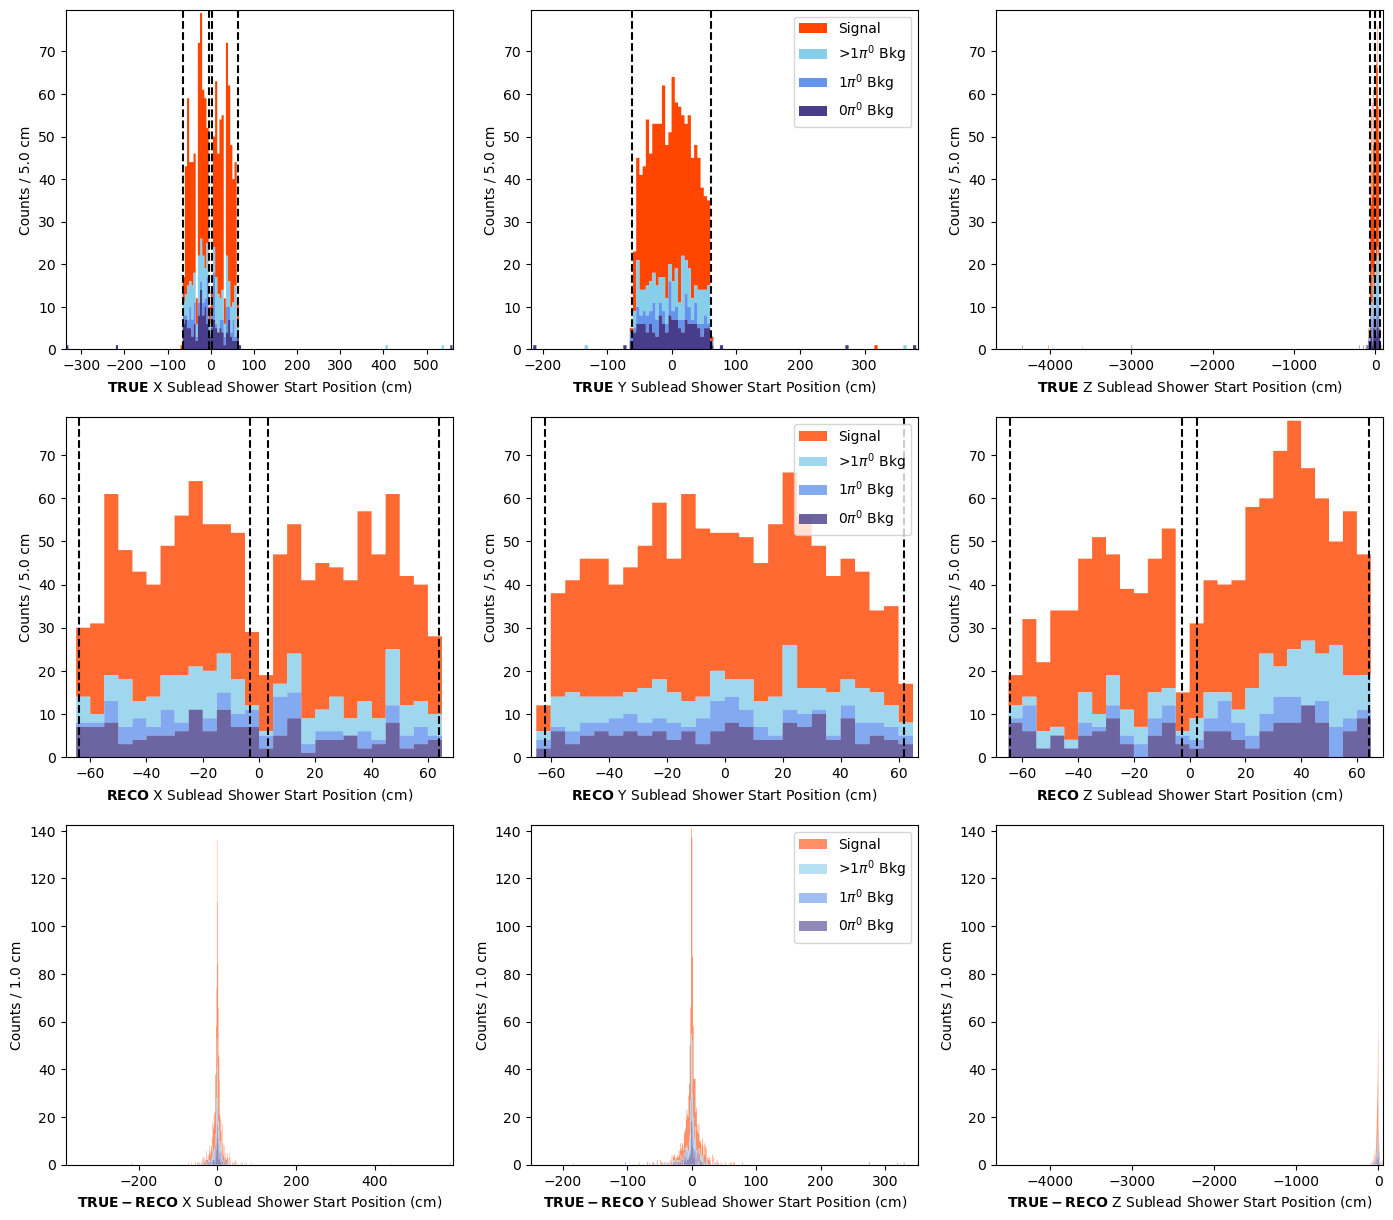

In [ ]:
#  Lead shower start POSITION PLOTTING 
def make_sig_bkg_sublead_shower_start_pos_plots(list_of_dfs, list_of_labels, list_of_colors, full_range=False):

    # TRUE INTERACTION Lead shower start POSITION
    # Cuts -- Look at bkg vertex position xyz
    position_bins = np.linspace(-10000, 10000, 4001)
    bin_size = abs(position_bins[1] - position_bins[0])
    fig, ax = plt.subplots(3,3, figsize=(17, 15))
    list_of_true_ixn_x_pos_df_cols = [df['true_match_sublead_shower_start_x'] for df in list_of_dfs]
    ax[0,0].hist(list_of_true_ixn_x_pos_df_cols, bins=position_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True)
    #ax[0].hist(reco_signal_df['true_ixn_x_pos'], bins=position_bins, color=(1,0,0,0.6), histtype='stepfilled', edgecolor=(1,0,0,1), label='Signal', stacked=True)
    ax[0,0].vlines(x=-63.931, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[0,0].vlines(x=-3.069, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[0,0].vlines(x=3.069, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[0,0].vlines(x=63.931, ymin=0, ymax=1000, color='black', linestyle='--')
    if full_range == True:
        min_true_ixn_x_pos = min([min(x_pos) for x_pos in list_of_true_ixn_x_pos_df_cols])
        max_true_ixn_x_pos = max([max(x_pos) for x_pos in list_of_true_ixn_x_pos_df_cols])
        ax[0,0].set_xlim(min_true_ixn_x_pos-bin_size, max_true_ixn_x_pos+bin_size)
    else:
        ax[0,0].set_xlim(-75, 75)

    list_of_true_ixn_y_pos_df_cols = [df['true_match_sublead_shower_start_y'] for df in list_of_dfs]
    ax[0,1].hist(list_of_true_ixn_y_pos_df_cols, bins=position_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True)
    #ax[1].hist(reco_bkg_df['true_ixn_y_pos'], bins=position_bins, color=(0,0,1,0.6), histtype='stepfilled', edgecolor=(0,0,1,1), label='Background')
    #ax[1].hist(reco_signal_df['true_ixn_y_pos'], bins=position_bins, color=(1,0,0,0.6), histtype='stepfilled', edgecolor=(1,0,0,1), label='Signal')
    ax[0,1].vlines(x=-61.8543, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[0,1].vlines(x=61.8543, ymin=0, ymax=1000, color='black', linestyle='--')
    if full_range == True:
        min_true_ixn_y_pos = min([min(y_pos) for y_pos in list_of_true_ixn_y_pos_df_cols])
        max_true_ixn_y_pos = max([max(y_pos) for y_pos in list_of_true_ixn_y_pos_df_cols])
        ax[0,1].set_xlim(min_true_ixn_y_pos-bin_size, max_true_ixn_y_pos+bin_size)
    else:
        ax[0,1].set_xlim(-75, 75)
    ax[0,1].legend(loc='upper right')

    list_of_true_ixn_z_pos_df_cols = [df['true_match_sublead_shower_start_z'] for df in list_of_dfs]
    ax[0,2].hist(list_of_true_ixn_z_pos_df_cols, bins=position_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True)
    #ax[2].hist(reco_bkg_df['true_ixn_z_pos'], bins=position_bins, color=(0,0,1,0.6), histtype='stepfilled', edgecolor=(0,0,1,1), label='Background')
    #ax[2].hist(reco_signal_df['true_ixn_z_pos'], bins=position_bins, color=(1,0,0,0.6), histtype='stepfilled', edgecolor=(1,0,0,1), label='Signal')
    ax[0,2].vlines(x=-64.3163, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[0,2].vlines(x=-2.6837, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[0,2].vlines(x=2.6837, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[0,2].vlines(x=64.3163, ymin=0, ymax=1000, color='black', linestyle='--')
    if full_range == True:
        min_true_ixn_z_pos = min([min(z_pos) for z_pos in list_of_true_ixn_z_pos_df_cols])
        max_true_ixn_z_pos = max([max(z_pos) for z_pos in list_of_true_ixn_z_pos_df_cols])
        ax[0,2].set_xlim(min_true_ixn_z_pos-bin_size, max_true_ixn_z_pos+bin_size)
    else:
        ax[0,2].set_xlim(-75, 75)

    for i in range(len(list_of_dfs)):
        x_data_hist, _ = np.histogram(list_of_true_ixn_x_pos_df_cols[i], bins=position_bins)
        y_data_hist, _ = np.histogram(list_of_true_ixn_y_pos_df_cols[i], bins=position_bins)
        z_data_hist, _ = np.histogram(list_of_true_ixn_z_pos_df_cols[i], bins=position_bins)
        if i == 0:
            stacked_x_data_hist = x_data_hist
            stacked_y_data_hist = y_data_hist
            stacked_z_data_hist = z_data_hist
        else:
            stacked_x_data_hist += x_data_hist
            stacked_y_data_hist += y_data_hist
            stacked_z_data_hist += z_data_hist
    ylim_max = max(np.concatenate((stacked_x_data_hist, stacked_y_data_hist, stacked_z_data_hist)))
    ax[0,0].set_ylim(0, ylim_max*1.01)
    ax[0,1].set_ylim(0, ylim_max*1.01)
    ax[0,2].set_ylim(0, ylim_max*1.01)
    ax[0,0].set_xlabel(r'$\mathbf{TRUE}$ X Sublead Shower Start Position (cm)')
    ax[0,1].set_xlabel(r'$\mathbf{TRUE}$ Y Sublead Shower Start Position (cm)')
    ax[0,2].set_xlabel(r'$\mathbf{TRUE}$ Z Sublead Shower Start Position (cm)')
    ax[0,2].set_ylabel('Counts / '+ str(bin_size) + ' cm')
    ax[0,0].set_ylabel('Counts / '+ str(bin_size) + ' cm')
    ax[0,1].set_ylabel('Counts / '+ str(bin_size) + ' cm')
    
    # RECO IXN VERTEX POSITION
    list_of_reco_ixn_x_pos_df_cols = [df['reco_sublead_shower_start_x'] for df in list_of_dfs]
    ax[1,0].hist(list_of_reco_ixn_x_pos_df_cols, bins=position_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True, alpha=0.8)
    ax[1,0].vlines(x=-63.931, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[1,0].vlines(x=-3.069, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[1,0].vlines(x=3.069, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[1,0].vlines(x=63.931, ymin=0, ymax=1000, color='black', linestyle='--')
    if full_range == True:
        min_reco_ixn_x_pos = min([min(x_pos) for x_pos in list_of_reco_ixn_x_pos_df_cols])
        max_reco_ixn_x_pos = max([max(x_pos) for x_pos in list_of_reco_ixn_x_pos_df_cols])
        ax[1,0].set_xlim(min_reco_ixn_x_pos-bin_size, max_reco_ixn_x_pos+bin_size)
    else:
        ax[1,0].set_xlim(-75, 75)

    list_of_reco_ixn_y_pos_df_cols = [df['reco_sublead_shower_start_y'] for df in list_of_dfs]
    ax[1,1].hist(list_of_reco_ixn_y_pos_df_cols, bins=position_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True, alpha=0.8)
    #ax[1].hist(reco_bkg_df['true_ixn_y_pos'], bins=position_bins, color=(0,0,1,0.6), histtype='stepfilled', edgecolor=(0,0,1,1), label='Background')
    #ax[1].hist(reco_signal_df['true_ixn_y_pos'], bins=position_bins, color=(1,0,0,0.6), histtype='stepfilled', edgecolor=(1,0,0,1), label='Signal')
    ax[1,1].vlines(x=-61.8543, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[1,1].vlines(x=61.8543, ymin=0, ymax=1000, color='black', linestyle='--')
    if full_range == True:
        min_reco_ixn_y_pos = min([min(y_pos) for y_pos in list_of_reco_ixn_y_pos_df_cols])
        max_reco_ixn_y_pos = max([max(y_pos) for y_pos in list_of_reco_ixn_y_pos_df_cols])
        ax[1,1].set_xlim(min_reco_ixn_y_pos-bin_size, max_reco_ixn_y_pos+bin_size)
    else:
        ax[1,1].set_xlim(-75, 75)
    ax[1,1].legend(loc='upper right')

    list_of_reco_ixn_z_pos_df_cols = [df['reco_sublead_shower_start_z'] for df in list_of_dfs]
    ax[1,2].hist(list_of_reco_ixn_z_pos_df_cols, bins=position_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True, alpha=0.8)
    #ax[2].hist(reco_bkg_df['true_ixn_vtx_z_pos'], bins=position_bins, color=(0,0,1,0.6), histtype='stepfilled', edgecolor=(0,0,1,1), label='Background')
    #ax[2].hist(reco_signal_df['true_ixn_vtx_z_pos'], bins=position_bins, color=(1,0,0,0.6), histtype='stepfilled', edgecolor=(1,0,0,1), label='Signal')
    ax[1,2].vlines(x=-64.3163, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[1,2].vlines(x=-2.6837, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[1,2].vlines(x=2.6837, ymin=0, ymax=1000, color='black', linestyle='--')
    ax[1,2].vlines(x=64.3163, ymin=0, ymax=1000, color='black', linestyle='--')
    if full_range == True:
        min_reco_ixn_z_pos = min([min(z_pos) for z_pos in list_of_reco_ixn_z_pos_df_cols])
        max_reco_ixn_z_pos = max([max(z_pos) for z_pos in list_of_reco_ixn_z_pos_df_cols])
        ax[1,2].set_xlim(min_reco_ixn_z_pos-bin_size, max_reco_ixn_z_pos+bin_size)
    else:
        ax[1,2].set_xlim(-75, 75)

    for i in range(len(list_of_dfs)):
        x_data_hist, _ = np.histogram(list_of_reco_ixn_x_pos_df_cols[i], bins=position_bins)
        y_data_hist, _ = np.histogram(list_of_reco_ixn_y_pos_df_cols[i], bins=position_bins)
        z_data_hist, _ = np.histogram(list_of_reco_ixn_z_pos_df_cols[i], bins=position_bins)
        if i == 0:
            stacked_x_data_hist = x_data_hist
            stacked_y_data_hist = y_data_hist
            stacked_z_data_hist = z_data_hist
        else:
            stacked_x_data_hist += x_data_hist
            stacked_y_data_hist += y_data_hist
            stacked_z_data_hist += z_data_hist
    ylim_max = max(np.concatenate((stacked_x_data_hist, stacked_y_data_hist, stacked_z_data_hist)))
    ax[1,0].set_ylim(0, ylim_max*1.01)
    ax[1,1].set_ylim(0, ylim_max*1.01)
    ax[1,2].set_ylim(0, ylim_max*1.01)
    ax[1,0].set_xlabel(r'$\mathbf{RECO}$ X Sublead Shower Start Position (cm)')
    ax[1,1].set_xlabel(r'$\mathbf{RECO}$ Y Sublead Shower Start Position (cm)')
    ax[1,2].set_xlabel(r'$\mathbf{RECO}$ Z Sublead Shower Start Position (cm)')
    ax[1,2].set_ylabel('Counts / '+ str(bin_size) + ' cm')
    ax[1,0].set_ylabel('Counts / '+ str(bin_size) + ' cm')
    ax[1,1].set_ylabel('Counts / '+ str(bin_size) + ' cm')

    # TRUE - RECO IXN VERTEX POSITION
    diff_bins = np.linspace(-10000, 2000, 12001)
    diff_bin_size = abs(diff_bins[1] - diff_bins[0])
    list_of_true_reco_diff_ixn_x_pos_df_cols = [df['true_match_sublead_shower_start_x']-df['reco_sublead_shower_start_x'] for df in list_of_dfs]
    ax[2,0].hist(list_of_true_reco_diff_ixn_x_pos_df_cols, bins=diff_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True, alpha=0.6)
    if full_range == True:
        min_true_reco_diff_ixn_x_pos = min([min(x_pos) for x_pos in list_of_true_reco_diff_ixn_x_pos_df_cols])
        max_true_reco_diff_ixn_x_pos = max([max(x_pos) for x_pos in list_of_true_reco_diff_ixn_x_pos_df_cols])
        ax[2,0].set_xlim(min_true_reco_diff_ixn_x_pos-diff_bin_size, max_true_reco_diff_ixn_x_pos+diff_bin_size)
    else:
        ax[2,0].set_xlim(-15, 15)

    list_of_true_reco_diff_ixn_y_pos_df_cols = [df['true_match_sublead_shower_start_y']-df['reco_sublead_shower_start_y'] for df in list_of_dfs]
    ax[2,1].hist(list_of_true_reco_diff_ixn_y_pos_df_cols, bins=diff_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True, alpha=0.6)
    if full_range == True:
        min_true_reco_diff_ixn_y_pos = min([min(y_pos) for y_pos in list_of_true_reco_diff_ixn_y_pos_df_cols])
        max_true_reco_diff_ixn_y_pos = max([max(y_pos) for y_pos in list_of_true_reco_diff_ixn_y_pos_df_cols])
        ax[2,1].set_xlim(min_true_reco_diff_ixn_y_pos-diff_bin_size, max_true_reco_diff_ixn_y_pos+diff_bin_size)
    else:
        ax[2,1].set_xlim(-15, 15)
    ax[2,1].legend(loc='upper right')

    list_of_true_reco_diff_ixn_z_pos_df_cols = [df['true_match_sublead_shower_start_z']-df['reco_sublead_shower_start_z'] for df in list_of_dfs]
    ax[2,2].hist(list_of_true_reco_diff_ixn_z_pos_df_cols, bins=diff_bins, color=list_of_colors, \
                histtype='stepfilled', label=list_of_labels, stacked=True, alpha=0.6)
    if full_range == True:
        min_true_reco_diff_ixn_z_pos = min([min(z_pos) for z_pos in list_of_true_reco_diff_ixn_z_pos_df_cols])
        max_true_reco_diff_ixn_z_pos = max([max(z_pos) for z_pos in list_of_true_reco_diff_ixn_z_pos_df_cols])
        ax[2,2].set_xlim(min_true_reco_diff_ixn_z_pos-diff_bin_size, max_true_reco_diff_ixn_z_pos+diff_bin_size)
    else:
        ax[2,2].set_xlim(-15, 15)

    for i in range(len(list_of_dfs)):
        x_data_hist, _ = np.histogram(list_of_true_reco_diff_ixn_x_pos_df_cols[i], bins=diff_bins)
        y_data_hist, _ = np.histogram(list_of_true_reco_diff_ixn_y_pos_df_cols[i], bins=diff_bins)
        z_data_hist, _ = np.histogram(list_of_true_reco_diff_ixn_z_pos_df_cols[i], bins=diff_bins)
        if i == 0:
            stacked_x_data_hist = x_data_hist
            stacked_y_data_hist = y_data_hist
            stacked_z_data_hist = z_data_hist
        else:
            stacked_x_data_hist += x_data_hist
            stacked_y_data_hist += y_data_hist
            stacked_z_data_hist += z_data_hist
    ylim_max = max(np.concatenate((stacked_x_data_hist, stacked_y_data_hist, stacked_z_data_hist)))
    ax[2,0].set_ylim(0, ylim_max*1.01)
    ax[2,1].set_ylim(0, ylim_max*1.01)
    ax[2,2].set_ylim(0, ylim_max*1.01)
    ax[2,0].set_xlabel(r'$\mathbf{TRUE - RECO}$ X Sublead Shower Start Position (cm)')
    ax[2,1].set_xlabel(r'$\mathbf{TRUE - RECO}$ Y Sublead Shower Start Position (cm)')
    ax[2,2].set_xlabel(r'$\mathbf{TRUE - RECO}$ Z Sublead Shower Start Position (cm)')
    ax[2,2].set_ylabel('Counts / '+ str(diff_bin_size) + ' cm')
    ax[2,0].set_ylabel('Counts / '+ str(diff_bin_size) + ' cm')
    ax[2,1].set_ylabel('Counts / '+ str(diff_bin_size) + ' cm')


#dataframes = [reco_bkg_df, reco_signal_df]
#labels = ['Background', 'Signal']
#colors = ['darkslateblue', 'orangered']
dataframes = [bkg_df_no_pi0, bkg_df_one_pi0, bkg_df_npi0, reco_signal_df]
labels = [r'0$\pi^0$ Bkg', r'1$\pi^0$ Bkg', r'>1$\pi^0$ Bkg', 'Signal']
colors = ['darkslateblue', 'cornflowerblue', 'skyblue', 'orangered']
make_sig_bkg_sublead_shower_start_pos_plots(dataframes, labels, colors, full_range=False)
make_sig_bkg_sublead_shower_start_pos_plots(dataframes, labels, colors, full_range=True)

In [ ]:
# Check Differences between edep-sim study and CAF study
truth_df["initial_id"] = truth_df.index

# TPC bounds method
def tpc_bounds(i):
    """A sad little function that returns the bounds of each 2x2 tpc in one dimension.
    The dimension is chosen by i: 0, 1, 2 -> x, y, z.
    Values are taken from 2x2_sim/run-edep-sim/geometry/Merged2x2MINERvA_v2"""
            
    active_tpc_widths = [30.27225, 124.152, 64.538-2.462] # cm
            
    # The positions in cm of the center of each tpc relative to a module center.
    # There are two tpcs for each module.            
    tpcs_relative_to_module = [[-15.3,0.,0.], [15.3, 0., 0.]] # change from 15.7 to get correct bounds

    # The positions in cm of each of the four modules, relative to the 2x2 center position.
    modules_relative_to_2x2= [[-33.5,0.,-33.5],
                              [33.5,0.,-33.5],
                              [-33.5,0.,33.5],
                              [33.5,0.,33.5]]
            
    # The position of the 2x2 center, relative to the center of the ND hall
    detector_center = [0., 0., 0.] #[0., 52.25,0.] (MiniRun3)
        
    # Get the tpc bounds relative to the tpc center in the ith coordinates
    tpc_bounds = np.array([-active_tpc_widths[i]/2., active_tpc_widths[i]/2.])
            
    tpc_bounds_relative_to_2x2 = []
    for tpc in tpcs_relative_to_module:
        tpc_bound_relative_to_module = tpc_bounds + tpc[i]
        for module in modules_relative_to_2x2:
            bound = tpc_bound_relative_to_module + module[i]
            tpc_bounds_relative_to_2x2.append(bound)
                    
    bounds_relative_to_NDhall = np.array(tpc_bounds_relative_to_2x2) + detector_center[i]

    return np.unique(bounds_relative_to_NDhall, axis = 0)

# Get the TPC bounds
tpc_bounds_x = tpc_bounds(0)
tpc_bounds_y = tpc_bounds(1)
tpc_bounds_z = tpc_bounds(2)
print("TPC bounds X:", tpc_bounds_x)
print("TPC bounds Y:", tpc_bounds_y)
print("TPC bounds Z:", tpc_bounds_z)

# Find events within FV cut region
vtx_on_cathode_cut_one = truth_df[abs(truth_df['truth_vtx_x']) > 33.336125-2]
vtx_on_cathode = vtx_on_cathode_cut_one[abs(vtx_on_cathode_cut_one['truth_vtx_x']) < 33.663875+2]
print("Number of events with vertex on cathode: ", len(vtx_on_cathode))

# Events within FV cut y
vtx_in_fv_y = truth_df[abs(truth_df['truth_vtx_y']) > 62.076-2]
print("Number of events with vertex in FV cut region y: ", len(vtx_in_fv_y))

# Events within FV cut x
vtx_in_fv_x_high = truth_df[abs(truth_df['truth_vtx_x']) > 63.936125-2]
vtx_in_fv_x_low = truth_df[abs(truth_df['truth_vtx_x']) < 3.063875+2]
print("Number of events with vertex in FV cut region x: ", len(vtx_in_fv_x_high) + len(vtx_in_fv_x_low))

# Events within FV cut z
vtx_in_fv_z_high = truth_df[abs(truth_df['truth_vtx_z']) > 64.538-2]
vtx_in_fv_z_low = truth_df[abs(truth_df['truth_vtx_z']) < 2.462+2]
print("Number of events with vertex in FV cut region z: ", len(vtx_in_fv_z_high) + len(vtx_in_fv_z_low))

# Events withiin FV cut x,y,z
vtx_out_of_fv_2cm = len(vtx_in_fv_y) + len(vtx_in_fv_x_high) + len(vtx_in_fv_x_low) + len(vtx_in_fv_z_high) + len(vtx_in_fv_z_low) + len(vtx_on_cathode)
print("Number of events with vertex out of FV: ", vtx_out_of_fv_2cm)


vtx_in_fv_x_merged = pd.merge(vtx_in_fv_x_high, vtx_in_fv_x_low, how='outer')
vtx_in_fv_y_merged = vtx_in_fv_y
vtx_in_fv_z_merged = pd.merge(vtx_in_fv_z_high, vtx_in_fv_z_low, how='outer')
vtx_in_fv_x_merged = pd.merge(vtx_in_fv_x_merged, vtx_on_cathode, how='outer')
print("Number of events with vertex in FV cut region X: ", len(vtx_in_fv_x_merged))
print("Number of events with vertex in FV cut region Y: ", len(vtx_in_fv_y_merged))
print("Number of events with vertex in FV cut region Z: ", len(vtx_in_fv_z_merged))

# Merge all FV cut dfs
vtx_in_fv_merged = pd.merge(vtx_in_fv_x_merged, vtx_in_fv_y_merged, how='outer')
vtx_in_fv_merged = pd.merge(vtx_in_fv_merged, vtx_in_fv_z_merged, how='outer')
print("Number of events with vertex in edep-sim FV cut region: ", len(vtx_in_fv_merged))

# Sig Bkg dict
sig_bkg_file = open("/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_CC_pi0/caf_studies/plotting/combined_CC1pi0_sig_bkg_dict.json")
sig_bkg_dict = json.load(sig_bkg_file)
sig_bkg_df = pd.DataFrame(sig_bkg_dict)
sig_bkg_df = sig_bkg_df.transpose()
sig_bkg_df["dict_key"] = sig_bkg_df.index

signal_edep_sig_df = sig_bkg_df[sig_bkg_df["sig"] == True]

# Get only events not in FV cut region
truth_df_edepsim_fv = truth_df[~truth_df['initial_id'].isin(vtx_in_fv_merged['initial_id'])]
print("Number of events NOT in edep-sim FV cut region: ", len(truth_df_edepsim_fv))

# Check for files with extra events (mismatch between sig_bkg_dict and truth_df)
files_with_mismatch = 0
files_with_mismatch_list = []
id_with_mismatch = []
for i in range(1024):

    dict_events_per_file = signal_edep_sig_df[signal_edep_sig_df["file_number"] == i]
    truth_df_events_per_file = truth_df_edepsim_fv[truth_df_edepsim_fv["truth_file_index"] == i]

    if len(dict_events_per_file) != len(truth_df_events_per_file):
        print("File Number: ", i)
        print("Number of events in sig_bkg_dict: ", len(dict_events_per_file))
        print("Number of events in truth_df: ", len(truth_df_events_per_file))
        print("\n")
        files_with_mismatch += 1
        files_with_mismatch_list.append(i)

print("Files with mismatched events: ", files_with_mismatch_list)

print("Number of files with mismatched events: ", files_with_mismatch)


# Check one pi0 "other" events
onepi0_other_string = "$\\nu_{\mu}$ CC 1$\pi^0$, 0$\pi^{\pm}$, OTHER"

sig_bkg_OTHER_df = sig_bkg_df[sig_bkg_df["sig_bkg_label"] == onepi0_other_string]
sig_bkg_OTHER_no_kaons = sig_bkg_OTHER_df[sig_bkg_OTHER_df["primary_charged_kaon_mult"] == 0]
print("Number of events in OTHER: ", len(sig_bkg_OTHER_no_kaons))

k0_events = 0
d0_events = 0
ds_events = 0
dp_events = 0
sigp_events = 0
sigm_events = 0
lambda_events = 0
sig0_events = 0
# Look at the gstack for these events
for i in range(len(sig_bkg_OTHER_no_kaons)):

    #if i > 0:
    #    break
    event = sig_bkg_OTHER_no_kaons.iloc[i]
    filepath = event["filepath"]
    dict_index = event["dict_key"]
    #print("Dict Index: ", dict_index)
    spill_id, vert_id = str(dict_index).split("-")
    spill_id = int(spill_id)
    vert_id = int(vert_id)
    f = h5py.File(filepath, 'r')
    gstack_spill_mask = f['mc_stack'][:]['event_id']==spill_id
    gstack = f['mc_stack'][gstack_spill_mask]
    gstack = gstack[gstack['vertex_id'] == vert_id]
    gstack_part_pdg = gstack['part_pdg']
    k0_found = False
    d0_found = False
    ds_found = False
    dp_found = False
    sigp_found = False
    sigm_found = False
    lambda_found = False
    sig0_found = False
    for i in range(len(gstack_part_pdg)):
        if abs(gstack_part_pdg[i]) == 311:
            if k0_found == False:
                k0_events += 1
            k0_found = True
        if abs(gstack_part_pdg[i]) == 421:
            if d0_found == False:
                d0_events += 1
            d0_found = True
        if abs(gstack_part_pdg[i]) == 431:
            if ds_found == False:
                ds_events += 1
            ds_found = True
        if abs(gstack_part_pdg[i]) == 411:
            if dp_found == False:
                dp_events += 1
            dp_found = True
        if abs(gstack_part_pdg[i]) == 3222:
            if sigp_found == False:
                sigp_events += 1
            sigp_found = True
        if abs(gstack_part_pdg[i]) == 3112:
            if sigm_found == False:
                sigm_events += 1
            sigm_found = True
        if abs(gstack_part_pdg[i]) == 3122:
            if lambda_found == False:
                lambda_events += 1
            lambda_found = True
        if abs(gstack_part_pdg[i]) == 3212:
            if sig0_found == False:
                sig0_events += 1
            sig0_found = True
        if (abs(gstack_part_pdg[i]) != 13) and (abs(gstack_part_pdg[i]) != 111) and (abs(gstack_part_pdg[i]) != 2112)\
            and (abs(gstack_part_pdg[i]) != 2212) and (abs(gstack_part_pdg[i]) != 1000180400) and (abs(gstack_part_pdg[i]) != 14) \
            and (abs(gstack_part_pdg[i]) != 22) and (abs(gstack_part_pdg[i]) != 311) and (abs(gstack_part_pdg[i]) != 421)\
            and (abs(gstack_part_pdg[i]) != 431) and (abs(gstack_part_pdg[i]) != 411) and (abs(gstack_part_pdg[i]) != 3222)\
            and (abs(gstack_part_pdg[i]) != 3112) and (abs(gstack_part_pdg[i]) != 3122) and (abs(gstack_part_pdg[i]) != 3212):
            
            print("PDG: ", gstack['part_pdg'][i])
            #print("GStack: ", gstack_part_pdg)
    #if particles_found==False:
    #print("GStack: ", gstack['part_pdg'])

print("Events with K0 and/or K0bar: ", k0_events)
print("Events with D0 and/or D0bar: ", d0_events)
print("Events with Ds and/or Dsbar: ", ds_events)
print("Events with Dp and/or Dm: ", dp_events)
print("Events with Sigma+:", sigp_events)
print("Events with Sigma-:", sigm_events)
print("Events with Lambda:", lambda_events)
print("Events with Sigma0:", sig0_events)


TPC bounds X: [[-63.936125 -33.663875]
 [-33.336125  -3.063875]
 [  3.063875  33.336125]
 [ 33.663875  63.936125]]
TPC bounds Y: [[-62.076  62.076]]
TPC bounds Z: [[-64.538  -2.462]
 [  2.462  64.538]]
Number of events with vertex on cathode:  0
Number of events with vertex in FV cut region y:  0
Number of events with vertex in FV cut region x:  0
Number of events with vertex in FV cut region z:  0
Number of events with vertex out of FV:  0
Number of events with vertex in FV cut region X:  0
Number of events with vertex in FV cut region Y:  0
Number of events with vertex in FV cut region Z:  0
Number of events with vertex in edep-sim FV cut region:  0
Number of events NOT in edep-sim FV cut region:  3631
File Number:  0
Number of events in sig_bkg_dict:  1
Number of events in truth_df:  7


File Number:  1
Number of events in sig_bkg_dict:  0
Number of events in truth_df:  5


File Number:  3
Number of events in sig_bkg_dict:  2
Number of events in truth_df:  4


File Number:  4
Number

In [51]:
sig_bkg_file = open("/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_CC_pi0/caf_studies/plotting/combined_CC1pi0_sig_bkg_dict.json")
sig_bkg_dict = json.load(sig_bkg_file)
sig_bkg_df = pd.DataFrame(sig_bkg_dict)
sig_bkg_df = sig_bkg_df.transpose()
sig_bkg_df["dict_key"] = sig_bkg_df.index

In [52]:
reco_signal_df_with_dict = reco_signal_df.join(sig_bkg_df.set_index('dict_key'), on='truth_dict_key', how='inner')

reco_signal_df_with_dict.head()
print("Number of events in reco_signal_df_with_dict: ", len(reco_signal_df_with_dict))

Number of events in reco_signal_df_with_dict:  783


In [53]:
print("Number of events in reco_signal_df_with_dict: ", len(reco_signal_df_with_dict))
reco_signal_df_dict_diphoton = reco_signal_df_with_dict[reco_signal_df_with_dict["pi0_child_pdg"].apply(lambda x: np.array(x).shape == (1,2))]
print("Number of events in reco_signal_df_dict_diphoton: ", len(reco_signal_df_dict_diphoton))
unique_events = np.unique(reco_signal_df_dict_diphoton["truth_dict_key"])
num_events = len(reco_signal_df_dict_diphoton)

# Set allowances for xyz matching of shower starts
x_allowance = 1.5
y_allowance = 1.5
z_allowance = 1.5

count = 0
# Initialize flags
dict_lead_reco_lead_match = 0
dict_lead_reco_sublead_match = 0
dict_sublead_reco_lead_match = 0
dict_sublead_reco_sublead_match = 0
no_reco_lead_match = 0
no_reco_sublead_match = 0

for event in unique_events:

    count += 1
    #if count > 5: break

    # Initialize flags
    current_lead_max_energy = 0
    current_sublead_max_energy = 0

    # Get all showers in event from full df
    #reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, ""] = False
    # Initialize reco info
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_lead_reco_E"] = 0
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_sublead_reco_E"] = 0
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_lead_reco_px"] = 0
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_lead_reco_py"] = 0
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_lead_reco_pz"] = 0
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_sublead_reco_px"] = 0
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_sublead_reco_py"] = 0
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_sublead_reco_pz"] = 0
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_lead_reco_start_x"] = 0
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_lead_reco_start_y"] = 0
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_lead_reco_start_z"] = 0
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_sublead_reco_start_x"] = 0
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_sublead_reco_start_y"] = 0
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_sublead_reco_start_z"] = 0
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_lead_reco_pdg"] = 0
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_sublead_reco_pdg"] = 0
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_lead_reco_lead_match"] = False
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_lead_reco_sublead_match"] = False
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_sublead_reco_lead_match"] = False
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_sublead_reco_sublead_match"] = False
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "no_reco_lead_match"] = False
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "no_reco_sublead_match"] = False

    event_info = reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event]
    #print("Event: ", event_info["pi0_child_available_energy"].values[0][0][0])

    if event_info["pi0_child_available_energy"].values[0][0][0] > event_info["pi0_child_available_energy"].values[0][0][1]:
        lead_shower_idx = 0
        sublead_shower_idx = 1
    else:
        lead_shower_idx = 1
        sublead_shower_idx = 0
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "lead_available_E"] = event_info["pi0_child_available_energy"].values[0][0][lead_shower_idx]
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "sublead_available_E"] = event_info["pi0_child_available_energy"].values[0][0][sublead_shower_idx]


    # Load true pxyz info
    lead_pi0_child_pxyz = event_info["pi0_child_start_pxyz"].values[0][0][lead_shower_idx]
    #print("Lead Shower Start PX: ", lead_pi0_child_pxyz)
    sublead_pi0_child_pxyz = event_info["pi0_child_start_pxyz"].values[0][0][sublead_shower_idx]
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "lead_true_px"] = lead_pi0_child_pxyz[0]
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "lead_true_py"] = lead_pi0_child_pxyz[1]
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "lead_true_pz"] = lead_pi0_child_pxyz[2]
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "sublead_true_px"] = sublead_pi0_child_pxyz[0]
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "sublead_true_py"] = sublead_pi0_child_pxyz[1]
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "sublead_true_pz"] = sublead_pi0_child_pxyz[2]

    # Load true shower deposition energy
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "lead_depo_E"] = event_info["pi0_child_edep"].values[0][0][lead_shower_idx]
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "sublead_depo_E"] = event_info["pi0_child_edep"].values[0][0][sublead_shower_idx]

    # Load pi0 child deposition start information to match with reco showers
    lead_pi0_child_xyz = event_info["pi0_child_edep_start"].values[0][0][lead_shower_idx]
    sublead_pi0_child_xyz= event_info["pi0_child_edep_start"].values[0][0][sublead_shower_idx]
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "lead_edep_start_x"] = lead_pi0_child_xyz[0]
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "lead_edep_start_y"] = lead_pi0_child_xyz[1]
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "lead_edep_start_z"] = lead_pi0_child_xyz[2]
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "sublead_edep_start_x"] = sublead_pi0_child_xyz[0]
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "sublead_edep_start_y"] = sublead_pi0_child_xyz[1]
    reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "sublead_edep_start_z"] = sublead_pi0_child_xyz[2]

    # Load shower info to check with truth info
    lead_shower_start_x = event_info["reco_lead_shower_start_x"].values[0]
    lead_shower_start_y = event_info["reco_lead_shower_start_y"].values[0]
    lead_shower_start_z = event_info["reco_lead_shower_start_z"].values[0]
    #print("Lead Shower Start X: ", lead_shower_start_x)
    #print("Lead Shower Start Y: ", lead_shower_start_y)
    #print("Lead Shower Start Z: ", lead_shower_start_z)
    #print("Lead Shower dict:", lead_pi0_child_xyz)

    sublead_shower_start_x = event_info["reco_sublead_shower_start_x"].values[0]
    sublead_shower_start_y = event_info["reco_sublead_shower_start_y"].values[0]
    sublead_shower_start_z = event_info["reco_sublead_shower_start_z"].values[0]

    # Check if reco shower matches with lead or sublead pi0 child based on start location of shower deposition
    if ((abs(lead_pi0_child_xyz[0] - lead_shower_start_x) <= x_allowance) and \
        (abs(lead_pi0_child_xyz[1] - lead_shower_start_y) <= y_allowance) and \
        (abs(lead_pi0_child_xyz[2] - lead_shower_start_z) <= z_allowance)):
        #print("Passes L/L")
        dict_lead_reco_lead_match += 1
        reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_lead_reco_lead_match"] = True
    elif ((abs(sublead_pi0_child_xyz[0] - lead_shower_start_x) <= x_allowance) and \
        (abs(sublead_pi0_child_xyz[1] - lead_shower_start_y) <= y_allowance) and \
        (abs(sublead_pi0_child_xyz[2] - lead_shower_start_z) <= z_allowance)):
        dict_sublead_reco_lead_match += 1
        reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_sublead_reco_lead_match"] = True
        #print("Passes L/SL")
    else:
        no_reco_lead_match +=1
        reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "no_reco_lead_match"] = True

    if ((abs(sublead_pi0_child_xyz[0] - sublead_shower_start_x) <= x_allowance) and \
        (abs(sublead_pi0_child_xyz[1] - sublead_shower_start_y) <= y_allowance) and \
        (abs(sublead_pi0_child_xyz[2] - sublead_shower_start_z) <= z_allowance)):
        dict_sublead_reco_sublead_match += 1
        reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_sublead_reco_sublead_match"] = True
    elif ((abs(lead_pi0_child_xyz[0] - sublead_shower_start_x) <= x_allowance) and \
        (abs(lead_pi0_child_xyz[1] - sublead_shower_start_y) <= y_allowance) and \
        (abs(lead_pi0_child_xyz[2] - sublead_shower_start_z) <= z_allowance)):
        dict_lead_reco_sublead_match += 1
        reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_lead_reco_sublead_match"] = True
    else:
        no_reco_sublead_match +=1
        reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "no_reco_sublead_match"] = True

print("Number of events with dict lead reco lead match: ", dict_lead_reco_lead_match)
print("CHECK:", len(reco_signal_df_dict_diphoton[reco_signal_df_dict_diphoton["dict_lead_reco_lead_match"] == True]))
print("Number of events with dict sublead reco lead match: ", dict_sublead_reco_lead_match)
print("CHECK:", len(reco_signal_df_dict_diphoton[reco_signal_df_dict_diphoton["dict_sublead_reco_lead_match"] == True]))
print("Number of events with no reco lead match: ", no_reco_lead_match)
print("CHECK:", len(reco_signal_df_dict_diphoton[reco_signal_df_dict_diphoton["no_reco_lead_match"] == True]))
print("Reco lead checksum: ", dict_lead_reco_lead_match + dict_sublead_reco_lead_match + no_reco_lead_match)
print("\n")
print("Number of events with dict lead reco sublead match: ", dict_lead_reco_sublead_match)
print("CHECK:", len(reco_signal_df_dict_diphoton[reco_signal_df_dict_diphoton["dict_lead_reco_sublead_match"] == True]))
print("Number of events with dict sublead reco sublead match: ", dict_sublead_reco_sublead_match)
print("CHECK:", len(reco_signal_df_dict_diphoton[reco_signal_df_dict_diphoton["dict_sublead_reco_sublead_match"] == True]))
print("Number of events with no reco sublead match: ", no_reco_sublead_match)
print("CHECK:", len(reco_signal_df_dict_diphoton[reco_signal_df_dict_diphoton["no_reco_sublead_match"] == True]))
print("Reco sublead checksum: ", dict_lead_reco_sublead_match + dict_sublead_reco_sublead_match + no_reco_sublead_match)
'''containment_df.loc[containment_df["truth_dict_key"] == event, "num_extra_lead_reco_showers"] += 1
if shower["reco_energy"] * 1000 > current_lead_max_energy:
        current_lead_max_energy = shower["reco_energy"] * 1000 # convert to MeV
        containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_E"] = current_lead_max_energy
        containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_pdg"] = shower["reco_pdg"]
        containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_px"] = shower["reco_p_x"] * 1000 # convert to MeV
        containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_py"] = shower["reco_p_y"] * 1000 # convert to MeV
        containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_pz"] = shower["reco_p_z"] * 1000 # convert to MeV
        containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_start_x"] = shower_start_x
        containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_start_y"] = shower_start_y
        containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_start_z"] = shower_start_z
    continue
if lead_match_found == False:
    lead_match_found = True
    current_lead_max_energy = shower["reco_energy"] * 1000 # convert to MeV
    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_E"] = current_lead_max_energy
    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_pdg"] = shower["reco_pdg"]
    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_px"] = shower["reco_p_x"] * 1000 # convert to MeV
    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_py"] = shower["reco_p_y"] * 1000 # convert to MeV
    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_pz"] = shower["reco_p_z"] * 1000 # convert to MeV
    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_start_x"] = shower_start_x
    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_start_y"] = shower_start_y
    containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_start_z"] = shower_start_z
    continue

if ((abs(sublead_pi0_child_xyz[0] - lead_shower_start_x) <= x_allowance) and \
    (abs(sublead_pi0_child_xyz[1] - lead_shower_start_y) <= y_allowance) and \
    (abs(sublead_pi0_child_xyz[2] - lead_shower_start_z) <= z_allowance)):

if sublead_match_found == True:
    containment_df.loc[containment_df["truth_dict_key"] == event, "num_extra_sublead_reco_showers"] += 1
    if shower["reco_energy"] * 1000 > current_sublead_max_energy:
        current_sublead_max_energy = shower["reco_energy"] * 1000 # convert to MeV
        containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_E"] = current_sublead_max_energy
        containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_pdg"] = shower["reco_pdg"]
        containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_px"] = shower["reco_p_x"] * 1000 # convert to MeV
        containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_py"] = shower["reco_p_y"] * 1000 # convert to MeV
        containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_pz"] = shower["reco_p_z"] * 1000 # convert to MeV
        containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_start_x"] = shower_start_x
        containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_start_y"] = shower_start_y
        containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_start_z"] = shower_start_z
    continue
if sublead_match_found == False:
    sublead_match_found = True
    current_sublead_max_energy = shower["reco_energy"] * 1000 # convert to MeV
    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_E"] = current_sublead_max_energy
    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_pdg"] = shower["reco_pdg"]
    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_px"] = shower["reco_p_x"] * 1000 # convert to MeV
    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_py"] = shower["reco_p_y"] * 1000 # convert to MeV
    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_pz"] = shower["reco_p_z"] * 1000 # convert to MeV
    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_start_x"] = shower_start_x
    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_start_y"] = shower_start_y
    containment_df.loc[containment_df["truth_dict_key"] == event, "sublead_reco_start_z"] = shower_start_z
    continue'''




Number of events in reco_signal_df_with_dict:  783
Number of events in reco_signal_df_dict_diphoton:  774


/tmp/ipykernel_1890441/1047565061.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_lead_reco_E"] = 0
/tmp/ipykernel_1890441/1047565061.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reco_signal_df_dict_diphoton.loc[reco_signal_df_dict_diphoton["truth_dict_key"] == event, "dict_sublead_reco_E"] = 0
/tmp/ipykernel_1890441/1047565061.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Number of events with dict lead reco lead match:  483
CHECK: 483
Number of events with dict sublead reco lead match:  129
CHECK: 129
Number of events with no reco lead match:  162
CHECK: 162
Reco lead checksum:  774


Number of events with dict lead reco sublead match:  116
CHECK: 116
Number of events with dict sublead reco sublead match:  446
CHECK: 446
Number of events with no reco sublead match:  212
CHECK: 212
Reco sublead checksum:  774


'containment_df.loc[containment_df["truth_dict_key"] == event, "num_extra_lead_reco_showers"] += 1\nif shower["reco_energy"] * 1000 > current_lead_max_energy:\n        current_lead_max_energy = shower["reco_energy"] * 1000 # convert to MeV\n        containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_E"] = current_lead_max_energy\n        containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_pdg"] = shower["reco_pdg"]\n        containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_px"] = shower["reco_p_x"] * 1000 # convert to MeV\n        containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_py"] = shower["reco_p_y"] * 1000 # convert to MeV\n        containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_pz"] = shower["reco_p_z"] * 1000 # convert to MeV\n        containment_df.loc[containment_df["truth_dict_key"] == event, "lead_reco_start_x"] = shower_start_x\n        containment_df.loc[contai

In [54]:
reco_lead_match_df = reco_signal_df_dict_diphoton[reco_signal_df_dict_diphoton["dict_lead_reco_lead_match"] == True]
reco_lead_and_sublead_match_df = reco_lead_match_df[reco_lead_match_df["dict_sublead_reco_sublead_match"] == True]

reco_lead_sublead_switch_df = reco_signal_df_dict_diphoton[reco_signal_df_dict_diphoton["dict_lead_reco_sublead_match"] == True]
reco_lead_sublead_switch_df = reco_lead_sublead_switch_df[reco_lead_sublead_switch_df["dict_sublead_reco_lead_match"] == True]

print("Number of events with reco lead match: ", len(reco_lead_match_df))
print("Number of events with reco lead and sublead match: ", len(reco_lead_and_sublead_match_df))
print("Number of events with reco lead and sublead switch match: ", len(reco_lead_sublead_switch_df))
print("number of events finding both showers: ", len(reco_lead_and_sublead_match_df) + len(reco_lead_sublead_switch_df))

Number of events with reco lead match:  483
Number of events with reco lead and sublead match:  365
Number of events with reco lead and sublead switch match:  89
number of events finding both showers:  454


In [55]:
reco_signal_df_dict_diphoton["lead_depo_efficiency"] = reco_signal_df_dict_diphoton["lead_depo_E"] / reco_signal_df_dict_diphoton["lead_available_E"]
reco_signal_df_dict_diphoton["sublead_depo_efficiency"] = reco_signal_df_dict_diphoton["sublead_depo_E"] / reco_signal_df_dict_diphoton["sublead_available_E"]
reco_signal_df_dict_diphoton["lead_reco_efficiency"] = reco_signal_df_dict_diphoton["reco_lead_shower_energy"] / reco_signal_df_dict_diphoton["lead_depo_E"]
reco_signal_df_dict_diphoton["sublead_reco_efficiency"] = reco_signal_df_dict_diphoton["reco_sublead_shower_energy"] / reco_signal_df_dict_diphoton["sublead_depo_E"]
reco_signal_df_dict_diphoton["lead_reco_efficiency"].fillna(0, inplace=True)
reco_signal_df_dict_diphoton["sublead_reco_efficiency"].fillna(0, inplace=True)



reco_signal_df_dict_diphoton['lead_E_reco_res'] = (reco_signal_df_dict_diphoton['reco_lead_shower_energy'] - reco_signal_df_dict_diphoton['lead_available_E']) / reco_signal_df_dict_diphoton['lead_available_E']
reco_signal_df_dict_diphoton['lead_E_depo_res'] = (reco_signal_df_dict_diphoton['lead_depo_E'] - reco_signal_df_dict_diphoton['lead_available_E']) / reco_signal_df_dict_diphoton['lead_available_E']
reco_signal_df_dict_diphoton['sublead_E_reco_res'] = (reco_signal_df_dict_diphoton['reco_sublead_shower_energy'] - reco_signal_df_dict_diphoton['sublead_available_E']) / reco_signal_df_dict_diphoton['sublead_available_E']
reco_signal_df_dict_diphoton['sublead_E_depo_res'] = (reco_signal_df_dict_diphoton['sublead_depo_E'] - reco_signal_df_dict_diphoton['sublead_available_E']) / reco_signal_df_dict_diphoton['sublead_available_E']


reco_signal_df_dict_diphoton['dict_truth_shower_angle'] = get_shower_angle(
    reco_signal_df_dict_diphoton['lead_true_px'], 
    reco_signal_df_dict_diphoton['lead_true_py'], 
    reco_signal_df_dict_diphoton['lead_true_pz'], 
    reco_signal_df_dict_diphoton['sublead_true_px'], 
    reco_signal_df_dict_diphoton['sublead_true_py'], 
    reco_signal_df_dict_diphoton['sublead_true_pz']
)
reco_signal_df_dict_diphoton['dict_truth_lead_shower_thetaz'] = get_shower_angle(
    reco_signal_df_dict_diphoton['lead_true_px'],
    reco_signal_df_dict_diphoton['lead_true_py'],
    reco_signal_df_dict_diphoton['lead_true_pz'],
    np.zeros(len(reco_signal_df_dict_diphoton['lead_true_px'])),  # Assuming x-component is zero for theta_z
    np.zeros(len(reco_signal_df_dict_diphoton['lead_true_py'])),  # Assuming y-component is zero for theta_z
    np.ones(len(reco_signal_df_dict_diphoton['lead_true_pz']))  # Assuming z-component is one for theta_z
)
reco_signal_df_dict_diphoton['dict_truth_sublead_shower_thetaz'] = get_shower_angle(
    reco_signal_df_dict_diphoton['sublead_true_px'],
    reco_signal_df_dict_diphoton['sublead_true_py'],
    reco_signal_df_dict_diphoton['sublead_true_pz'],
    np.zeros(len(reco_signal_df_dict_diphoton['sublead_true_px'])),  # Assuming x-component is zero for theta_z
    np.zeros(len(reco_signal_df_dict_diphoton['sublead_true_py'])),  # Assuming y-component is zero for theta_z
    np.ones(len(reco_signal_df_dict_diphoton['sublead_true_pz']))  # Assuming z-component is one for theta_z
)
reco_signal_df_dict_diphoton['dict_truth_lead_shower_thetay'] = get_shower_angle(
    reco_signal_df_dict_diphoton['lead_true_px'],
    reco_signal_df_dict_diphoton['lead_true_py'],
    reco_signal_df_dict_diphoton['lead_true_pz'],
    np.zeros(len(reco_signal_df_dict_diphoton['lead_true_px'])),  # Assuming x-component is zero for theta_y
    np.ones(len(reco_signal_df_dict_diphoton['lead_true_py'])),  # Assuming y-component is one for theta_y
    np.zeros(len(reco_signal_df_dict_diphoton['lead_true_pz']))  # Assuming z-component is zero for theta_y
)
reco_signal_df_dict_diphoton['dict_truth_sublead_shower_thetay'] = get_shower_angle(
    reco_signal_df_dict_diphoton['sublead_true_px'],
    reco_signal_df_dict_diphoton['sublead_true_py'],
    reco_signal_df_dict_diphoton['sublead_true_pz'],
    np.zeros(len(reco_signal_df_dict_diphoton['sublead_true_px'])),  # Assuming x-component is zero for theta_y
    np.ones(len(reco_signal_df_dict_diphoton['sublead_true_py'])),  # Assuming y-component is one for theta_y
    np.zeros(len(reco_signal_df_dict_diphoton['sublead_true_pz']))  # Assuming z-component is zero for theta_y
)
reco_signal_df_dict_diphoton['dict_truth_lead_shower_thetax'] = get_shower_angle(
    reco_signal_df_dict_diphoton['lead_true_px'],
    reco_signal_df_dict_diphoton['lead_true_py'],
    reco_signal_df_dict_diphoton['lead_true_pz'],
    np.ones(len(reco_signal_df_dict_diphoton['lead_true_px'])),  # Assuming x-component is one for theta_x
    np.zeros(len(reco_signal_df_dict_diphoton['lead_true_py'])),  # Assuming y-component is zero for theta_x
    np.zeros(len(reco_signal_df_dict_diphoton['lead_true_pz']))  # Assuming z-component is zero for theta_x
)
reco_signal_df_dict_diphoton['dict_truth_sublead_shower_thetax'] = get_shower_angle(
    reco_signal_df_dict_diphoton['sublead_true_px'],
    reco_signal_df_dict_diphoton['sublead_true_py'],
    reco_signal_df_dict_diphoton['sublead_true_pz'],
    np.ones(len(reco_signal_df_dict_diphoton['sublead_true_px'])),  # Assuming x-component is one for theta_x
    np.zeros(len(reco_signal_df_dict_diphoton['sublead_true_py'])),  # Assuming y-component is zero for theta_x
    np.zeros(len(reco_signal_df_dict_diphoton['sublead_true_pz']))  # Assuming z-component is zero for theta_x
)

reco_signal_df_dict_diphoton['dict_true_lead_shower_conversion_distance'] = get_shower_conversion_distance(
    reco_signal_df_dict_diphoton['true_ixn_vtx_x_pos'], 
    reco_signal_df_dict_diphoton['true_ixn_vtx_y_pos'], 
    reco_signal_df_dict_diphoton['true_ixn_vtx_z_pos'], 
    reco_signal_df_dict_diphoton['lead_edep_start_x'], 
    reco_signal_df_dict_diphoton['lead_edep_start_y'], 
    reco_signal_df_dict_diphoton['lead_edep_start_z']
)

reco_signal_df_dict_diphoton['dict_true_sublead_shower_conversion_distance'] = get_shower_conversion_distance(
    reco_signal_df_dict_diphoton['true_ixn_vtx_x_pos'], 
    reco_signal_df_dict_diphoton['true_ixn_vtx_y_pos'], 
    reco_signal_df_dict_diphoton['true_ixn_vtx_z_pos'], 
    reco_signal_df_dict_diphoton['sublead_edep_start_x'], 
    reco_signal_df_dict_diphoton['sublead_edep_start_y'], 
    reco_signal_df_dict_diphoton['sublead_edep_start_z']
)

reco_lead_match_df = reco_signal_df_dict_diphoton[reco_signal_df_dict_diphoton["dict_lead_reco_lead_match"] == True]
reco_lead_and_sublead_match_df = reco_lead_match_df[reco_lead_match_df["dict_sublead_reco_sublead_match"] == True]

reco_lead_sublead_switch_df = reco_signal_df_dict_diphoton[reco_signal_df_dict_diphoton["dict_lead_reco_sublead_match"] == True]
reco_lead_sublead_switch_df = reco_lead_sublead_switch_df[reco_lead_sublead_switch_df["dict_sublead_reco_lead_match"] == True]

print("Number of events with reco lead match: ", len(reco_lead_match_df))
print("Number of events with reco lead and sublead match: ", len(reco_lead_and_sublead_match_df))
print("Number of events with reco lead and sublead switch match: ", len(reco_lead_sublead_switch_df))
print("number of events finding both showers: ", len(reco_lead_and_sublead_match_df) + len(reco_lead_sublead_switch_df))


Number of events with reco lead match:  483
Number of events with reco lead and sublead match:  365
Number of events with reco lead and sublead switch match:  89
number of events finding both showers:  454


/tmp/ipykernel_1890441/3237786373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reco_signal_df_dict_diphoton["lead_depo_efficiency"] = reco_signal_df_dict_diphoton["lead_depo_E"] / reco_signal_df_dict_diphoton["lead_available_E"]
/tmp/ipykernel_1890441/3237786373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reco_signal_df_dict_diphoton["sublead_depo_efficiency"] = reco_signal_df_dict_diphoton["sublead_depo_E"] / reco_signal_df_dict_diphoton["sublead_available_E"]
/tmp/ipykernel_1890441/32377863

In [56]:
#def make_angular_resolution_plots()

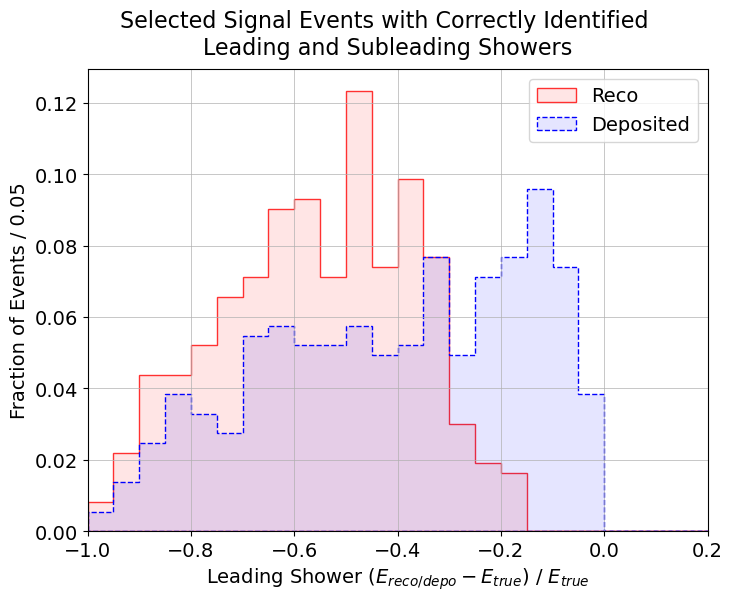

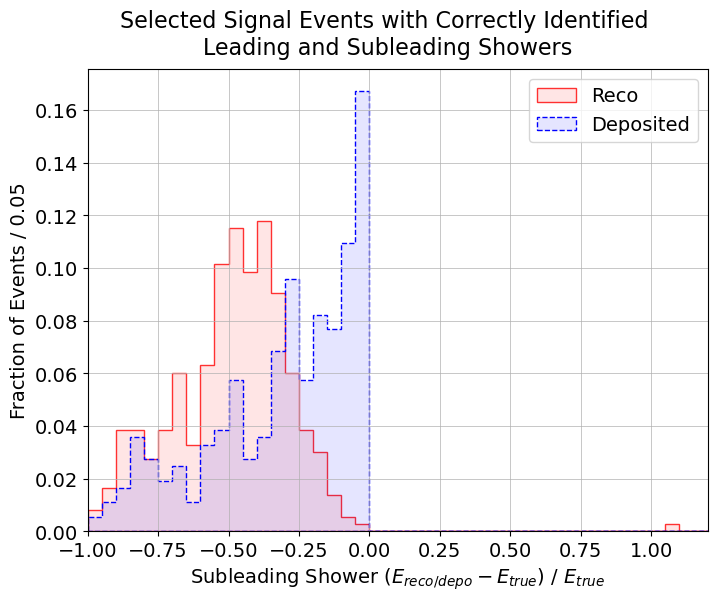

In [57]:
# Make leading shower energy resolution plots
energy_res_bins = np.linspace(-1,2, 61) 
energy_res_bins_size = 0.05
def make_lead_energy_shower_energy_res_plots_from_df(df, depo_eff_cutoff, energy_bins, bin_size, sample):

    df = df[df["lead_depo_efficiency"] > depo_eff_cutoff]
    num_events = len(df)
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    reco_res_counts, reco_res_bins = np.histogram(((df["reco_lead_shower_energy"]-df["lead_available_E"])/df["lead_available_E"]), bins=energy_bins)
    depo_res_counts, depo_res_bins = np.histogram(((df["lead_depo_E"]-df["lead_available_E"])/df["lead_available_E"]), bins=energy_bins)

    ax.hist(reco_res_bins[:-1], bins=energy_res_bins, weights=reco_res_counts/num_events, histtype='stepfilled', \
             edgecolor=(1,0,0,0.8), linestyle='-', linewidth=1, label=r'Reco', color=(1,0,0,0.1))
    ax.hist(depo_res_bins[:-1], bins=energy_res_bins, weights=depo_res_counts/num_events, histtype='stepfilled', \
             edgecolor=(0.0,0.0,1.0,1), linestyle='--', linewidth=1, label=r'Deposited', color=(0.0,0.0,1.0,0.1))
    ax.set_xlabel('Leading Shower ($E_{reco/depo}-E_{true}$) / $E_{true}$', fontsize=14)
    ax.set_ylabel(r'Fraction of Events / '+str(bin_size), fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(fontsize=14)
    plt.xlim(-1,0.2)
    plt.grid(linewidth=0.5) 

    fig.suptitle(sample, fontsize=16)

    #plt.colorbar(label='Counts')

    plt.show()

make_lead_energy_shower_energy_res_plots_from_df(reco_lead_and_sublead_match_df, 0, energy_res_bins, energy_res_bins_size, "Selected Signal Events with Correctly Identified \nLeading and Subleading Showers")
#make_lead_energy_shower_energy_res_plots_from_df(reco_signal_df_dict_diphoton, energy_res_bins, energy_res_bins_size, "Hand-Scanned Well Reco'd True CC1$\pi^0$ Events with Depo Efficiency > "+str(depo_energy_cut))

def make_sublead_energy_shower_energy_res_plots_from_df(df, depo_eff_cutoff, energy_bins, bin_size, sample):

    df = df[df["sublead_depo_efficiency"] > depo_eff_cutoff]
    num_events = len(df)
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    reco_res_counts, reco_res_bins = np.histogram(((df["reco_sublead_shower_energy"]-df["sublead_available_E"])/df["sublead_available_E"]), bins=energy_bins)
    depo_res_counts, depo_res_bins = np.histogram(((df["sublead_depo_E"]-df["sublead_available_E"])/df["sublead_available_E"]), bins=energy_bins)

    ax.hist(reco_res_bins[:-1], bins=energy_res_bins, weights=reco_res_counts/num_events, histtype='stepfilled', \
             edgecolor=(1,0,0,0.8), linestyle='-', linewidth=1, label=r'Reco', color=(1,0,0,0.1))
    ax.hist(depo_res_bins[:-1], bins=energy_res_bins, weights=depo_res_counts/num_events, histtype='stepfilled', \
             edgecolor=(0.0,0.0,1.0,1), linestyle='--', linewidth=1, label=r'Deposited', color=(0.0,0.0,1.0,0.1))
    ax.set_xlabel('Subleading Shower ($E_{reco/depo}-E_{true}$) / $E_{true}$', fontsize=14)
    ax.set_ylabel(r'Fraction of Events / '+str(bin_size), fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(fontsize=14)
    plt.xlim(-1,1.2)
    plt.grid(linewidth=0.5) 

    fig.suptitle(sample, fontsize=16)

    #plt.colorbar(label='Counts')

    plt.show()

make_sublead_energy_shower_energy_res_plots_from_df(reco_lead_and_sublead_match_df, 0, energy_res_bins, energy_res_bins_size, "Selected Signal Events with Correctly Identified \nLeading and Subleading Showers")


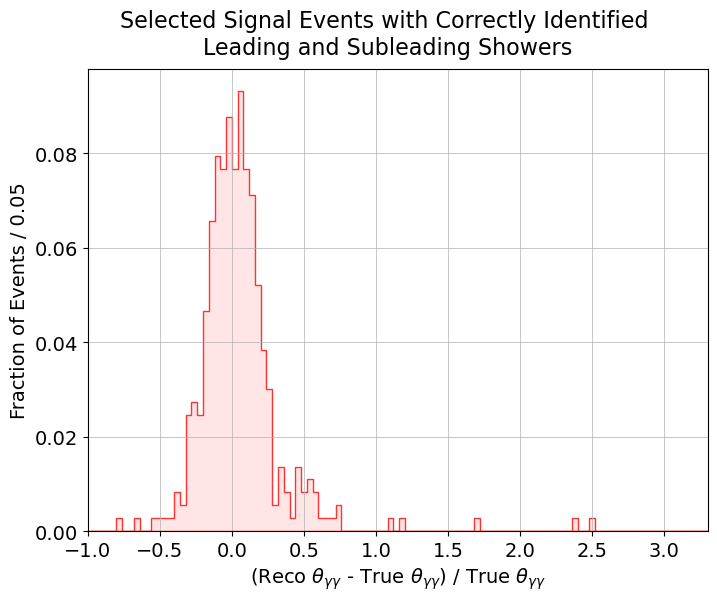

In [58]:
angle_res_bins = np.linspace(-5,5, 251) 
angle_res_bins_size = 0.05
def make_angle_res_plots_from_df(df, energy_bins, bin_size, sample):

    num_events = len(df)
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    reco_res_counts, reco_res_bins = np.histogram(((df["reco_shower_angle"]-df["dict_truth_shower_angle"])/df["dict_truth_shower_angle"]), bins=energy_bins)

    ax.hist(reco_res_bins[:-1], bins=angle_res_bins, weights=reco_res_counts/num_events, histtype='stepfilled', \
             edgecolor=(1,0,0,0.8), linestyle='-', linewidth=1, label=r'Reco', color=(1,0,0,0.1))
    ax.set_xlabel(r'(Reco $\theta_{\gamma\gamma}$ - True $\theta_{\gamma\gamma}$) / True $\theta_{\gamma\gamma}$', fontsize=14)
    ax.set_ylabel(r'Fraction of Events / '+str(bin_size), fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    #plt.legend(fontsize=14)
    plt.xlim(-1,3.3)
    plt.grid(linewidth=0.5) 

    fig.suptitle(sample, fontsize=16)

    #plt.colorbar(label='Counts')

    plt.show()

make_angle_res_plots_from_df(reco_lead_and_sublead_match_df, angle_res_bins, angle_res_bins_size, "Selected Signal Events with Correctly Identified \nLeading and Subleading Showers")


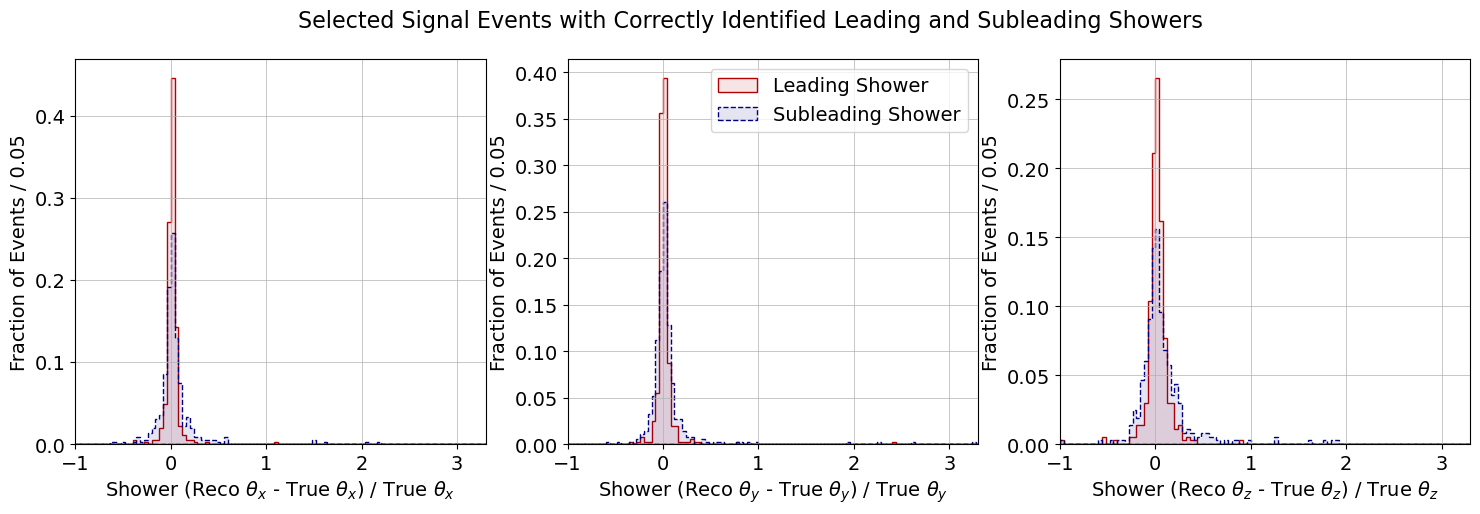

In [59]:
#  Anjgle resolution PLOTTING 
angle_res_bins = np.linspace(-5,5, 251) 
angle_res_bins_size = 0.05
def make_single_dim_angle_res_plots_from_df(df, energy_bins, bin_size, sample):

    num_events = len(df)
    fig, ax = plt.subplots(1,3,figsize=(18,5))
    lead_reco_res_countsx, lead_reco_res_binsx = np.histogram(((df["reco_lead_shower_thetax"]-df["dict_truth_lead_shower_thetax"])/df["dict_truth_lead_shower_thetax"]), bins=energy_bins)
    sublead_reco_res_countsx, sublead_reco_res_binsx = np.histogram(((df["reco_sublead_shower_thetax"]-df["dict_truth_sublead_shower_thetax"])/df["dict_truth_sublead_shower_thetax"]), bins=energy_bins)
    ax[0].hist(lead_reco_res_binsx[:-1], bins=angle_res_bins, weights=lead_reco_res_countsx/num_events, histtype='stepfilled', \
             edgecolor=(0.7,0,0,1), linestyle='-', linewidth=1, label=r'Leading Shower', color=(0.7,0,0,0.1))
    ax[0].hist(sublead_reco_res_binsx[:-1], bins=angle_res_bins, weights=sublead_reco_res_countsx/num_events, histtype='stepfilled', \
                edgecolor=(0,0,0.5,1), linestyle='--', linewidth=1, label=r'Subleading Shower', color=(0,0,0.5,0.1))
    ax[0].set_xlabel(r'Shower (Reco $\theta_{x}$ - True $\theta_{x}$) / True $\theta_{x}$', fontsize=14)
    ax[0].set_ylabel(r'Fraction of Events / '+str(bin_size), fontsize=14)
    ax[0].tick_params(axis='both', which='major', labelsize=14)
    #plt.legend(fontsize=14)
    ax[0].set_xlim(-1,3.3)
    ax[0].grid(linewidth=0.5) 

    lead_reco_res_countsy, lead_reco_res_binsy = np.histogram(((df["reco_lead_shower_thetay"]-df["dict_truth_lead_shower_thetay"])/df["dict_truth_lead_shower_thetay"]), bins=energy_bins)
    sublead_reco_res_countsy, sublead_reco_res_binsy = np.histogram(((df["reco_sublead_shower_thetay"]-df["dict_truth_sublead_shower_thetay"])/df["dict_truth_sublead_shower_thetay"]), bins=energy_bins)
    ax[1].hist(lead_reco_res_binsy[:-1], bins=angle_res_bins, weights=lead_reco_res_countsy/num_events, histtype='stepfilled', \
             edgecolor=(0.7,0,0,1), linestyle='-', linewidth=1, label=r'Leading Shower', color=(0.7,0,0,0.1))
    ax[1].hist(sublead_reco_res_binsy[:-1], bins=angle_res_bins, weights=sublead_reco_res_countsy/num_events, histtype='stepfilled', \
                edgecolor=(0,0,0.5,1), linestyle='--', linewidth=1, label=r'Subleading Shower', color=(0,0,0.5,0.1))
    ax[1].set_xlabel(r'Shower (Reco $\theta_{y}$ - True $\theta_{y}$) / True $\theta_{y}$', fontsize=14)
    ax[1].set_ylabel(r'Fraction of Events / '+str(bin_size) , fontsize=14)
    ax[1].tick_params(axis='both', which='major', labelsize=14)
    ax[1].legend(fontsize=14)
    ax[1].set_xlim(-1,3.3)
    ax[1].grid(linewidth=0.5) 

    lead_reco_res_countsz, lead_reco_res_binsz = np.histogram(((df["reco_lead_shower_thetaz"]-df["dict_truth_lead_shower_thetaz"])/df["dict_truth_lead_shower_thetaz"]), bins=energy_bins)
    sublead_reco_res_countsz, sublead_reco_res_binsz = np.histogram(((df["reco_sublead_shower_thetaz"]-df["dict_truth_sublead_shower_thetaz"])/df["dict_truth_sublead_shower_thetaz"]), bins=energy_bins)
    ax[2].hist(lead_reco_res_binsz[:-1], bins=angle_res_bins, weights=lead_reco_res_countsz/num_events, histtype='stepfilled', \
             edgecolor=(0.7,0,0,1), linestyle='-', linewidth=1, label=r'Leading Shower', color=(0.7,0,0,0.1))
    ax[2].hist(sublead_reco_res_binsz[:-1], bins=angle_res_bins, weights=sublead_reco_res_countsz/num_events, histtype='stepfilled', \
                edgecolor=(0,0,0.5,1), linestyle='--', linewidth=1, label=r'Subleading Shower', color=(0,0,0.5,0.1))
    ax[2].set_xlabel(r'Shower (Reco $\theta_{z}$ - True $\theta_{z}$) / True $\theta_{z}$', fontsize=14)
    ax[2].set_ylabel(r'Fraction of Events / '+str(bin_size) , fontsize=14)
    ax[2].tick_params(axis='both', which='major', labelsize=14)
    #ax[2].legend(fontsize=14)
    ax[2].set_xlim(-1,3.3)
    ax[2].grid(linewidth=0.5)

    fig.suptitle(sample, fontsize=16)

    #plt.colorbar(label='Counts')

    plt.show()

make_single_dim_angle_res_plots_from_df(reco_lead_and_sublead_match_df, angle_res_bins, angle_res_bins_size, "Selected Signal Events with Correctly Identified Leading and Subleading Showers")


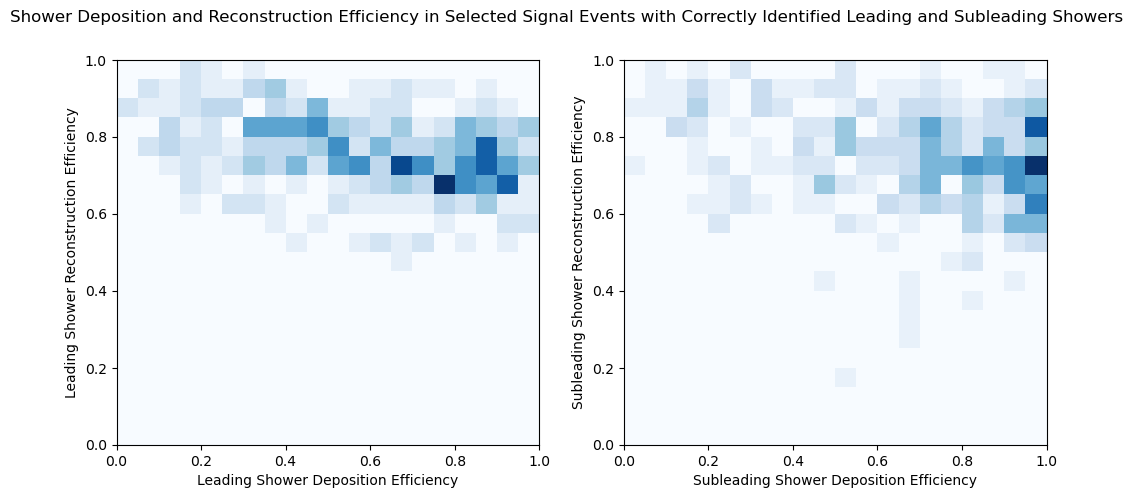

In [60]:
# Make leading shower 2D energy histogram
efficiency_bins = np.linspace(0, 1, 21) 
efficiency_bins_size = 0.05

def make_shower_energy_depo_reco_eff_2D_plots_from_df(df, energy_bins, bin_size, sample):

    num_events = len(df)
    fig, ax = plt.subplots(1,2,figsize=(12,5))
    lead_depo_eff_counts, lead_depo_eff_bins = np.histogram(df["lead_depo_efficiency"], bins=efficiency_bins)
    sublead_depo_eff_counts, sublead_depo_eff_bins = np.histogram(df["sublead_depo_efficiency"], bins=efficiency_bins)
    lead_reco_eff_counts, lead_reco_eff_bins = np.histogram(df["lead_reco_efficiency"], bins=efficiency_bins)
    sublead_reco_eff_counts, sublead_reco_eff_bins = np.histogram(df["sublead_reco_efficiency"], bins=efficiency_bins)


    ax[0].hist2d(df["lead_depo_efficiency"], df["lead_reco_efficiency"], bins=[efficiency_bins, efficiency_bins], cmap='Blues')
    ax[0].set_xlabel('Leading Shower Deposition Efficiency')
    ax[0].set_ylabel('Leading Shower Reconstruction Efficiency')

    ax[1].hist2d(df["sublead_depo_efficiency"], df["sublead_reco_efficiency"], bins=[efficiency_bins, efficiency_bins], cmap='Blues')
    ax[1].set_xlabel('Subleading Shower Deposition Efficiency')
    ax[1].set_ylabel('Subleading Shower Reconstruction Efficiency')

    fig.suptitle(r'Shower Deposition and Reconstruction Efficiency in ' + sample)


    #plt.colorbar(label='Counts')

    plt.show()

make_shower_energy_depo_reco_eff_2D_plots_from_df(reco_lead_and_sublead_match_df, efficiency_bins, efficiency_bins_size, "Selected Signal Events with Correctly Identified Leading and Subleading Showers")


In [61]:
depo_eff = 0.8
reco_signal_df_match_lead_sublead_0to0p5_depo = reco_signal_df_dict_diphoton[reco_signal_df_dict_diphoton['lead_depo_efficiency']<depo_eff]
reco_signal_df_match_lead_sublead_0to0p5_depo = reco_signal_df_match_lead_sublead_0to0p5_depo[reco_signal_df_match_lead_sublead_0to0p5_depo['sublead_depo_efficiency']<depo_eff]

reco_signal_df_match_lead_sublead_0p5to1_depo = reco_signal_df_dict_diphoton[reco_signal_df_dict_diphoton['lead_depo_efficiency']>depo_eff]
reco_signal_df_match_lead_sublead_0p5to1_depo = reco_signal_df_match_lead_sublead_0p5to1_depo[reco_signal_df_match_lead_sublead_0p5to1_depo['sublead_depo_efficiency']>depo_eff]

reco_signal_df_match_lead_sublead_0to0p5LEAD_0p5to1SUBLEAD_depo = reco_signal_df_dict_diphoton[reco_signal_df_dict_diphoton['lead_depo_efficiency']<depo_eff]
reco_signal_df_match_lead_sublead_0to0p5LEAD_0p5to1SUBLEAD_depo = reco_signal_df_match_lead_sublead_0to0p5LEAD_0p5to1SUBLEAD_depo[reco_signal_df_match_lead_sublead_0to0p5LEAD_0p5to1SUBLEAD_depo['sublead_depo_efficiency']>depo_eff]

reco_signal_df_match_lead_sublead_0p5to1LEAD_0to0p5SUBLEAD_depo = reco_signal_df_dict_diphoton[reco_signal_df_dict_diphoton['lead_depo_efficiency']>depo_eff]
reco_signal_df_match_lead_sublead_0p5to1LEAD_0to0p5SUBLEAD_depo = reco_signal_df_match_lead_sublead_0p5to1LEAD_0to0p5SUBLEAD_depo[reco_signal_df_match_lead_sublead_0p5to1LEAD_0to0p5SUBLEAD_depo['sublead_depo_efficiency']<depo_eff]


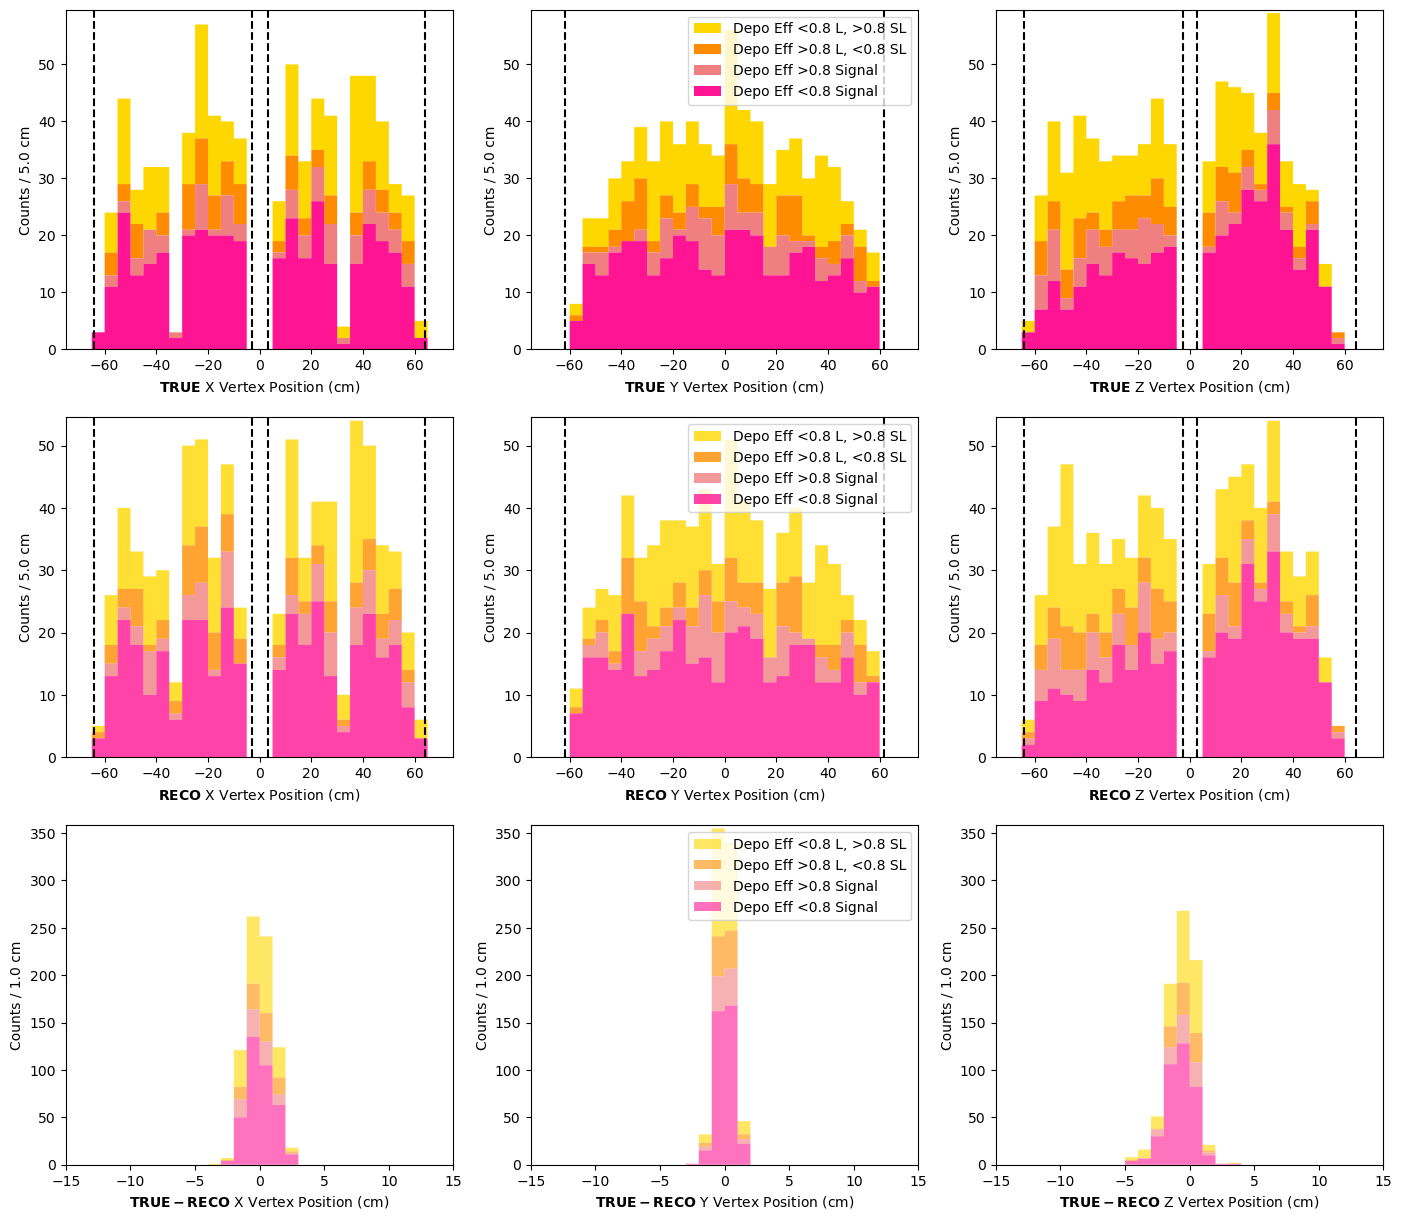

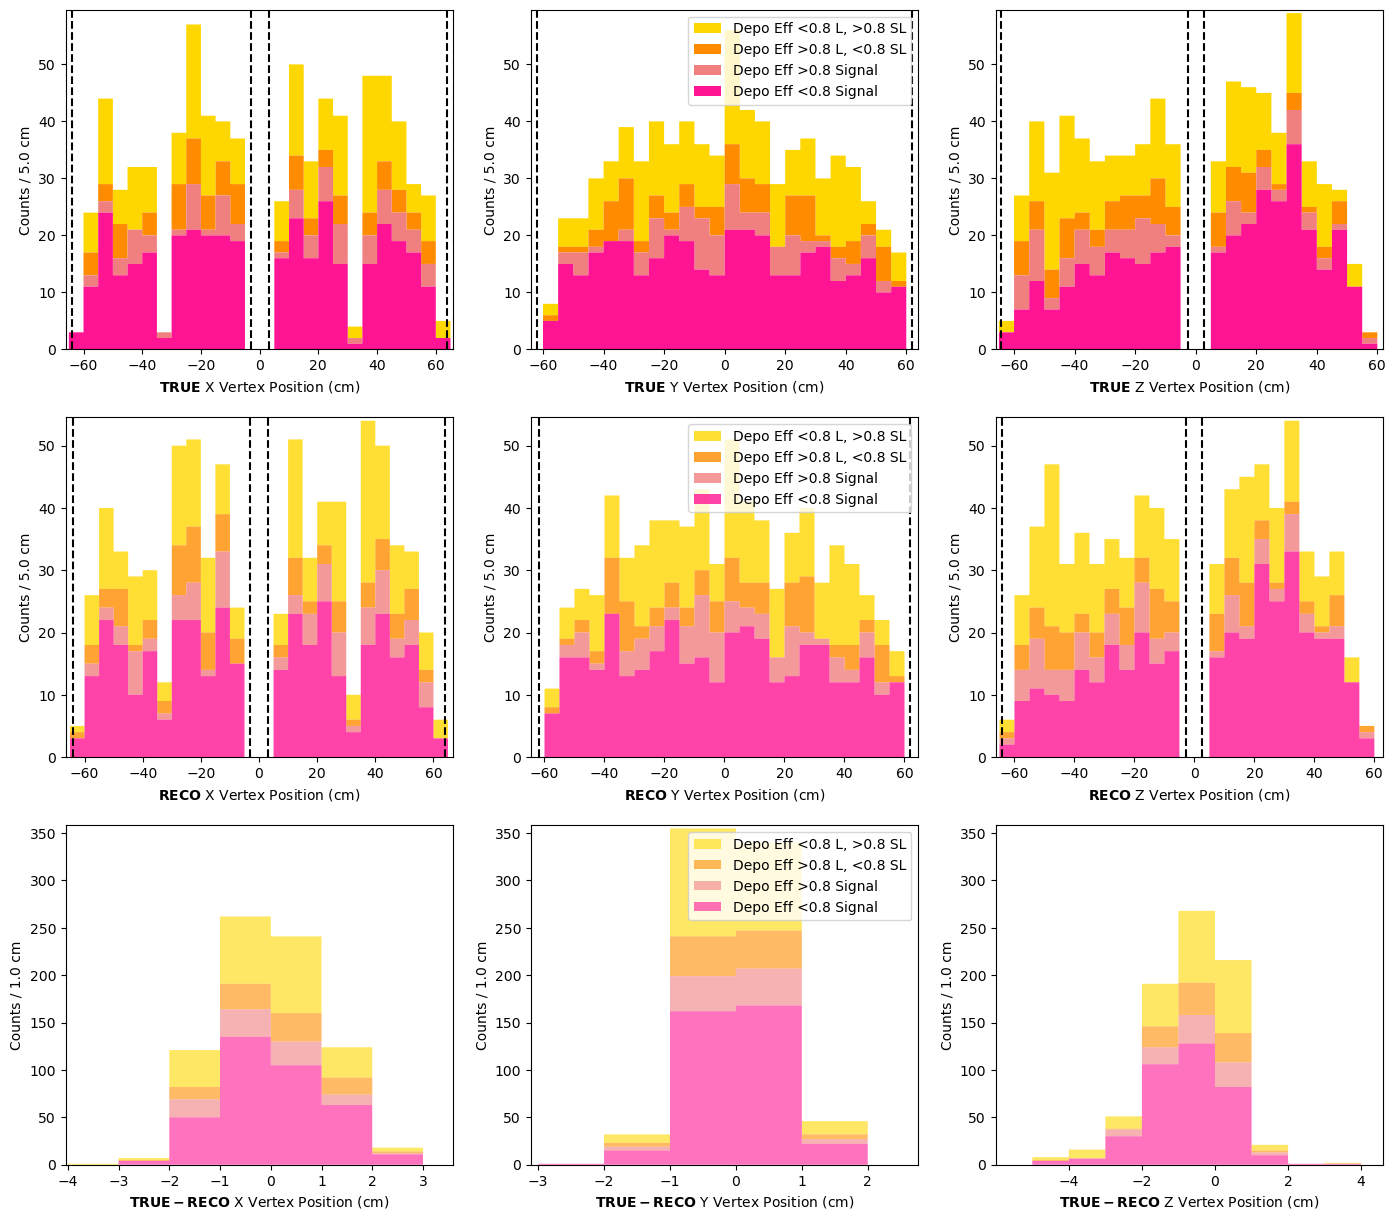

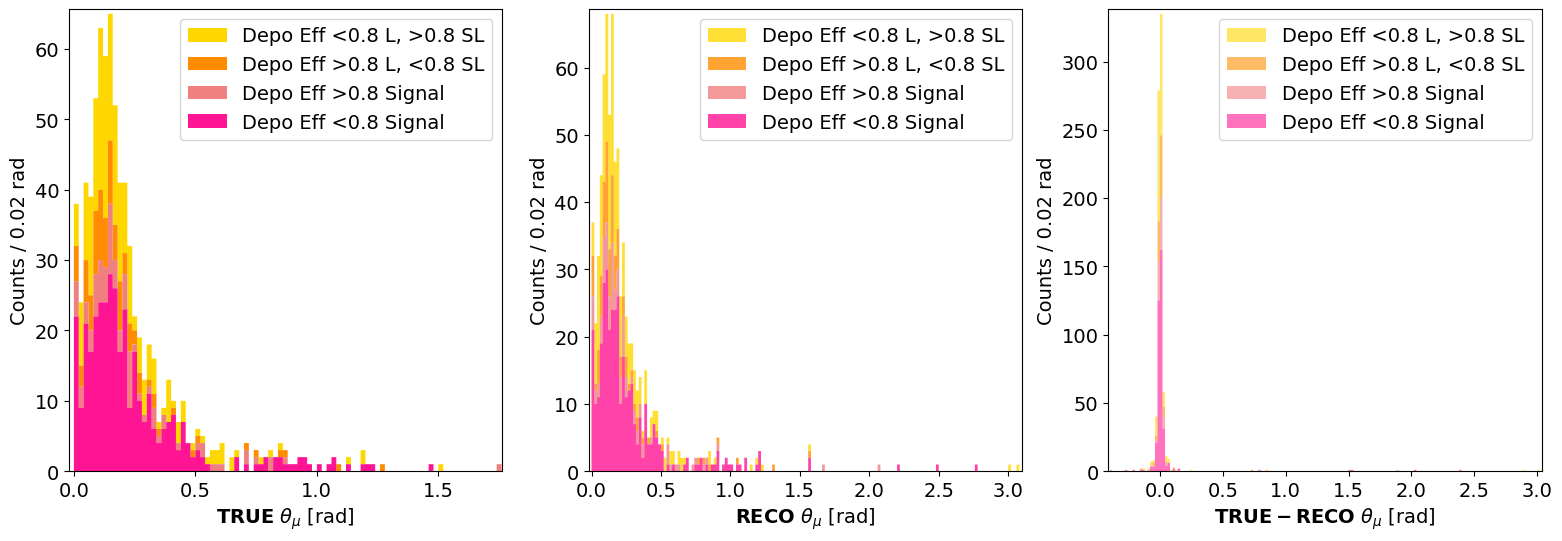

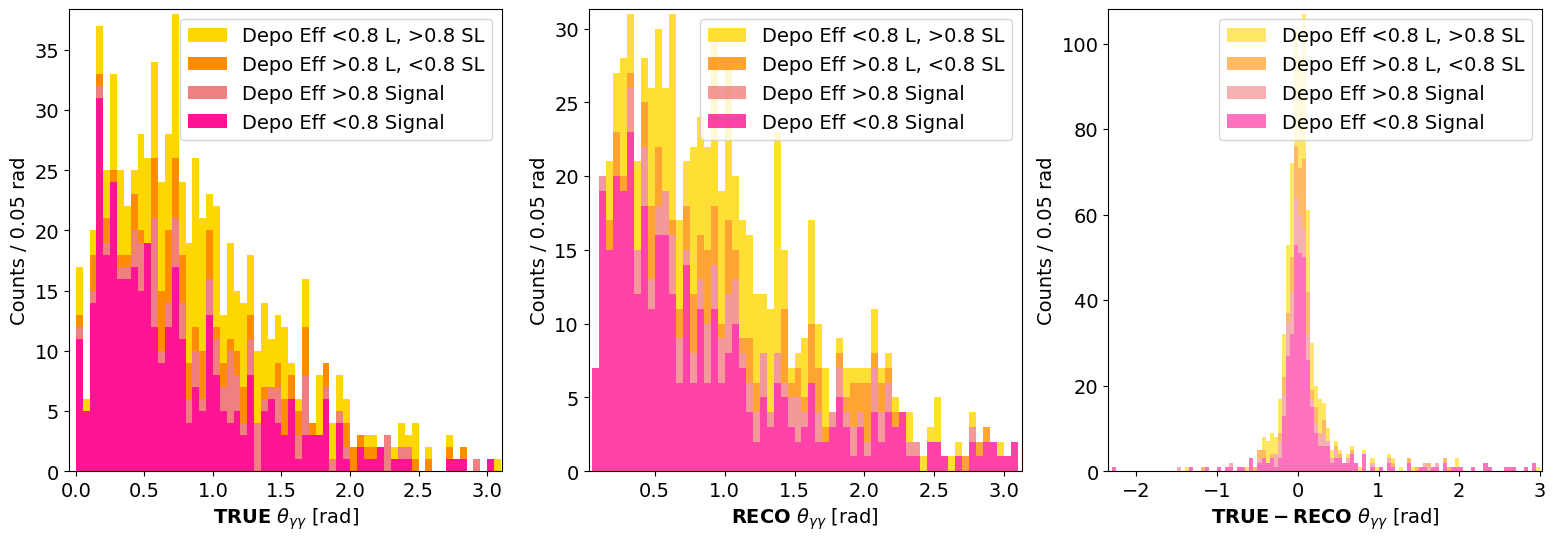

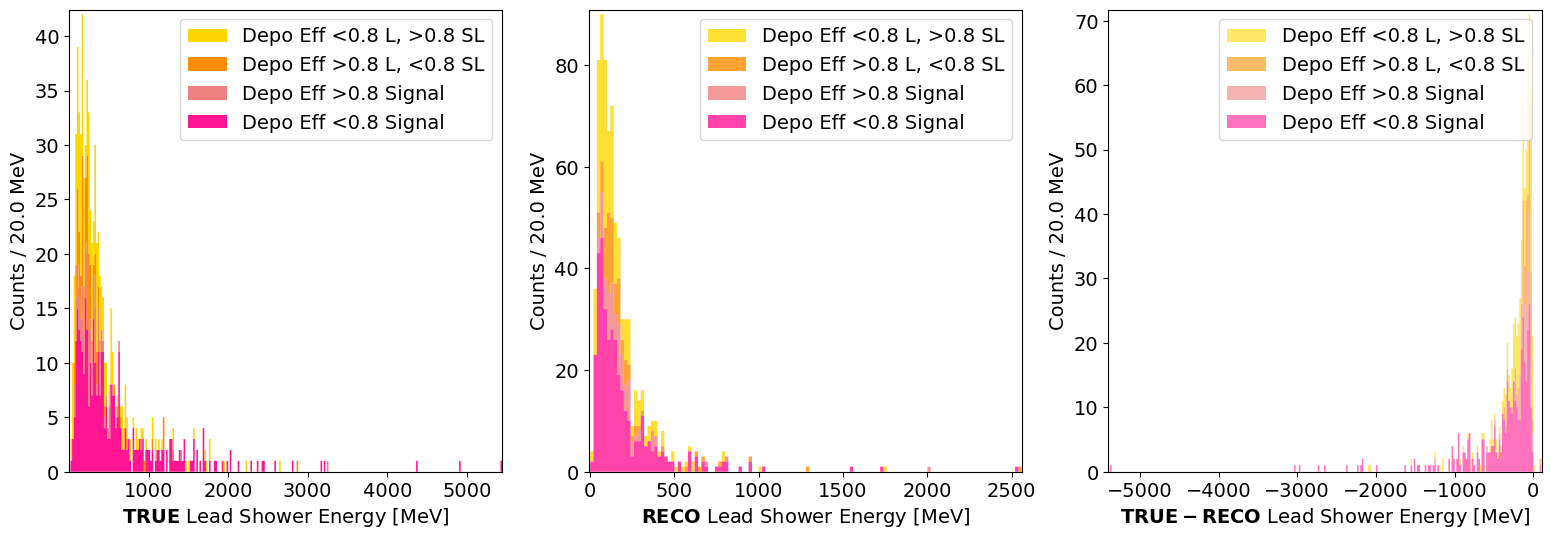

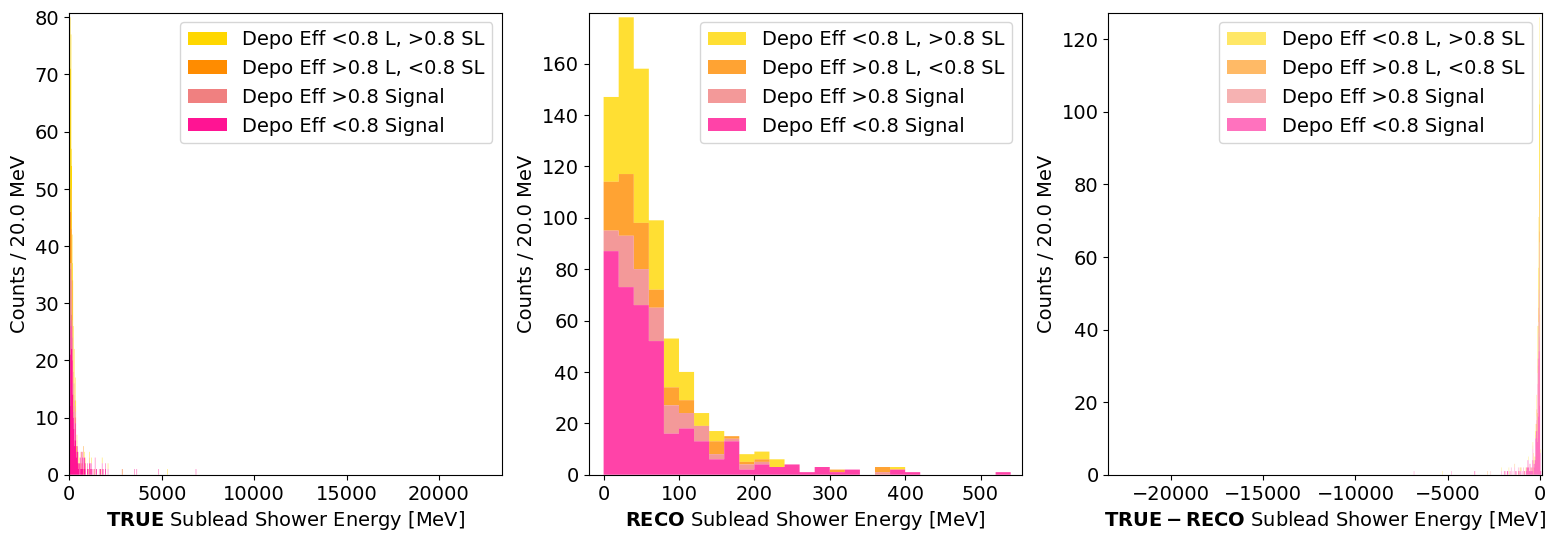

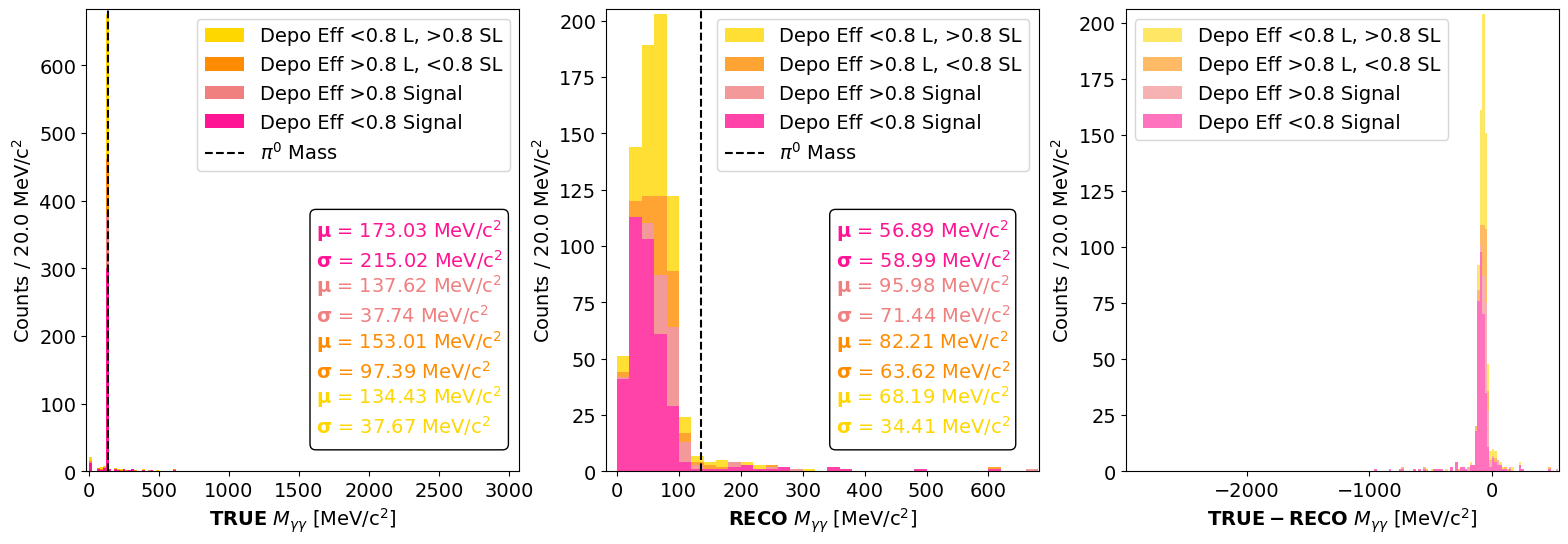

In [62]:
dataframes = [reco_signal_df_match_lead_sublead_0to0p5_depo, reco_signal_df_match_lead_sublead_0p5to1_depo, reco_signal_df_match_lead_sublead_0p5to1LEAD_0to0p5SUBLEAD_depo, reco_signal_df_match_lead_sublead_0to0p5LEAD_0p5to1SUBLEAD_depo]
labels = ['Depo Eff <0.8 Signal', 'Depo Eff >0.8 Signal', 'Depo Eff >0.8 L, <0.8 SL', 'Depo Eff <0.8 L, >0.8 SL']
colors = ['deeppink', 'lightcoral', 'darkorange', 'gold']
make_sig_bkg_vtx_pos_plots(dataframes, labels, colors, full_range=False)
make_sig_bkg_vtx_pos_plots(dataframes, labels, colors, full_range=True)

#fig1, ax1 = make_sig_bkg_muon_angle_plots(dataframes, labels, colors, full_range=False)
fig2, ax2 = make_sig_bkg_muon_angle_plots(dataframes, labels, colors, full_range=True)

#fig3, ax3 = make_sig_bkg_shower_angle_plots(dataframes, labels, colors, full_range=False)
fig4, ax4 = make_sig_bkg_shower_angle_plots(dataframes, labels, colors, full_range=True)

#fig5, ax5 = make_sig_bkg_lead_shower_energy_plots(dataframes, labels, colors, full_range=False)
fig6, ax6 = make_sig_bkg_lead_shower_energy_plots(dataframes, labels, colors, full_range=True)

#fig7, ax7 = make_sig_bkg_sublead_shower_energy_plots(dataframes, labels, colors, full_range=False)
fig8, ax8 = make_sig_bkg_sublead_shower_energy_plots(dataframes, labels, colors, full_range=True)

#fig9, ax9 = make_sig_bkg_mass_peak_plots(dataframes, labels, colors, full_range=False)
fig10, ax10 = make_sig_bkg_mass_peak_plots(dataframes, labels, colors, full_range=True)


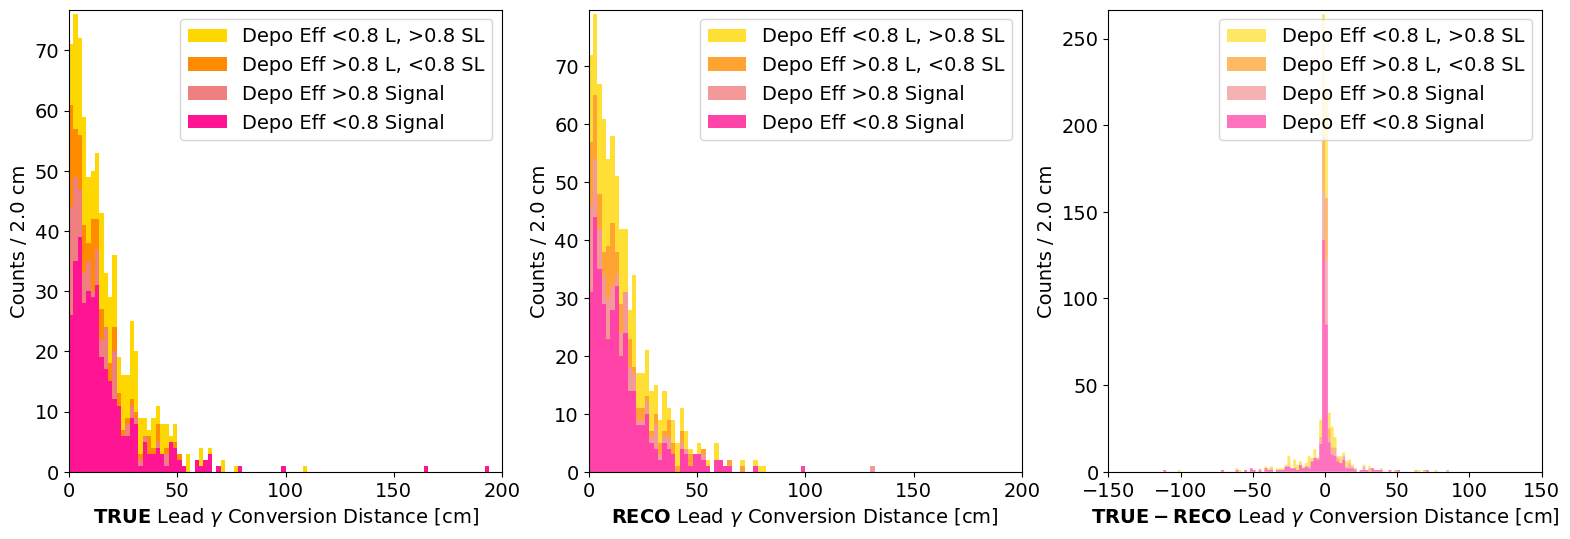

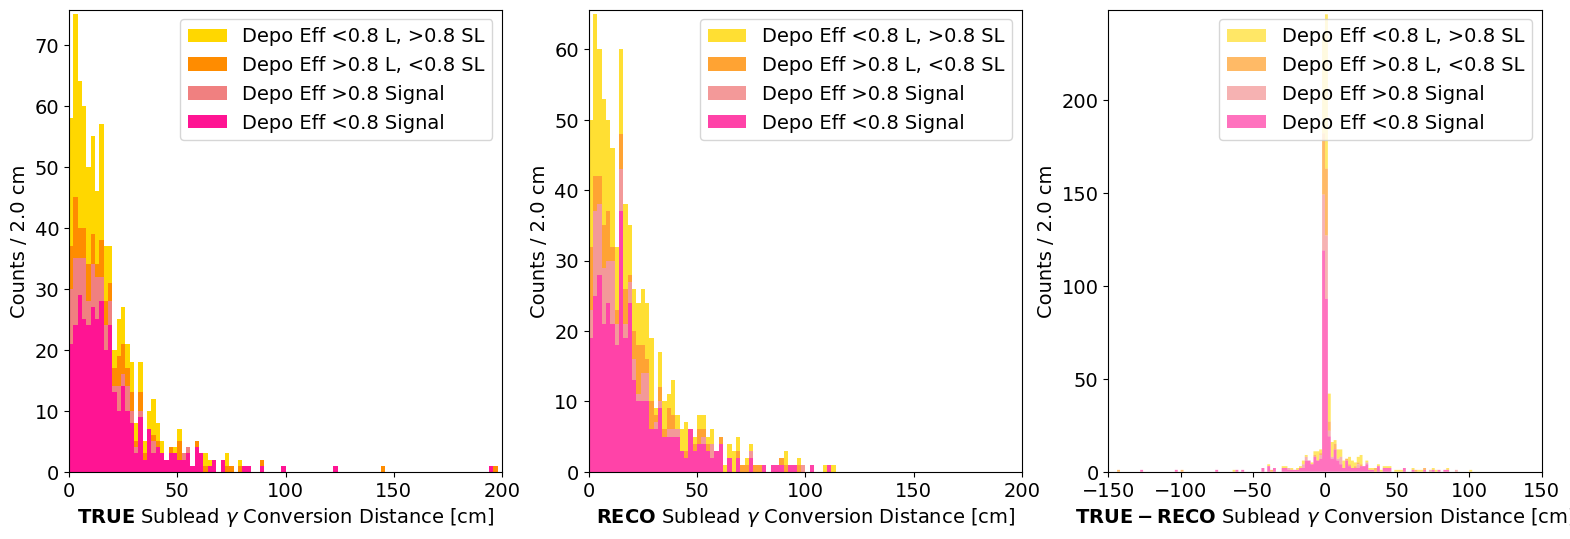

In [63]:
dataframes = [reco_signal_df_match_lead_sublead_0to0p5_depo, reco_signal_df_match_lead_sublead_0p5to1_depo, reco_signal_df_match_lead_sublead_0p5to1LEAD_0to0p5SUBLEAD_depo, reco_signal_df_match_lead_sublead_0to0p5LEAD_0p5to1SUBLEAD_depo]
labels = ['Depo Eff <0.8 Signal', 'Depo Eff >0.8 Signal', 'Depo Eff >0.8 L, <0.8 SL', 'Depo Eff <0.8 L, >0.8 SL']
colors = ['deeppink', 'lightcoral', 'darkorange', 'gold']

fig22, ax22 = make_sig_bkg_lead_shower_conv_dist_plots(dataframes, labels, colors, full_range=False, true_var_label="dict_true_lead_shower_conversion_distance")
fig21, ax21 = make_sig_bkg_sublead_shower_conv_dist_plots(dataframes, labels, colors, full_range=False, true_var_label="dict_true_sublead_shower_conversion_distance")